In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

import lightgbm
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from mlflow.models.evaluation import evaluate
import shap
import gc

from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from evidently.report import Report
from evidently.metrics import DataDriftTable, DatasetDriftMetric

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import fonctions as fc
import importlib

C:\Users\Anais\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(fc)

<module 'fonctions' from 'C:\\Users\\Anais\\Documents\\OpenClassRooms\\Projet7_Implementer_un_modele_de_scoring\\fonctions.py'>

# Enoncé

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.)

# Missions

- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.
- Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.
- Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.

# I- Description des données

- **application_{train|test}.csv :** Il s'agit de la table principale, divisée en deux fichiers pour Train (avec *TARGET*) et Test (sans *TARGET*).
Contient des informations sur chaque demande de prêt chez Home Credit. Une ligne représente un prêt dans notre échantillon de données et est identifié par la caractéristique SK_ID_CURR.

- **bureau.csv :** Données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit antérieur a sa propre ligne dans le bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits antérieurs.
  
- **bureau_balance.csv :** Données mensuelles concernant les crédits antérieurs dans le bureau. Chaque ligne correspond à un mois d'un crédit antérieur, et un seul crédit antérieur peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.

- **previous_application.csv :** Demandes antérieures de prêts auprès de Home Credit pour les clients qui ont des prêts dans les données de demande. Chaque prêt en cours dans les données de la demande peut avoir plusieurs prêts antérieurs. Chaque demande antérieure a une ligne et est identifiée par la caractéristique SK_ID_PREV.
  
- **POS_CASH_balance.csv :** Données mensuelles sur les précédents prêts au point de vente ou au comptant que les clients ont eus avec Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt au comptant antérieur, et un seul prêt antérieur peut avoir plusieurs lignes.
  
- **credit_card_balance.csv :** Données mensuelles sur les cartes de crédit que les clients ont déjà eues avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.

- **installments_payment.csv :** Historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

- **HomeCredit_columns_description.csv :** Ce fichier contient les descriptions des colonnes des différents fichiers de données.

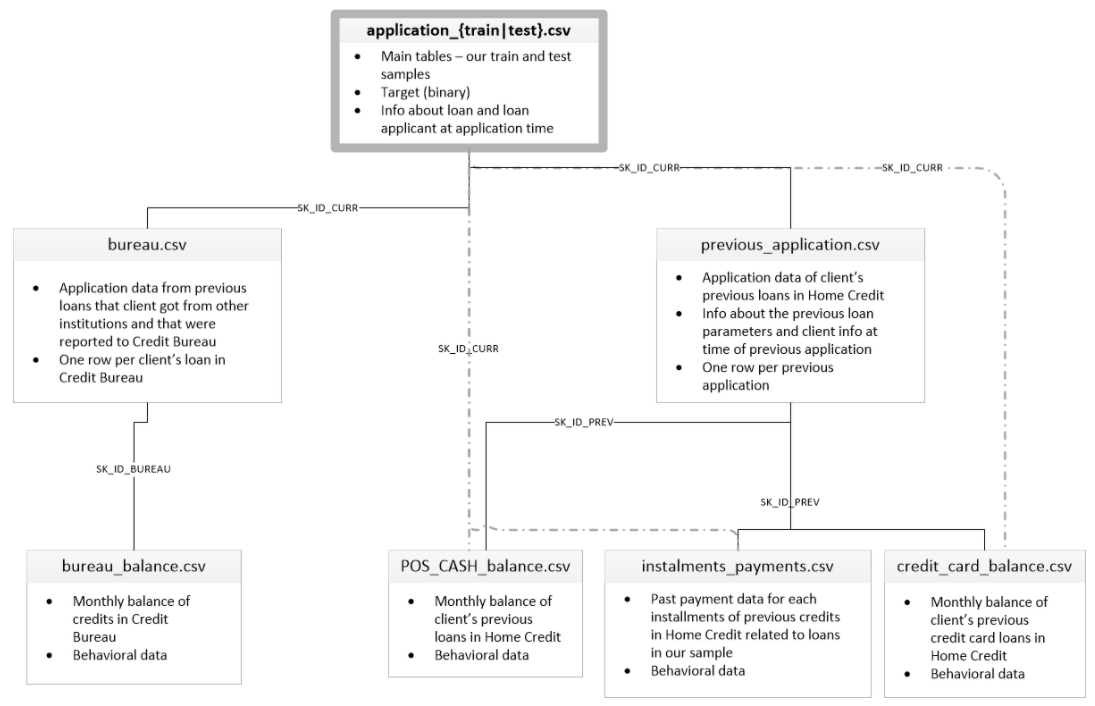


# II- Analyse exploratoire des données

## 2.1 - Application_train

In [3]:
df_train = pd.read_csv('application_train.csv')
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [4]:
df_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [5]:
print(df_train.shape)
print("Le nombre de doublons dans df est de : ", df_train[df_train.duplicated()].shape[0])
df_train.describe()

(307511, 122)
Le nombre de doublons dans df est de :  0


SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868  -16036.995067   63815.045904  ...   
std                      0.013831    4363.988632  141275.766519  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -2760.000000  ...   
50%                      0.018850  -15750.000000   -1213.000000  ...   
75%                      0.028663  -12413.000000    -289.000000  ...   
max                      0.072508   -7489.000000  365243.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                    0.000000  
25%              

<Axes: >

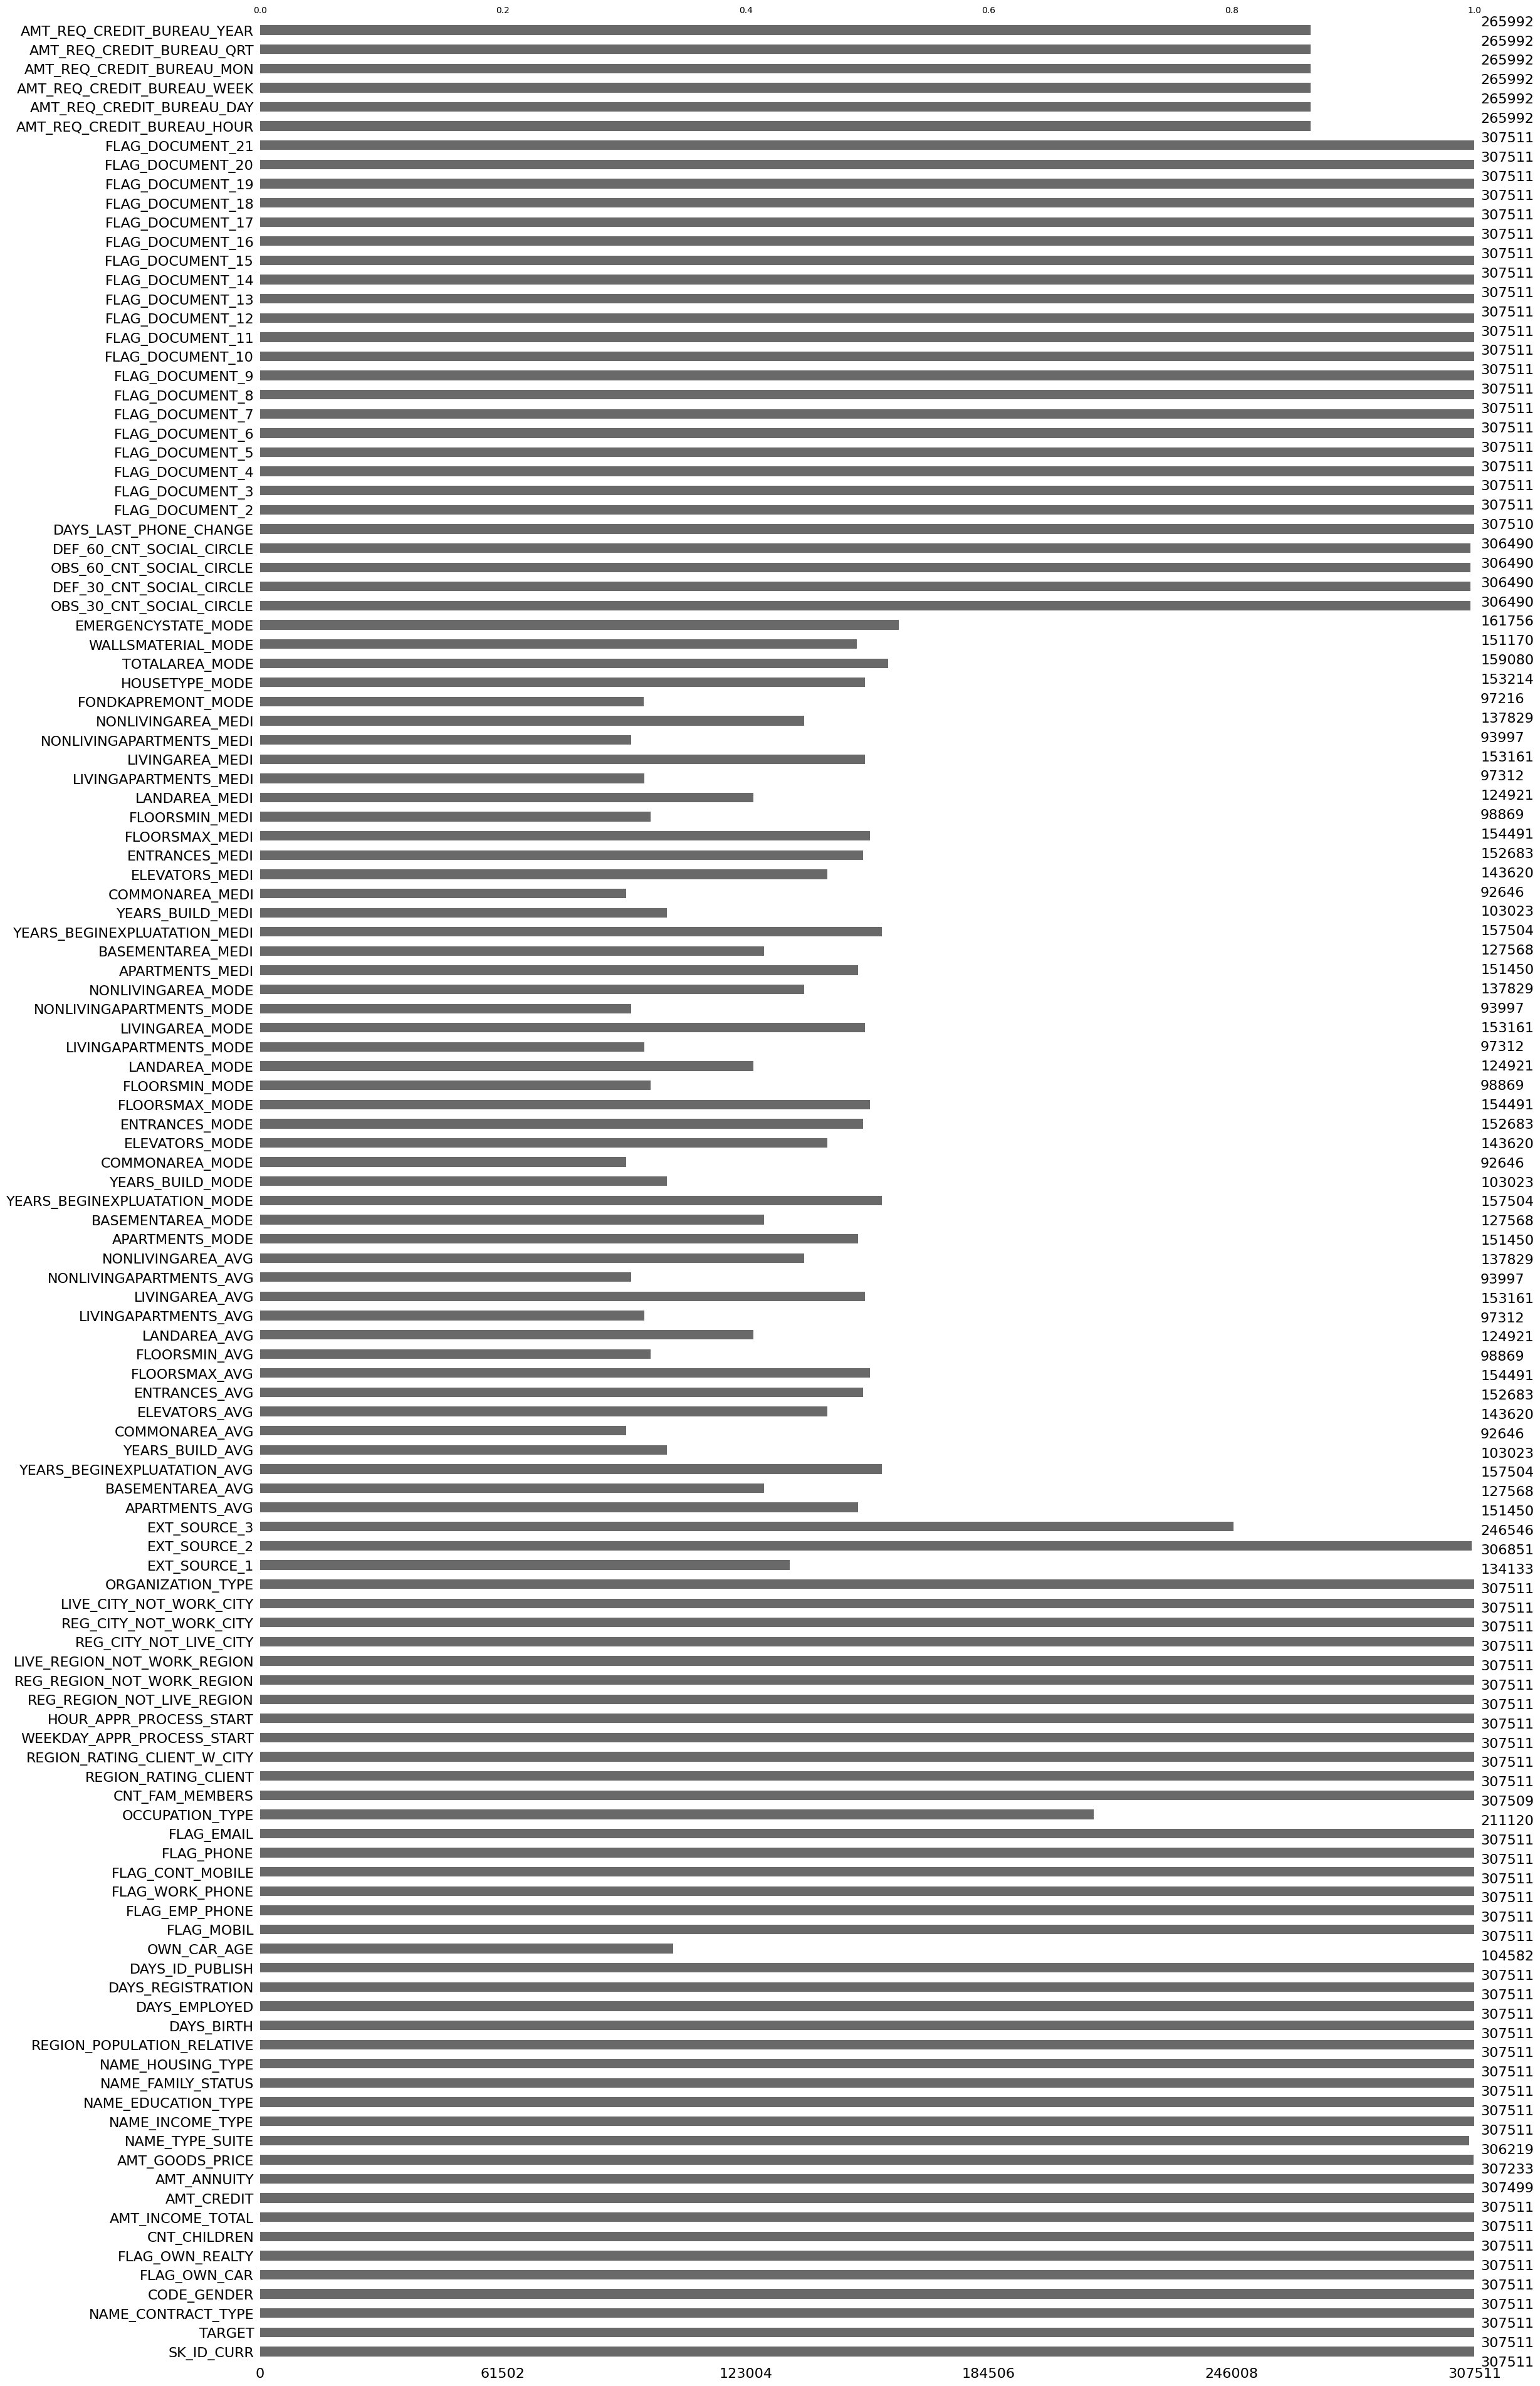

In [6]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
msno.bar(df_train)

Sur 122 colonnes, 67 colonnes ont des valeurs manquantes. Nous devrons imputer ces valeurs manquantes. Par la suite, nous utiliserons des modèles tels que XGBoost qui peuvent traiter les valeurs manquantes sans nécessiter d'imputation. Une autre option consisterait à supprimer les colonnes présentant un pourcentage élevé de valeurs manquantes, bien qu'il soit impossible de savoir à l'avance si ces colonnes seront utiles à notre modèle. Par conséquent, nous conserverons toutes les colonnes pour l'instant.

In [7]:
colonnes_quanti_train = df_train.select_dtypes(include=['float64', 'int64']).columns
cor = df_train[colonnes_quanti_train].corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', cor.tail(15))
print('\nMost Negative Correlations:\n', cor.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


Les corrélations entre la cible et les autres caractéristiques ne sont pas fortes. 

Les principales Variables numériques intéressantes pour la classification (plus forte corrélation avec la cible) sont :
- EXT_SOURCE_3
- EXT_SOURCE_2
- EXT_SOURCE_1
- DAYS_BIRTH

### Variable TARGET

On considère les personnes avec au moins un retard de paiement (1) comme défaillant et les autres cas (0) comme non défaillant. Visualisons leur distribution.

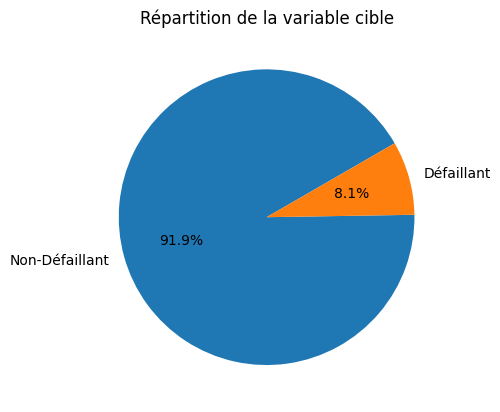

In [8]:
#Représentation graphique de la distribution de la variable TARGET
count_df = df_train['TARGET'].replace({0: 'Non-Défaillant', 1: 'Défaillant'}).copy().value_counts().to_frame().reset_index()
plt.figure()
plt.pie(count_df['count'], labels=count_df['TARGET'], autopct='%1.1f%%', startangle=30)
plt.title('Répartition de la variable cible')
plt.show()

del count_df

On observe une grande disparité entre les deux groupes avec une minortité de "Défaillantes" (8.1%), n'ayant pas remboursé leur prêt. 
Ces informations montrent qu'il s'agit d'un problème de classe déséquilibrées. Par la suite, nous pourrons tenir compte de cette informations et pondérer les classes en fonctions de leur représentation dans les données afin de refléter ce désequilibre.

### Variable DAYS_EMPLOYED

In [9]:
df_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

'DAYS_EMPLOYED' ne semble pas correct. La valeur maximale (en plus d'être positive) est d'environ 1000 ans.

### Variable DAY_BIRTH

In [10]:
(df_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Ces âges semblent raisonnables. Il n'y a pas de valeurs aberrantes pour l'âge, que ce soit à l'extrémité min ou max.

Si l'on examine la documentation, DAYS_BIRTH est l'âge en jours du client au moment du prêt en jours négatifs. La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie que plus le client vieillit, moins il est susceptible de ne pas rembourser son prêt (c'est-à-dire que la cible == 0). C'est un peu déroutant, nous prendrons donc la valeur absolue de la caractéristique et la corrélation sera négative.

In [11]:
# Correlation avec la target
df_train['DAYS_BIRTH'] = abs(df_train['DAYS_BIRTH'])
df_train['DAYS_BIRTH'].corr(df_train['TARGET'])

-0.07823930830982709

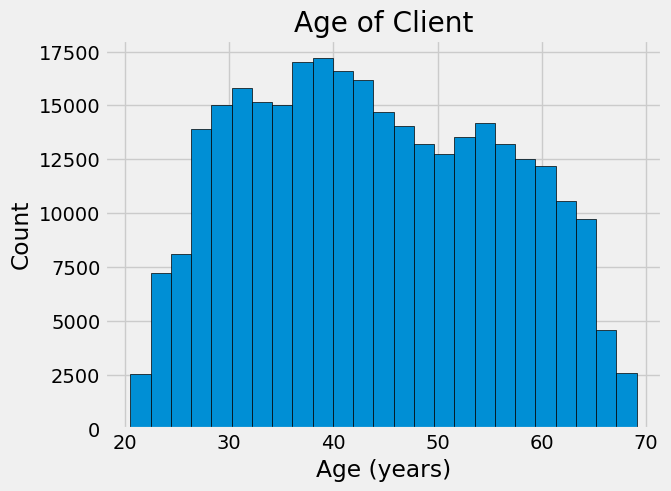

In [12]:
plt.style.use('fivethirtyeight')

# Plot de la distribution des ages des clients
plt.hist(df_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

En soi, la distribution de l'âge ne nous apprend pas grand-chose, si ce n'est qu'il n'y a pas de valeurs aberrantes puisque tous les âges sont raisonnables. Pour visualiser l'effet de l'âge sur la cible, nous allons ensuite tracer un graphique d'estimation de la densité du noyau (KDE) coloré par la valeur de la cible. Un graphique d'estimation de la densité du noyau montre la distribution d'une variable unique et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement une gaussienne, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer une seule courbe lisse). Nous utiliserons le kdeplot de seaborn pour ce graphique.

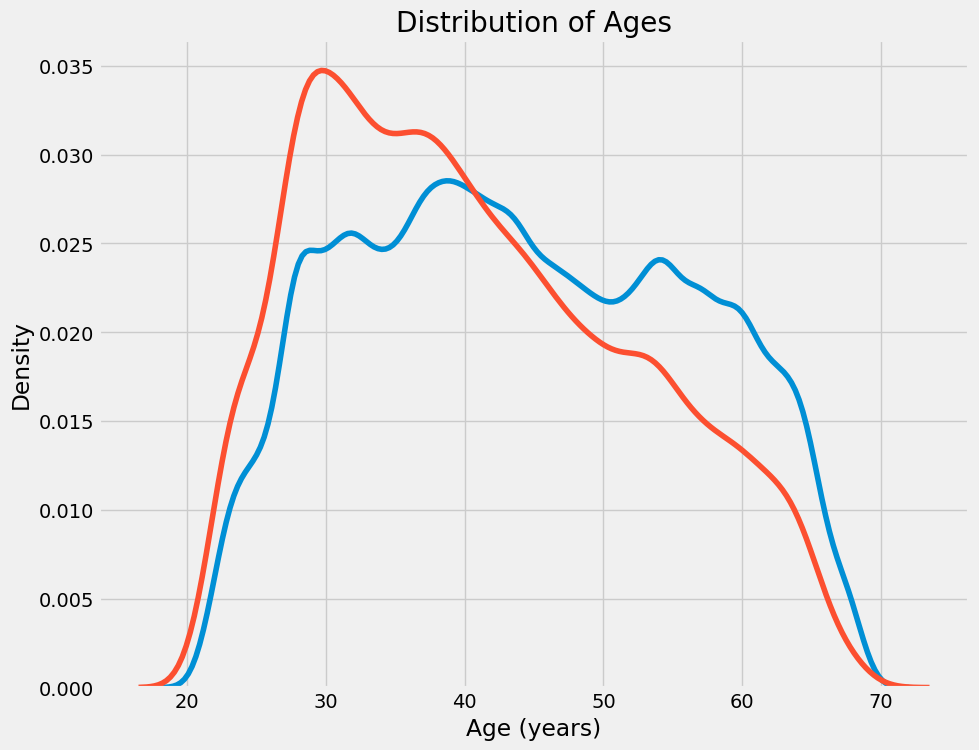

In [13]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

La courbe de la cible == 1 penche vers l'extrémité la plus jeune de la fourchette. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Examinons cette relation sous un autre angle : le taux moyen de non-remboursement des prêts par tranche d'âge.

Pour réaliser ce graphique, nous découpons d'abord la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque tranche, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

In [14]:
# Age information into a separate dataframe
age_data = df_train[['TARGET', 'DAYS_BIRTH']].copy()
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [15]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

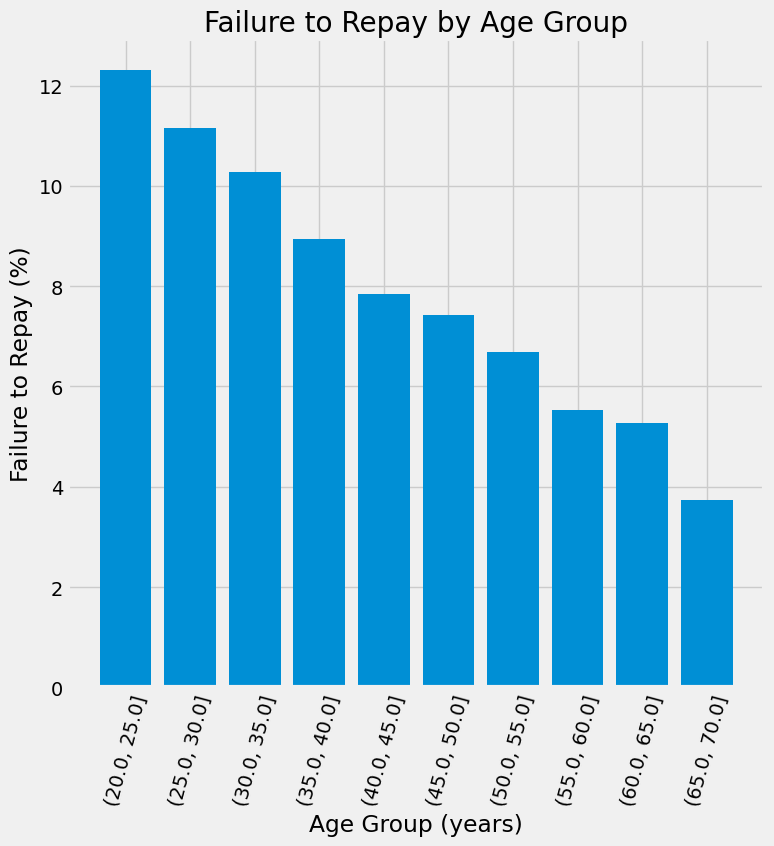

In [16]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

La tendance est claire : les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt ! Le taux de non-remboursement est supérieur à 10 % pour les trois groupes d'âge les plus jeunes et inférieur à 5 % pour le groupe le plus âgé.

Il s'agit d'une information qui pourrait être directement utilisée par la banque : étant donné que les jeunes clients sont moins susceptibles de rembourser le prêt, il conviendrait peut-être de leur fournir davantage de conseils ou d'astuces en matière de planification financière. Cela ne signifie pas que la banque doive discriminer les jeunes clients, mais il serait judicieux de prendre des mesures de précaution pour les aider à rembourser à temps.

### Variables EXT_SOURCE

In [17]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = df_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

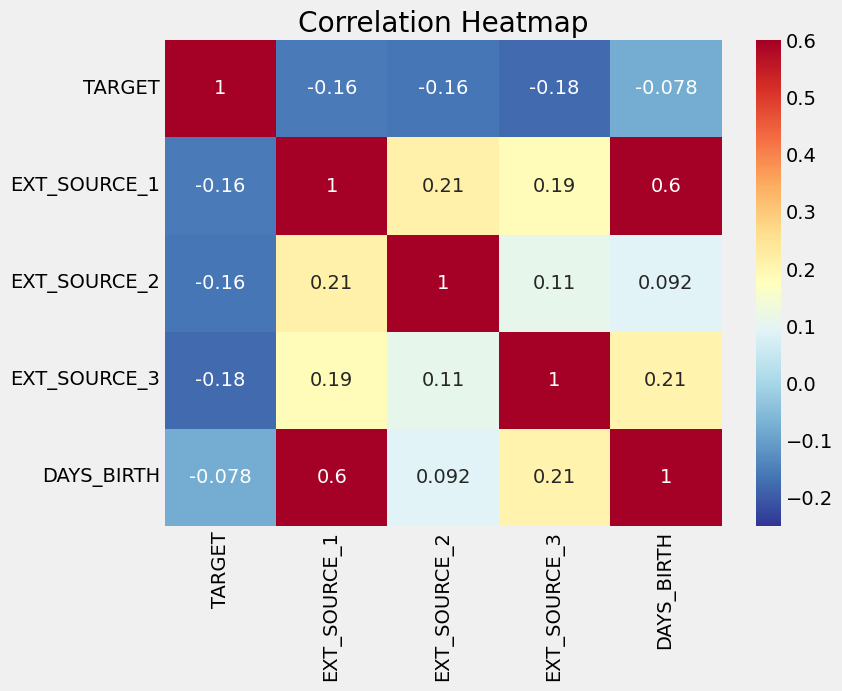

In [18]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de l'EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également constater que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, ce qui indique que l'âge du client est peut-être l'un des facteurs de ce score.

Nous pouvons ensuite examiner la distribution de chacune de ces caractéristiques en fonction de la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

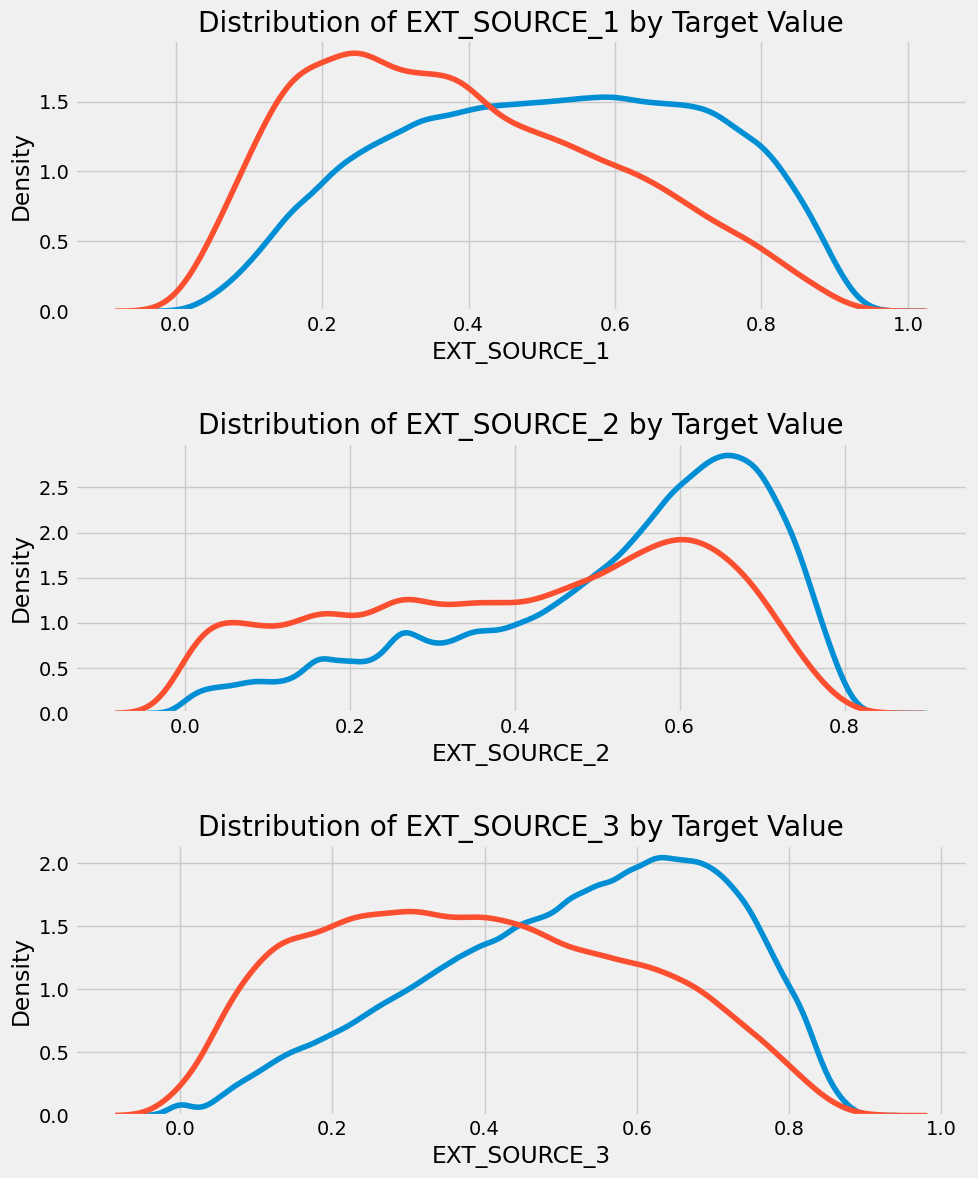

In [19]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, elles sont toutes considérées comme très faibles), mais ces variables seront toujours utiles pour un modèle d'apprentissage automatique permettant de prédire si un demandeur remboursera ou non un prêt dans les délais.


### Variable OCCUPATION_TYPE

Cette variable indique la catégorie socio-professionnelle du demandeur

In [20]:
df_train['OCCUPATION_TYPE'].unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', nan,
       'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

C:\Users\Anais\Documents\OpenClassRooms\Projet7_Implementer_un_modele_de_scoring\fonctions.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
C:\Users\Anais\Documents\OpenClassRooms\Projet7_Implementer_un_modele_de_scoring\fonctions.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


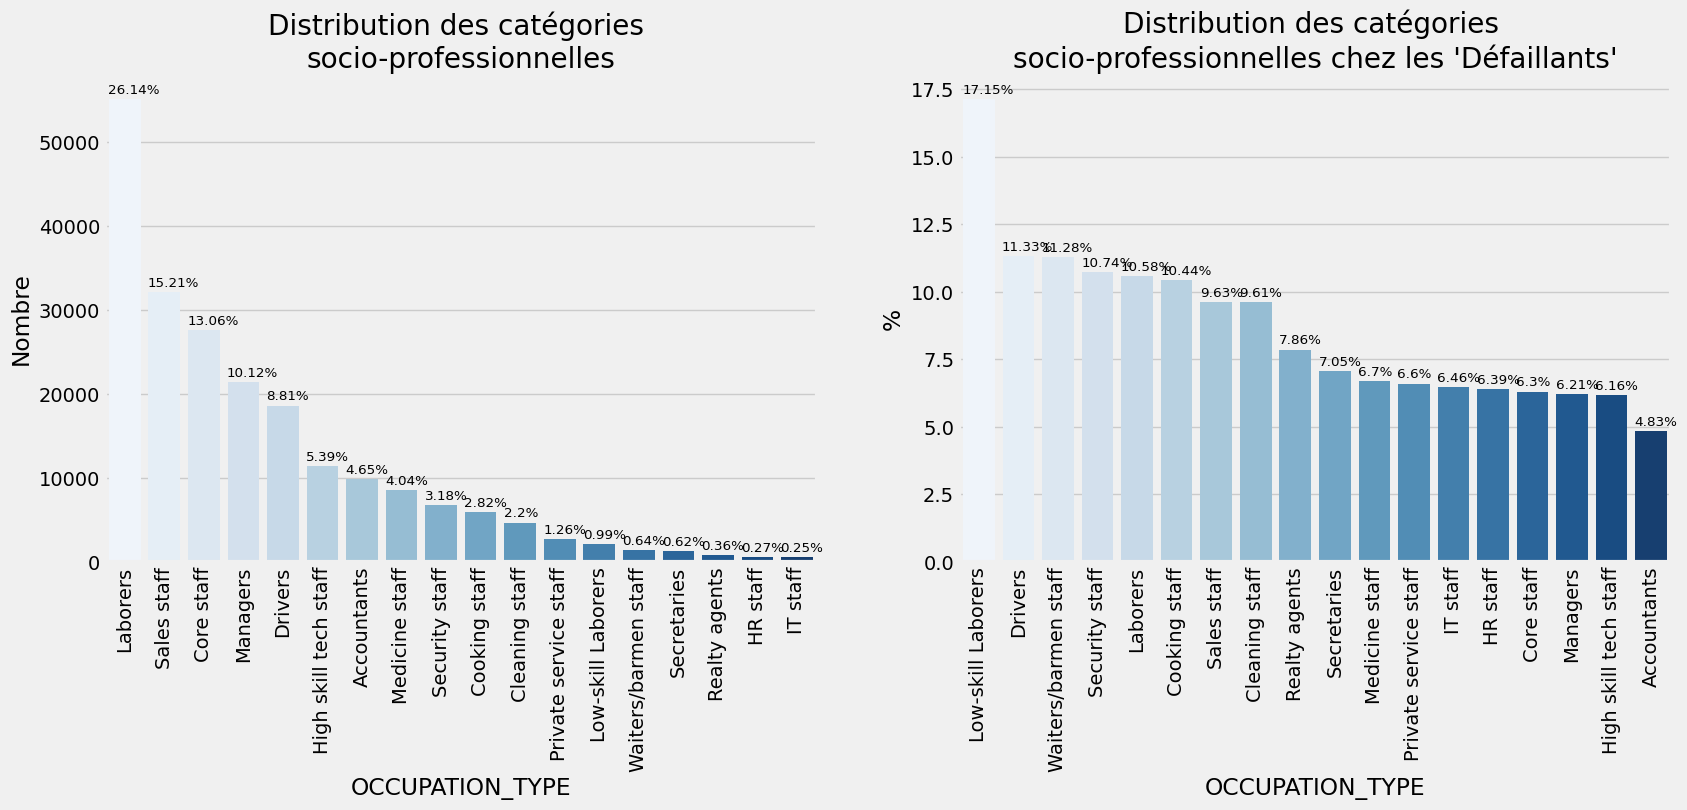

In [21]:
fc.plot_distrib_var_object(df_train, 'OCCUPATION_TYPE')

Il semble que les catégories socio-professionnelles ayant le taux de défaillance le plus élevé concerne ceux nécessitant le moins d'étude 

## 2.2- Application test

In [22]:
df_test = pd.read_csv('application_test.csv')
df_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [23]:
df_test.dtypes.value_counts()

float64    65
int64      40
object     16
Name: count, dtype: int64

In [24]:
print(df_test.shape)
print("Le nombre de doublons dans df est de : ", df_test[df_test.duplicated()].shape[0])
df_test.describe()

(48744, 121)
Le nombre de doublons dans df est de :  0


SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count   48744.000000  48744.000000      4.874400e+04  4.874400e+04   
mean   277796.676350      0.397054      1.784318e+05  5.167404e+05   
std    103169.547296      0.709047      1.015226e+05  3.653970e+05   
min    100001.000000      0.000000      2.694150e+04  4.500000e+04   
25%    188557.750000      0.000000      1.125000e+05  2.606400e+05   
50%    277549.000000      0.000000      1.575000e+05  4.500000e+05   
75%    367555.500000      1.000000      2.250000e+05  6.750000e+05   
max    456250.000000     20.000000      4.410000e+06  2.245500e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count   48720.000000     4.874400e+04                48744.000000   
mean    29426.240209     4.626188e+05                    0.021226   
std     16016.368315     3.367102e+05                    0.014428   
min      2295.000000     4.500000e+04                    0.000253   
25%     17973.000000     2.250000e+05                    0.010006   
50%     26199.000000     3.960000e+05                    0.018850   
75%     37390.500000     6.300000e+05                    0.028663   
max    180576.000000     2.245500e+06                    0.072508   

         DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  ...  FLAG_DOCUMENT_18  \
count  48744.000000   48744.000000       48744.000000  ...      48744.000000   
mean  -16068.084605   67485.366322       -4967.652716  ...          0.001559   
std     4325.900393  144348.507136        3552.612035  ...          0.039456   
min   -25195.000000  -17463.000000      -23722.000000  ...          0.000000   
25%   -19637.000000   -2910.000000       -7459.250000  ...          0.000000   
50%   -15785.000000   -1293.000000       -4490.000000  ...          0.000000   
75%   -12496.000000    -296.000000       -1901.000000  ...          0.000000   
max    -7338.000000  365243.000000           0.000000  ...          1.000000   

       FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count           48744.0           48744.0           48744.0   
mean                0.0               0.0               0.0   
std                 0.0               0.0               0.0   
min                 0.0               0.0               0.0   
25%                 0.0               0.0               0.0   
50%                 0.0               0.0               0.0   
75%                 0.0               0.0               0.0   
max                 0.0               0.0               0.0   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count                42695.000000               42695.000000   
mean                     0.002108                   0.001803   
std                      0.046373                   0.046132   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      2.000000                   2.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count                42695.000000               42695.000000   
mean                     0.002787                   0.009299   
std                      0.054037                   0.110924   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      2.000000                   6.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count               42695.000000                42695.000000  
mean                    0.546902                    1.983769  
std                     0.693305                    1.838873  
min                     0.000000                    0.000000  

Comme pour les données train, on créé la nouvelle colonne d'anomalie et on remplit la colonne existante avec des np.nan 

<Axes: >

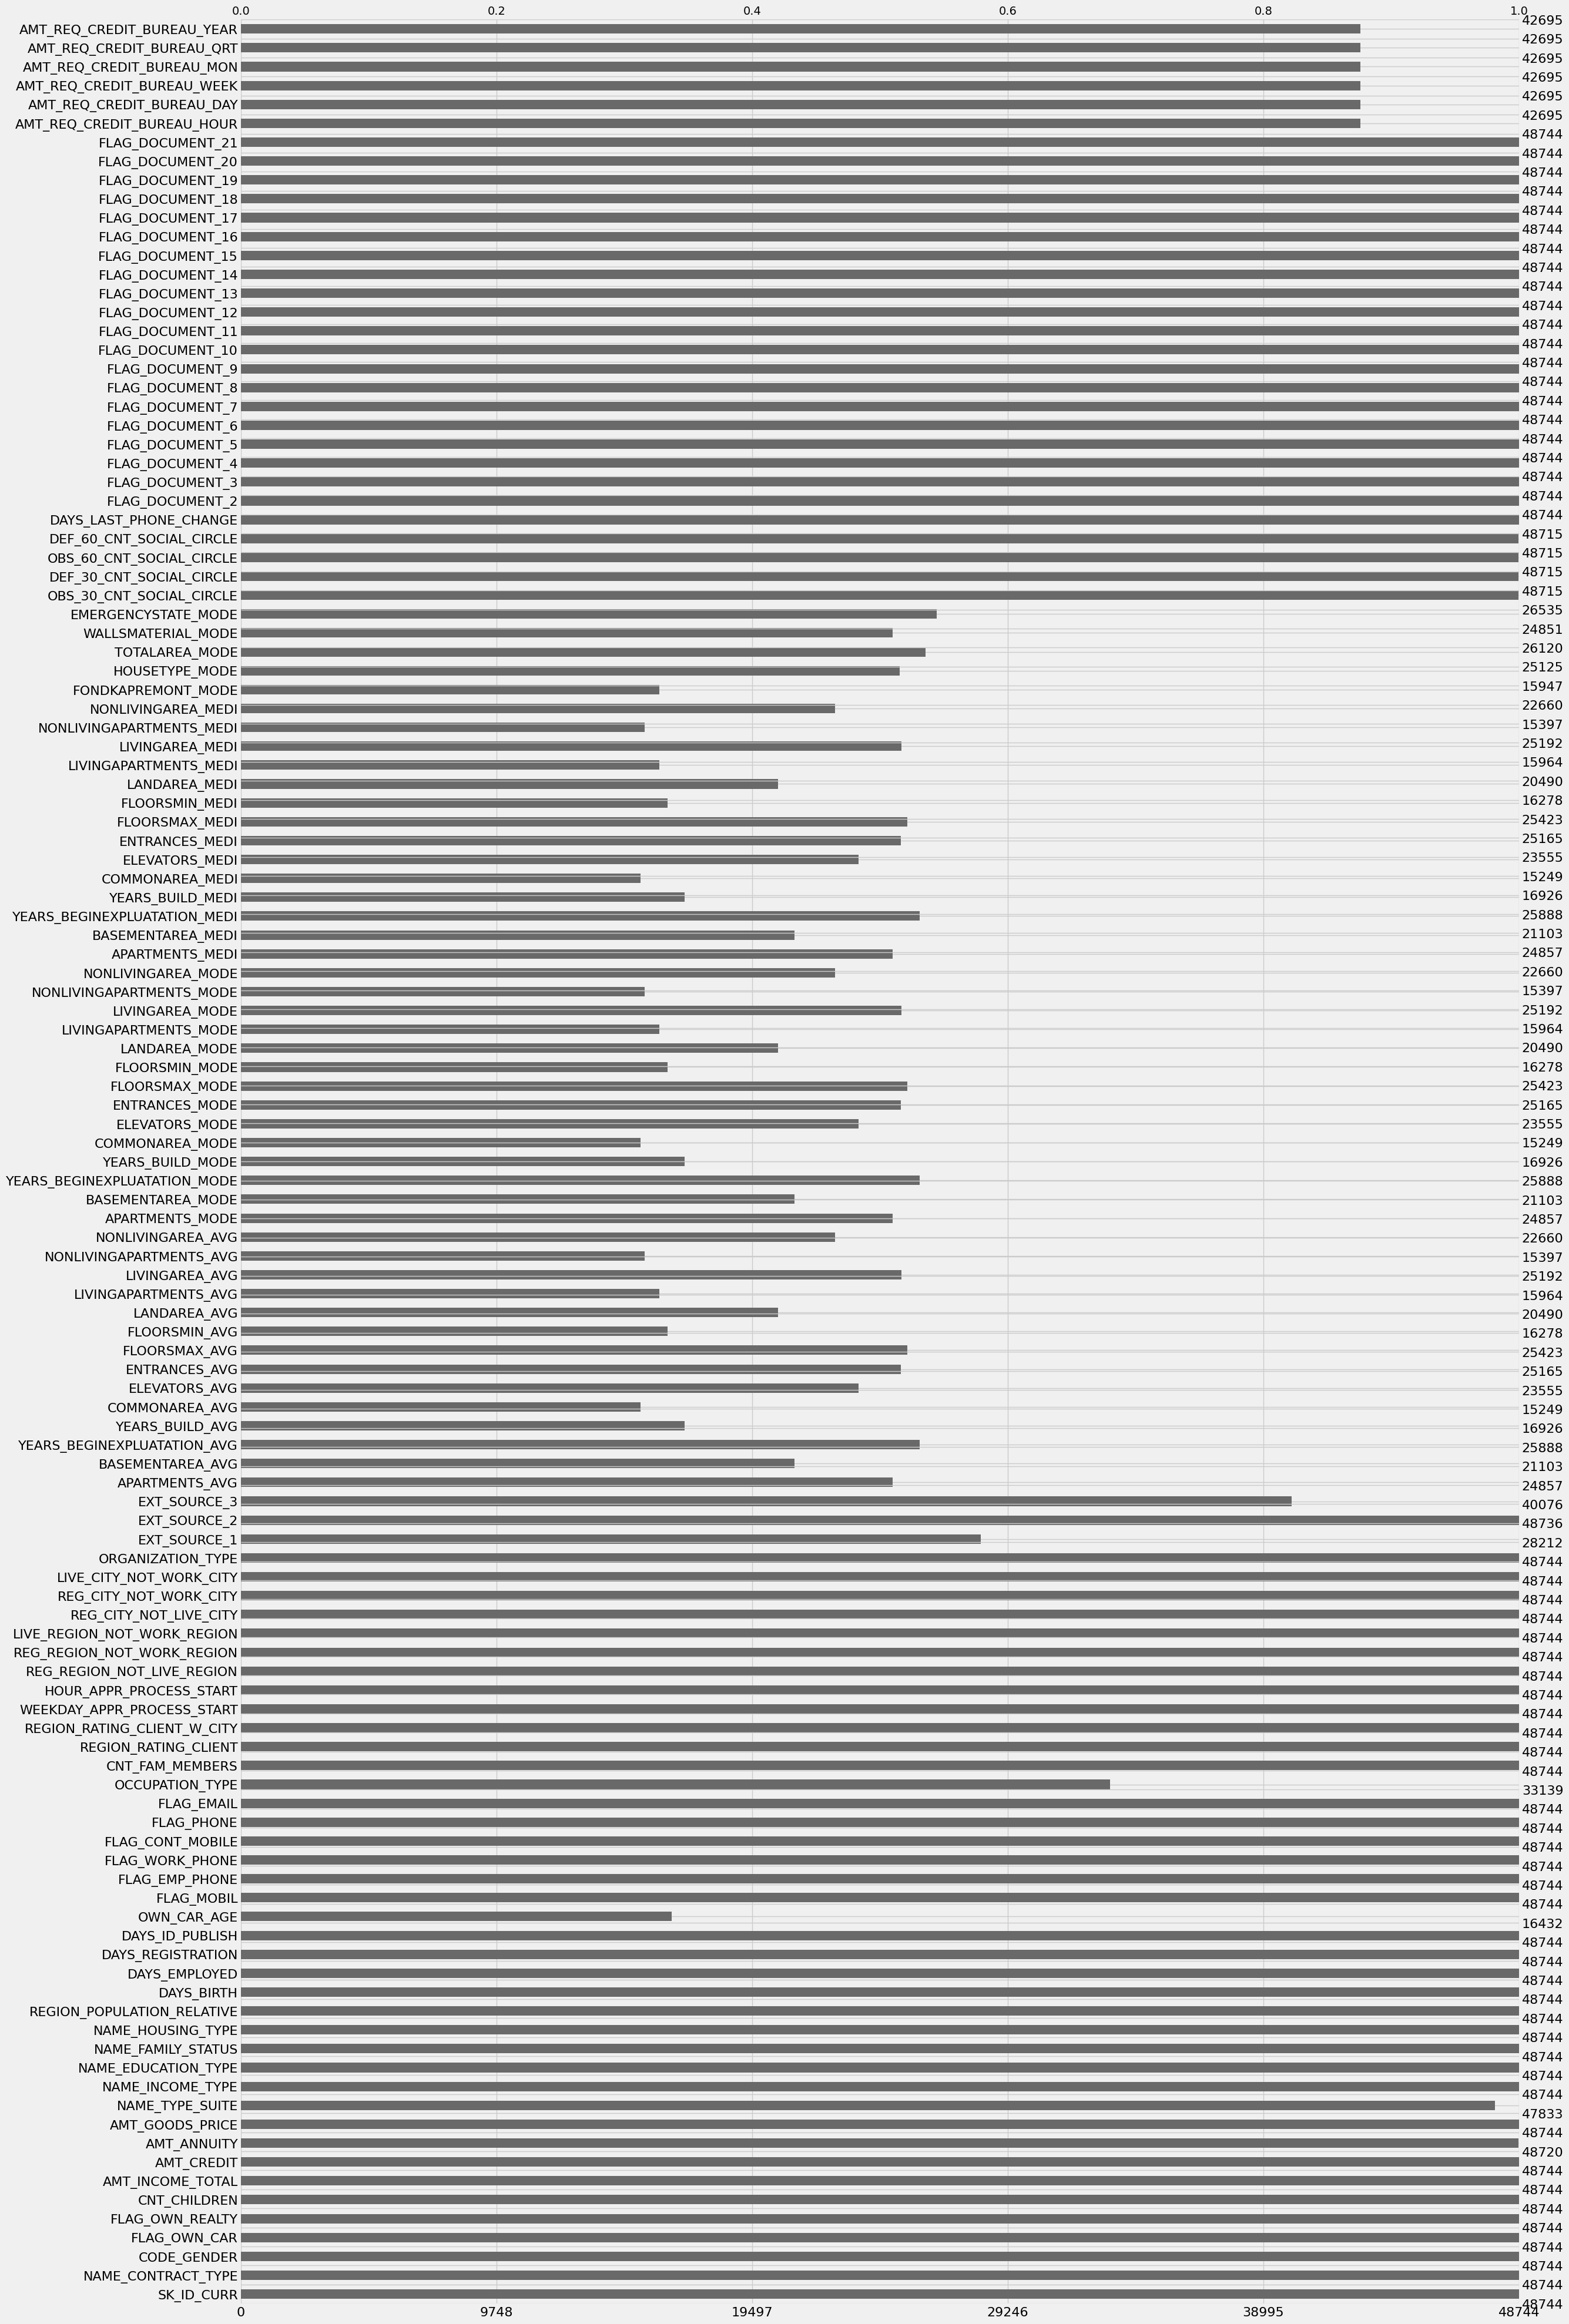

In [25]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
msno.bar(df_test)

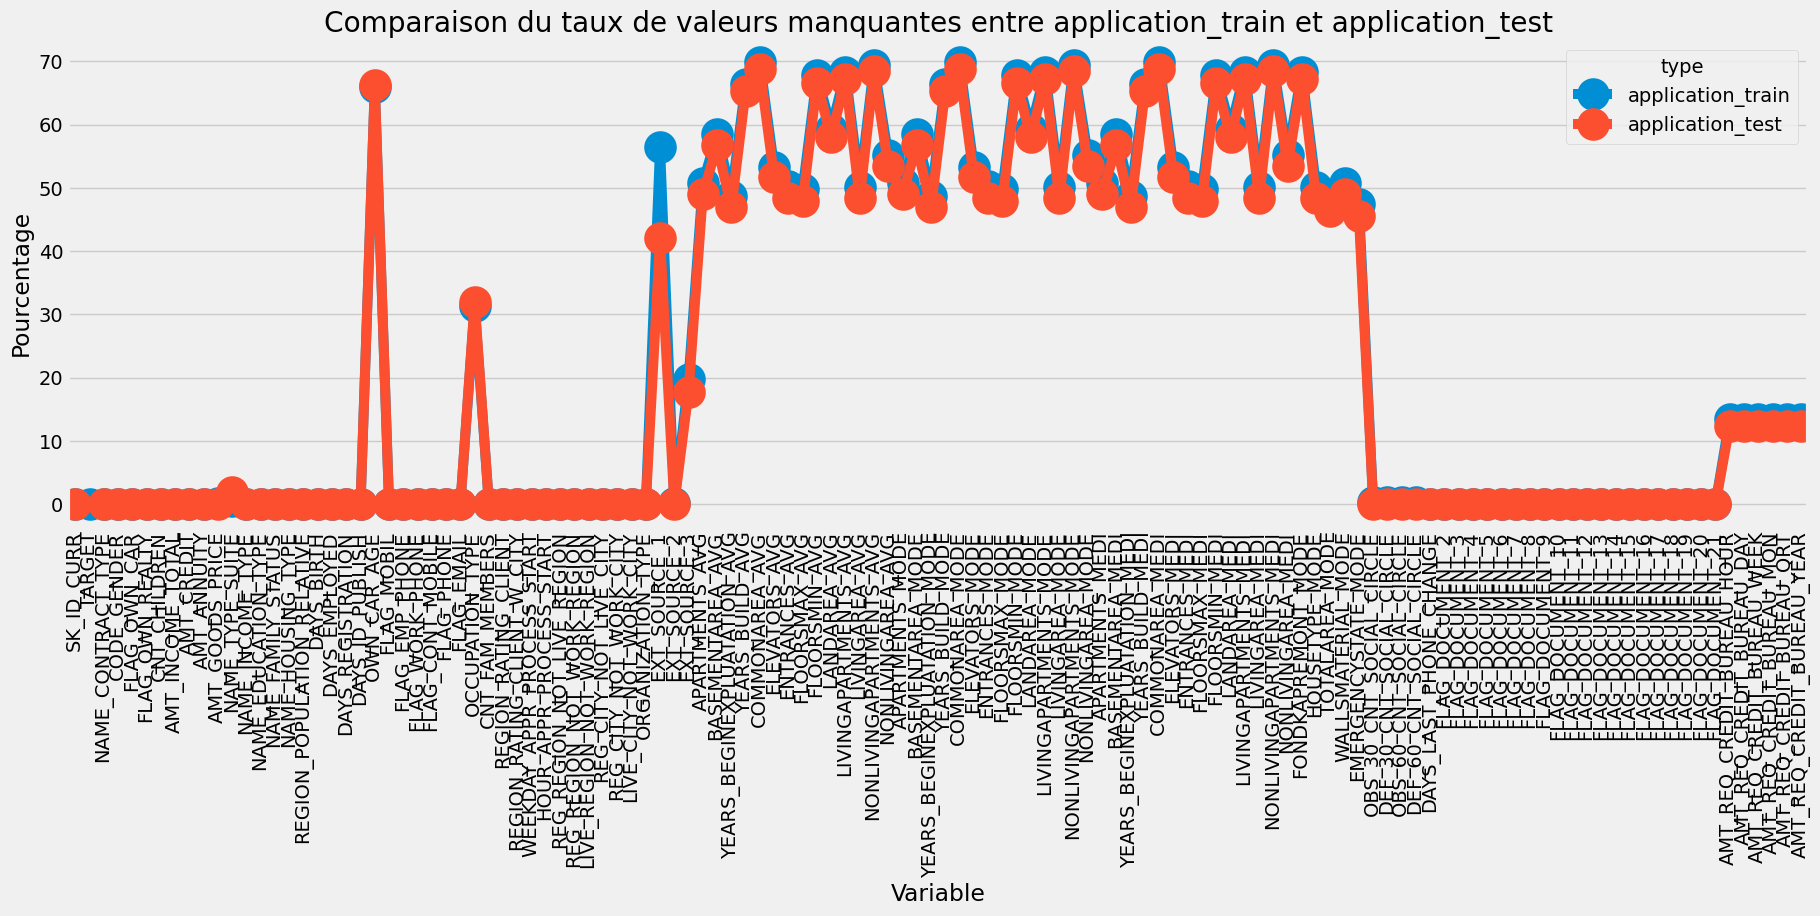

In [26]:
# df taux de valeurs manquantes de application_train :
miss_train = (df_train.isnull().sum() / df_train.shape[0] *100).to_frame('%').reset_index()

# df taux de valeurs manquantes de application_test :
miss_test = (df_test.isnull().sum() / df_test.shape[0] *100).to_frame('%').reset_index()

# df commun : 
miss_train['type'] = 'application_train'
miss_test['type'] = 'application_test'
missing = pd.concat([miss_train, miss_test], axis=0)

# représentation graphique : 
plt.figure(figsize=(20,6))

sns.pointplot(
    data=missing,
    x='index',
    y='%',
    hue='type', 
)

plt.xticks(rotation=90)
plt.xlabel('Variable')
plt.ylabel('Pourcentage')
plt.title('Comparaison du taux de valeurs manquantes entre application_train et application_test')

plt.show()

del miss_test, miss_train, missing

## 2.3- Bureau

In [27]:
df_bureau = pd.read_csv('bureau.csv')
df_bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [28]:
df_bureau.dtypes.value_counts()

float64    8
int64      6
object     3
Name: count, dtype: int64

In [29]:
print(df_bureau.shape)
print("Le nombre de doublons dans df est de : ", df_bureau[df_bureau.duplicated()].shape[0])
df_bureau.describe()

(1716428, 17)
Le nombre de doublons dans df est de :  0


SK_ID_CURR  SK_ID_BUREAU   DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
count  1.716428e+06  1.716428e+06  1.716428e+06        1.716428e+06   
mean   2.782149e+05  5.924434e+06 -1.142108e+03        8.181666e-01   
std    1.029386e+05  5.322657e+05  7.951649e+02        3.654443e+01   
min    1.000010e+05  5.000000e+06 -2.922000e+03        0.000000e+00   
25%    1.888668e+05  5.463954e+06 -1.666000e+03        0.000000e+00   
50%    2.780550e+05  5.926304e+06 -9.870000e+02        0.000000e+00   
75%    3.674260e+05  6.385681e+06 -4.740000e+02        0.000000e+00   
max    4.562550e+05  6.843457e+06  0.000000e+00        2.792000e+03   

       DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
count         1.610875e+06       1.082775e+06            5.919400e+05   
mean          5.105174e+02      -1.017437e+03            3.825418e+03   
std           4.994220e+03       7.140106e+02            2.060316e+05   
min          -4.206000e+04      -4.202300e+04            0.000000e+00   
25%          -1.138000e+03      -1.489000e+03            0.000000e+00   
50%          -3.300000e+02      -8.970000e+02            0.000000e+00   
75%           4.740000e+02      -4.250000e+02            0.000000e+00   
max           3.119900e+04       0.000000e+00            1.159872e+08   

       CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
count        1.716428e+06    1.716415e+06         1.458759e+06   
mean         6.410406e-03    3.549946e+05         1.370851e+05   
std          9.622391e-02    1.149811e+06         6.774011e+05   
min          0.000000e+00    0.000000e+00        -4.705600e+06   
25%          0.000000e+00    5.130000e+04         0.000000e+00   
50%          0.000000e+00    1.255185e+05         0.000000e+00   
75%          0.000000e+00    3.150000e+05         4.015350e+04   
max          9.000000e+00    5.850000e+08         1.701000e+08   

       AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  \
count          1.124648e+06            1.716428e+06        1.716428e+06   
mean           6.229515e+03            3.791276e+01       -5.937483e+02   
std            4.503203e+04            5.937650e+03        7.207473e+02   
min           -5.864061e+05            0.000000e+00       -4.194700e+04   
25%            0.000000e+00            0.000000e+00       -9.080000e+02   
50%            0.000000e+00            0.000000e+00       -3.950000e+02   
75%            0.000000e+00            0.000000e+00       -3.300000e+01   
max            4.705600e+06            3.756681e+06        3.720000e+02   

        AMT_ANNUITY  
count  4.896370e+05  
mean   1.571276e+04  
std    3.258269e+05  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    1.350000e+04  
max    1.184534e+08

<Axes: >

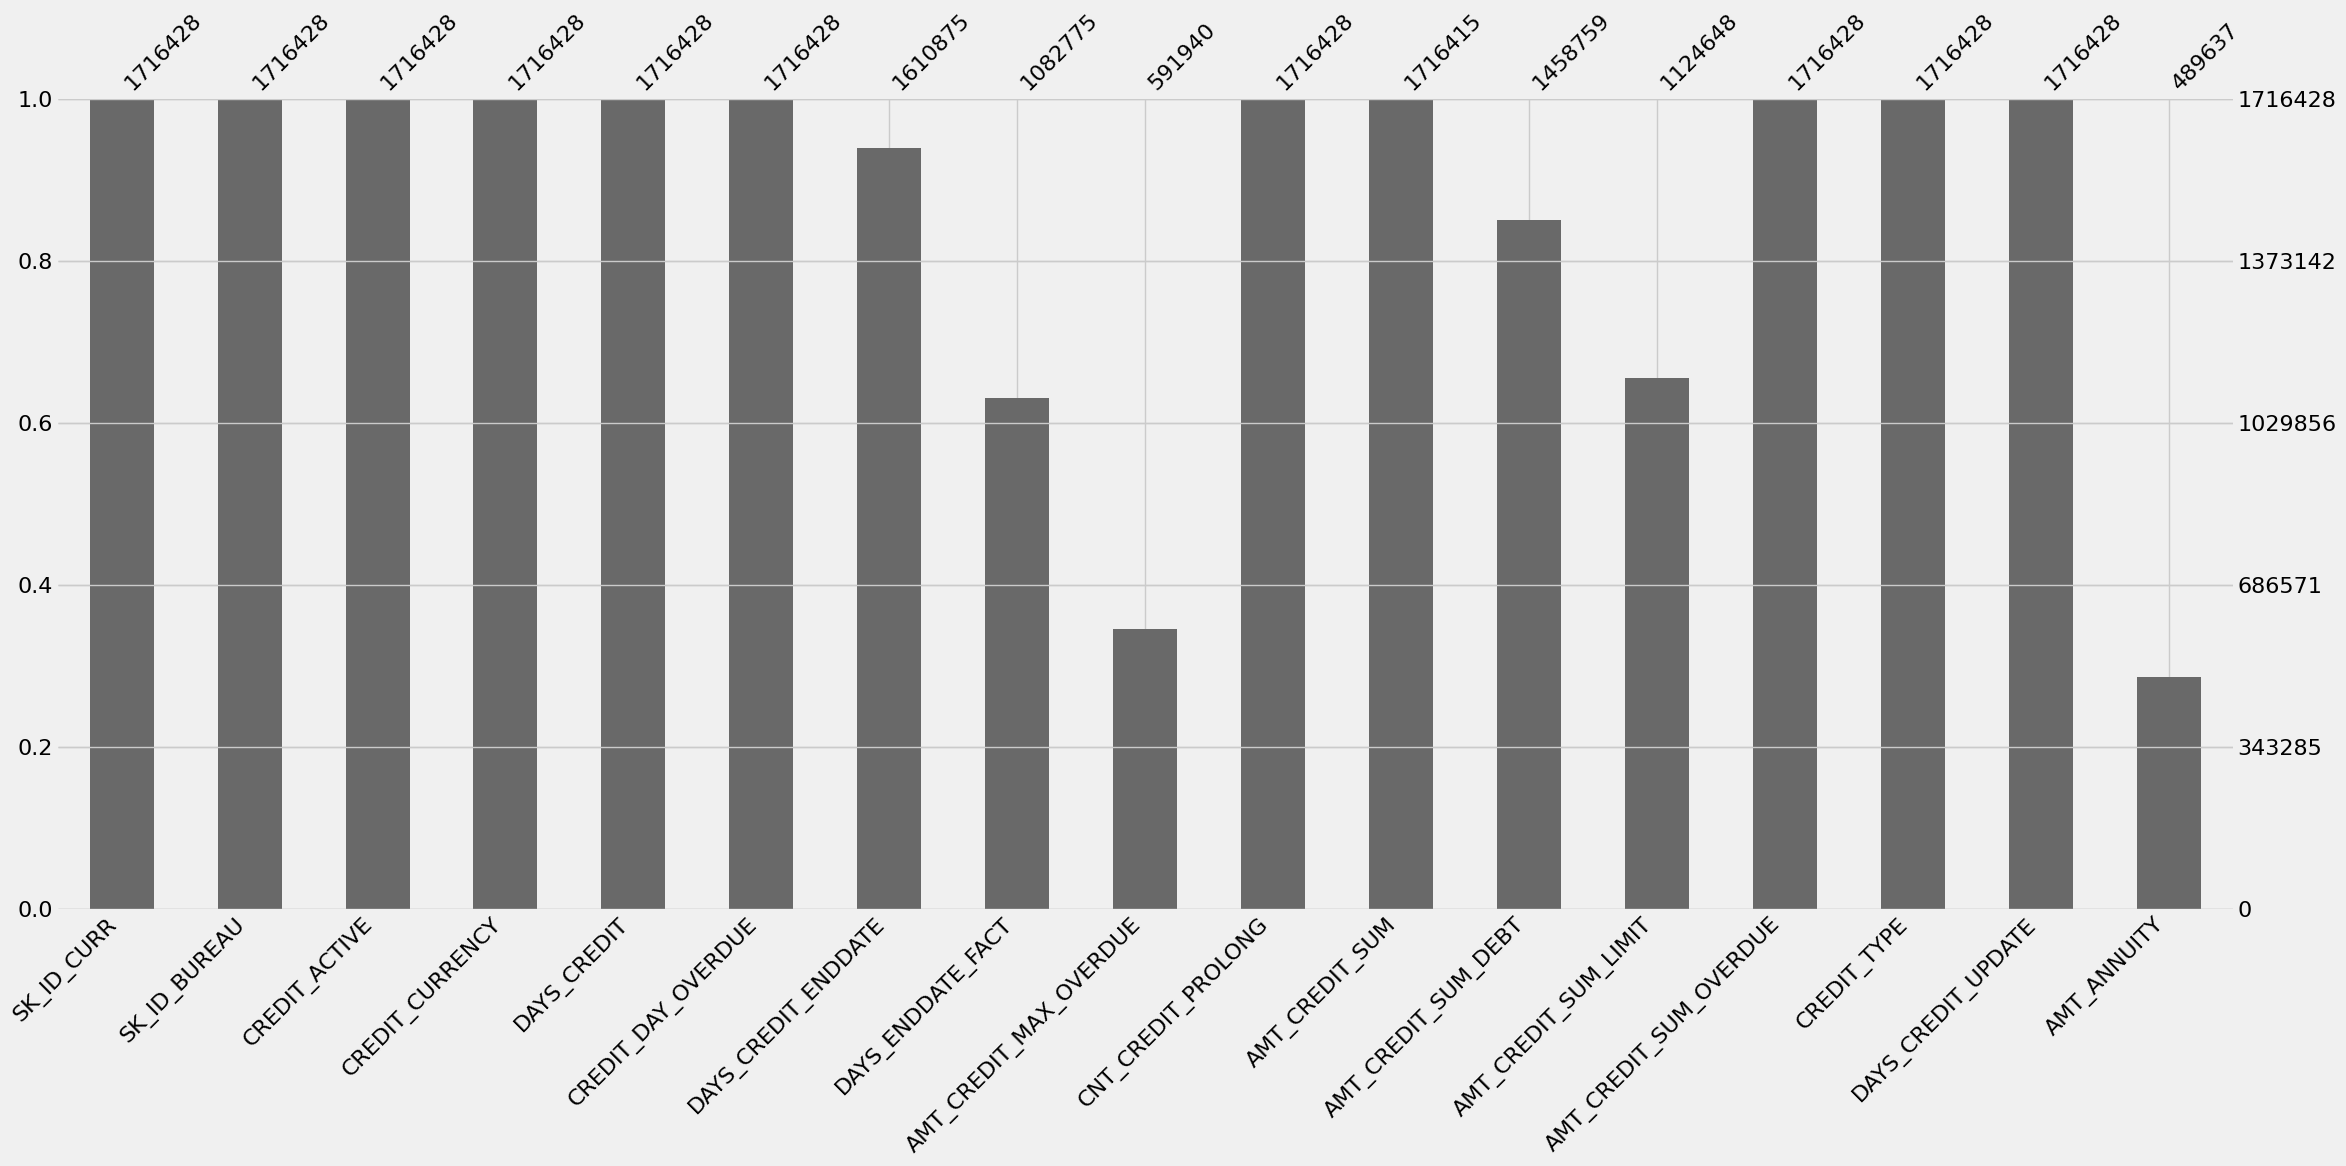

In [30]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
msno.bar(df_bureau)

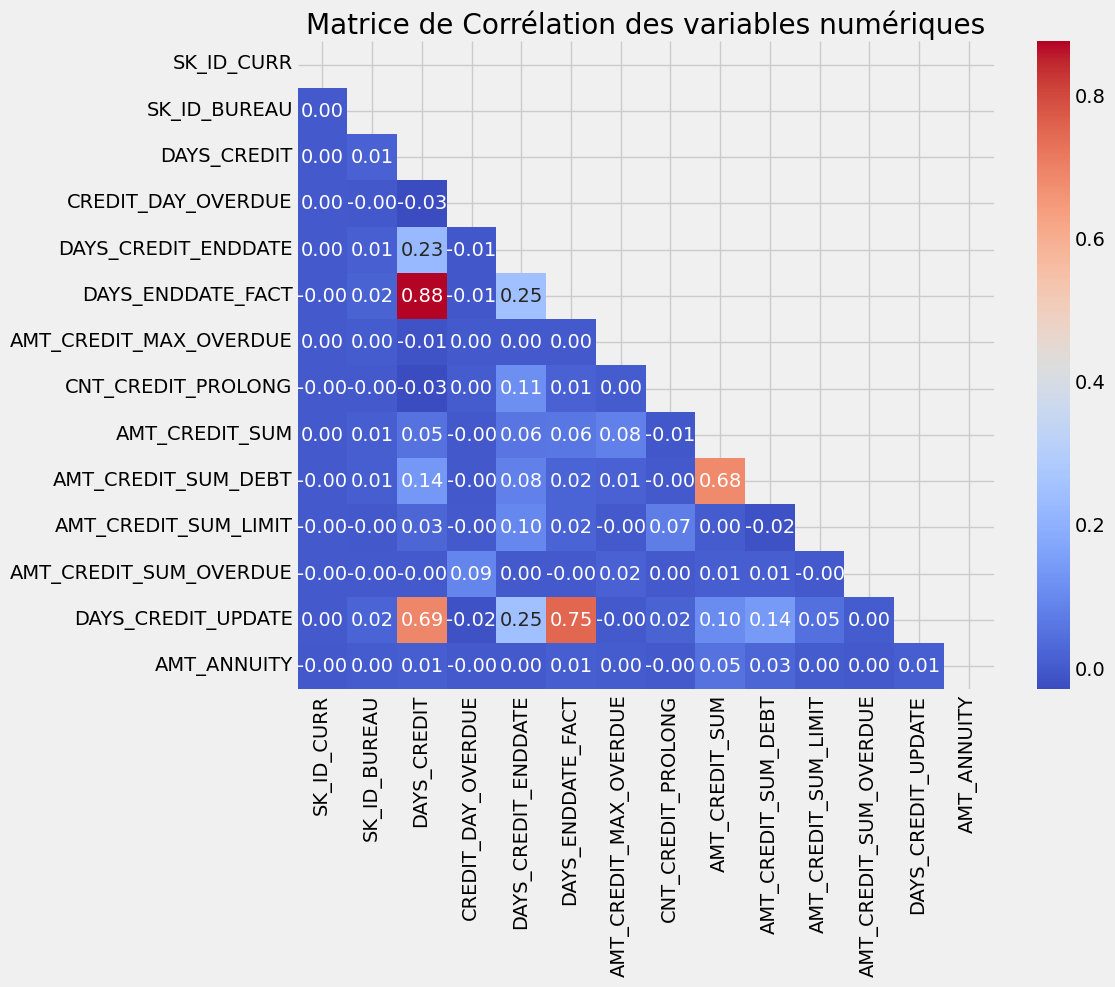

In [31]:
#Matrice de corrélation
colonnes_quanti_bureau = df_bureau.select_dtypes(include=['float64',  'int64']).columns
fc.correlation_matrix(df_bureau, var_num=colonnes_quanti_bureau, figsize=(10,8))

## 2.4- Bureau_balance

In [32]:
df_bureau_balance = pd.read_csv('bureau_balance.csv')
df_bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [33]:
df_bureau_balance.dtypes.value_counts()

int64     2
object    1
Name: count, dtype: int64

In [34]:
print(df_bureau_balance.shape)
print("Le nombre de doublons dans df est de : ", df_bureau_balance[df_bureau_balance.duplicated()].shape[0])
df_bureau_balance.describe()

(27299925, 3)
Le nombre de doublons dans df est de :  0


SK_ID_BUREAU  MONTHS_BALANCE
count  2.729992e+07    2.729992e+07
mean   6.036297e+06   -3.074169e+01
std    4.923489e+05    2.386451e+01
min    5.001709e+06   -9.600000e+01
25%    5.730933e+06   -4.600000e+01
50%    6.070821e+06   -2.500000e+01
75%    6.431951e+06   -1.100000e+01
max    6.842888e+06    0.000000e+00

<Axes: >

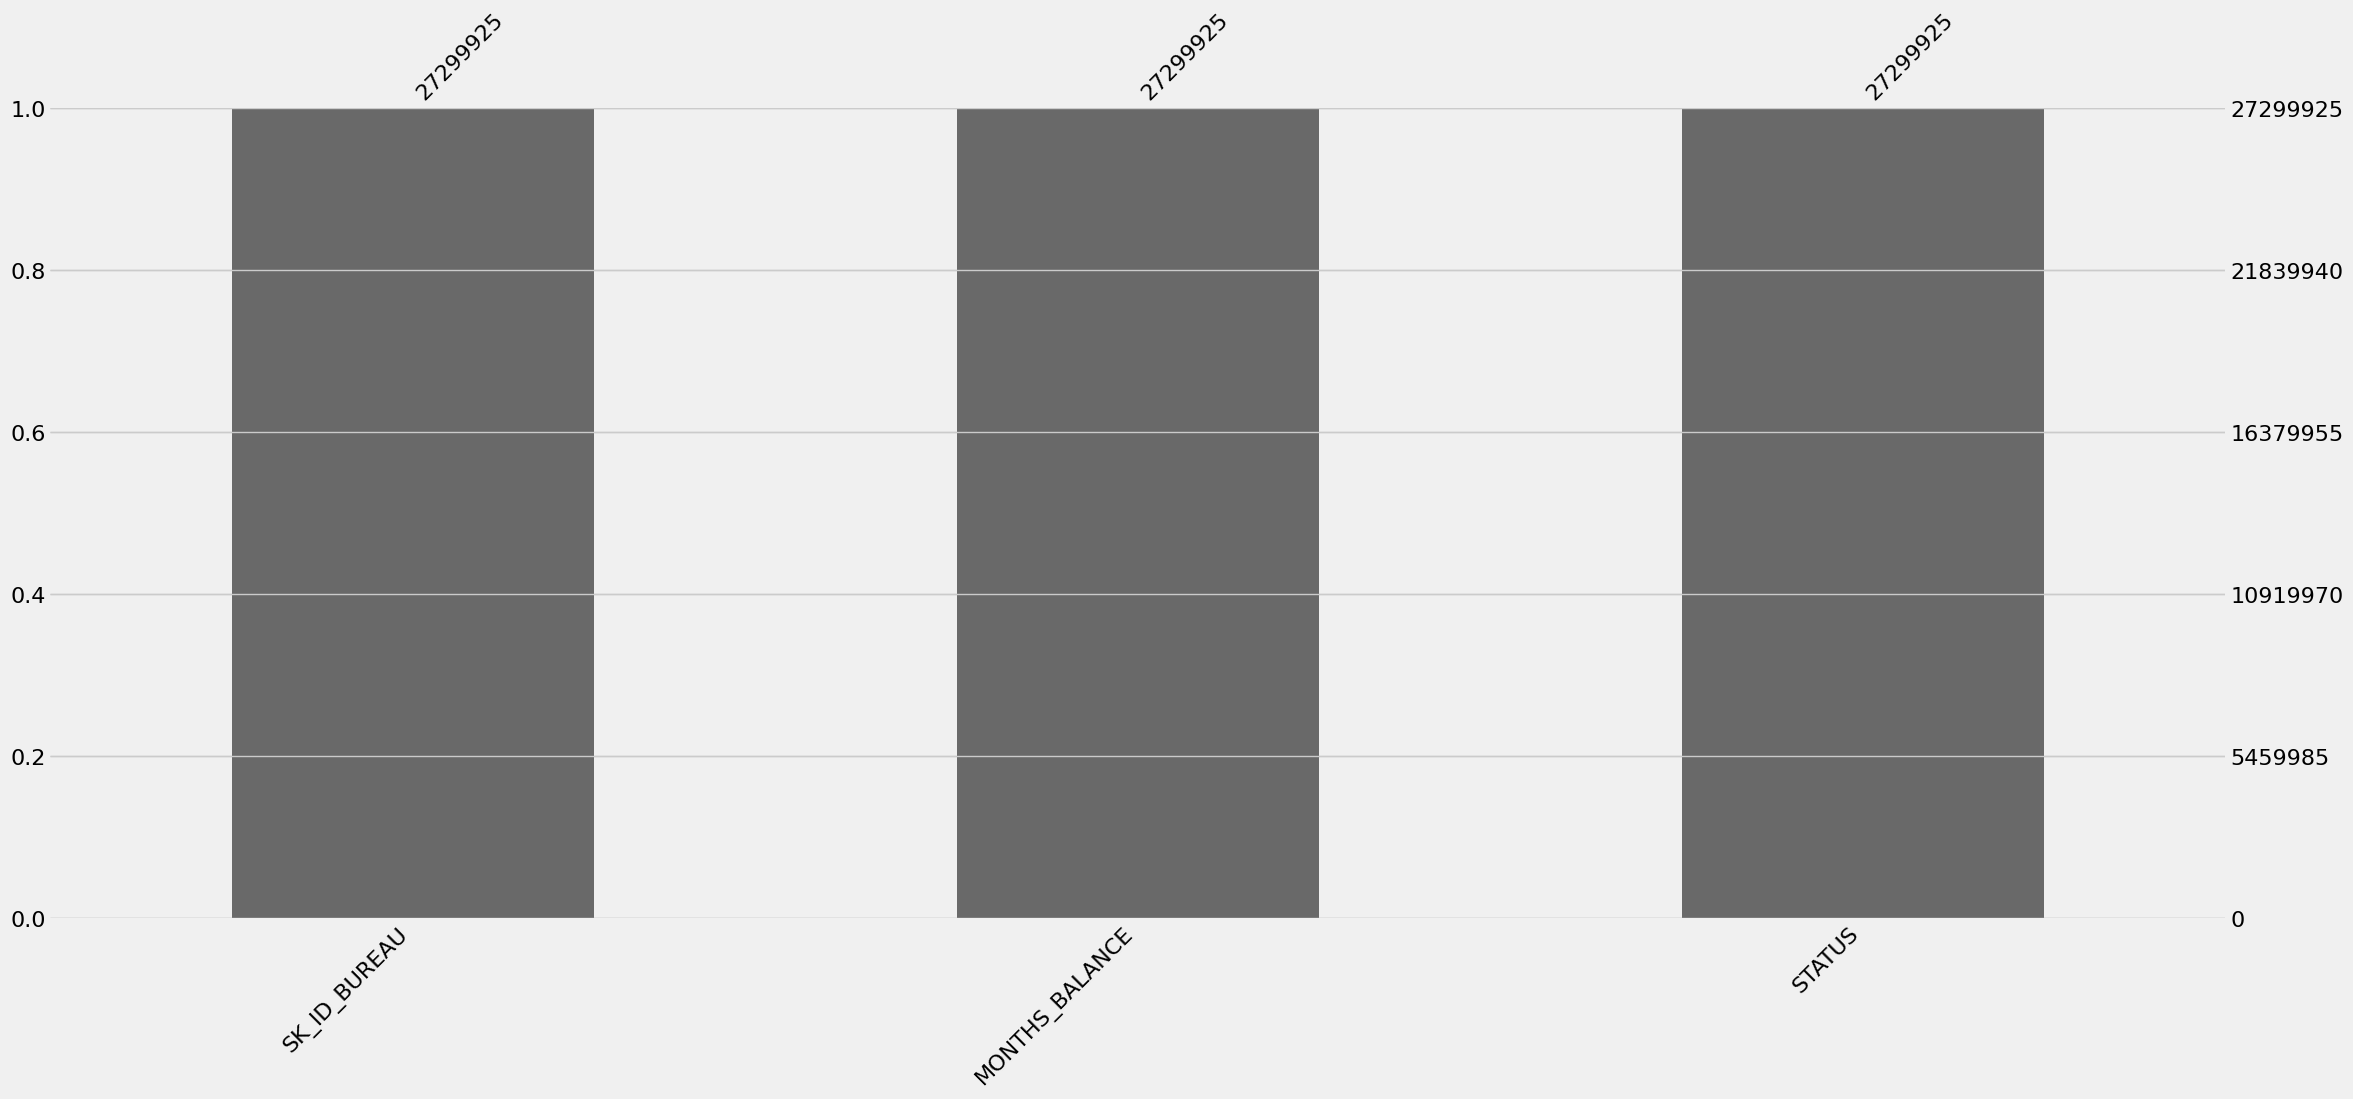

In [35]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
msno.bar(df_bureau_balance)

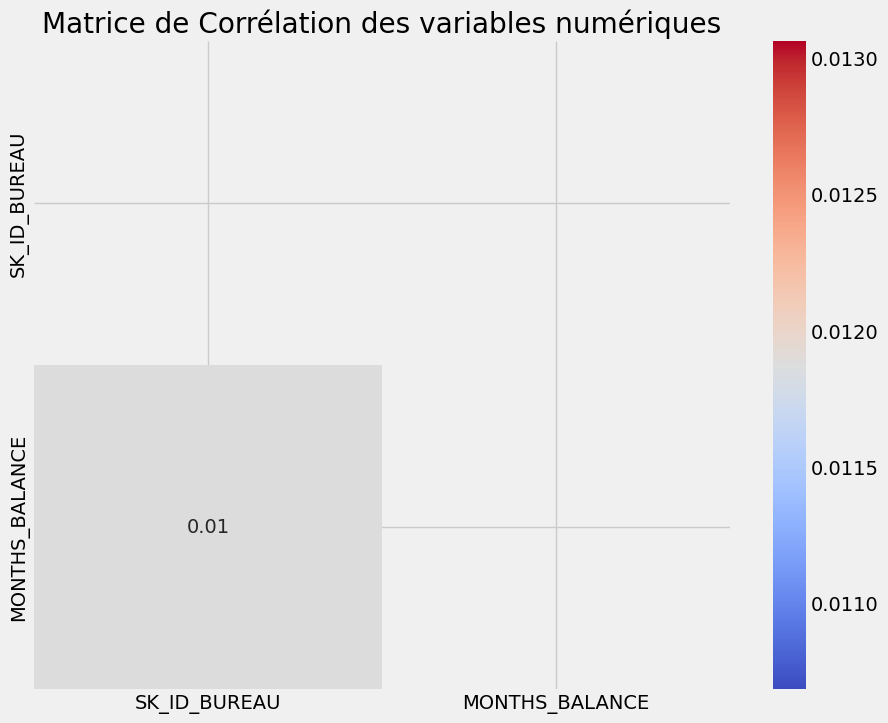

In [36]:
#Matrice de corrélation
colonnes_quanti_bureau_balance = df_bureau_balance.select_dtypes(include=['float64',  'int64']).columns
fc.correlation_matrix(df_bureau_balance, var_num=colonnes_quanti_bureau_balance, figsize=(10,8))

## 2.5- Credit_card_balance

In [37]:
df_card = pd.read_csv('credit_card_balance.csv')
df_card.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [38]:
df_card.dtypes.value_counts()

float64    15
int64       7
object      1
Name: count, dtype: int64

In [39]:
print(df_card.shape)
print("Le nombre de doublons dans df est de : ", df_card[df_card.duplicated()].shape[0])
df_card.describe()

(3840312, 23)
Le nombre de doublons dans df est de :  0


SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE   AMT_BALANCE  \
count  3.840312e+06  3.840312e+06    3.840312e+06  3.840312e+06   
mean   1.904504e+06  2.783242e+05   -3.452192e+01  5.830016e+04   
std    5.364695e+05  1.027045e+05    2.666775e+01  1.063070e+05   
min    1.000018e+06  1.000060e+05   -9.600000e+01 -4.202502e+05   
25%    1.434385e+06  1.895170e+05   -5.500000e+01  0.000000e+00   
50%    1.897122e+06  2.783960e+05   -2.800000e+01  0.000000e+00   
75%    2.369328e+06  3.675800e+05   -1.100000e+01  8.904669e+04   
max    2.843496e+06  4.562500e+05   -1.000000e+00  1.505902e+06   

       AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
count             3.840312e+06              3.090496e+06   
mean              1.538080e+05              5.961325e+03   
std               1.651457e+05              2.822569e+04   
min               0.000000e+00             -6.827310e+03   
25%               4.500000e+04              0.000000e+00   
50%               1.125000e+05              0.000000e+00   
75%               1.800000e+05              0.000000e+00   
max               1.350000e+06              2.115000e+06   

       AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
count          3.840312e+06                3.090496e+06   
mean           7.433388e+03                2.881696e+02   
std            3.384608e+04                8.201989e+03   
min           -6.211620e+03                0.000000e+00   
25%            0.000000e+00                0.000000e+00   
50%            0.000000e+00                0.000000e+00   
75%            0.000000e+00                0.000000e+00   
max            2.287098e+06                1.529847e+06   

       AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  \
count              3.090496e+06             3.535076e+06  ...   
mean               2.968805e+03             3.540204e+03  ...   
std                2.079689e+04             5.600154e+03  ...   
min                0.000000e+00             0.000000e+00  ...   
25%                0.000000e+00             0.000000e+00  ...   
50%                0.000000e+00             0.000000e+00  ...   
75%                0.000000e+00             6.633911e+03  ...   
max                2.239274e+06             2.028820e+05  ...   

       AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
count              3.840312e+06   3.840312e+06          3.840312e+06   
mean               5.596588e+04   5.808881e+04          5.809829e+04   
std                1.025336e+05   1.059654e+05          1.059718e+05   
min               -4.233058e+05  -4.202502e+05         -4.202502e+05   
25%                0.000000e+00   0.000000e+00          0.000000e+00   
50%                0.000000e+00   0.000000e+00          0.000000e+00   
75%                8.535924e+04   8.889949e+04          8.891451e+04   
max                1.472317e+06   1.493338e+06          1.493338e+06   

       CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count              3.090496e+06          3.840312e+06   
mean               3.094490e-01          7.031439e-01   
std                1.100401e+00          3.190347e+00   
min                0.000000e+00          0.000000e+00   
25%                0.000000e+00          0.000000e+00   
50%                0.000000e+00          0.000000e+00   
75%                0.000000e+00          0.000000e+00   
max                5.100000e+01          1.650000e+02   

       CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
count                3.090496e+06              3.090496e+06   
mean                 4.812496e-03              5.594791e-01   
std                  8.263861e-02              3.240649e+00   
min                  0.000000e+00              0.000000e+00   
25%                  0.000000e+00              0.000000e+00   
50%                  0.000000e+00              0.000000e+00   
75%                  0.000000e+00              0.000000e+00   
max                  1.200000e+01              1.650000e+02   

       CNT_INST

<Axes: >

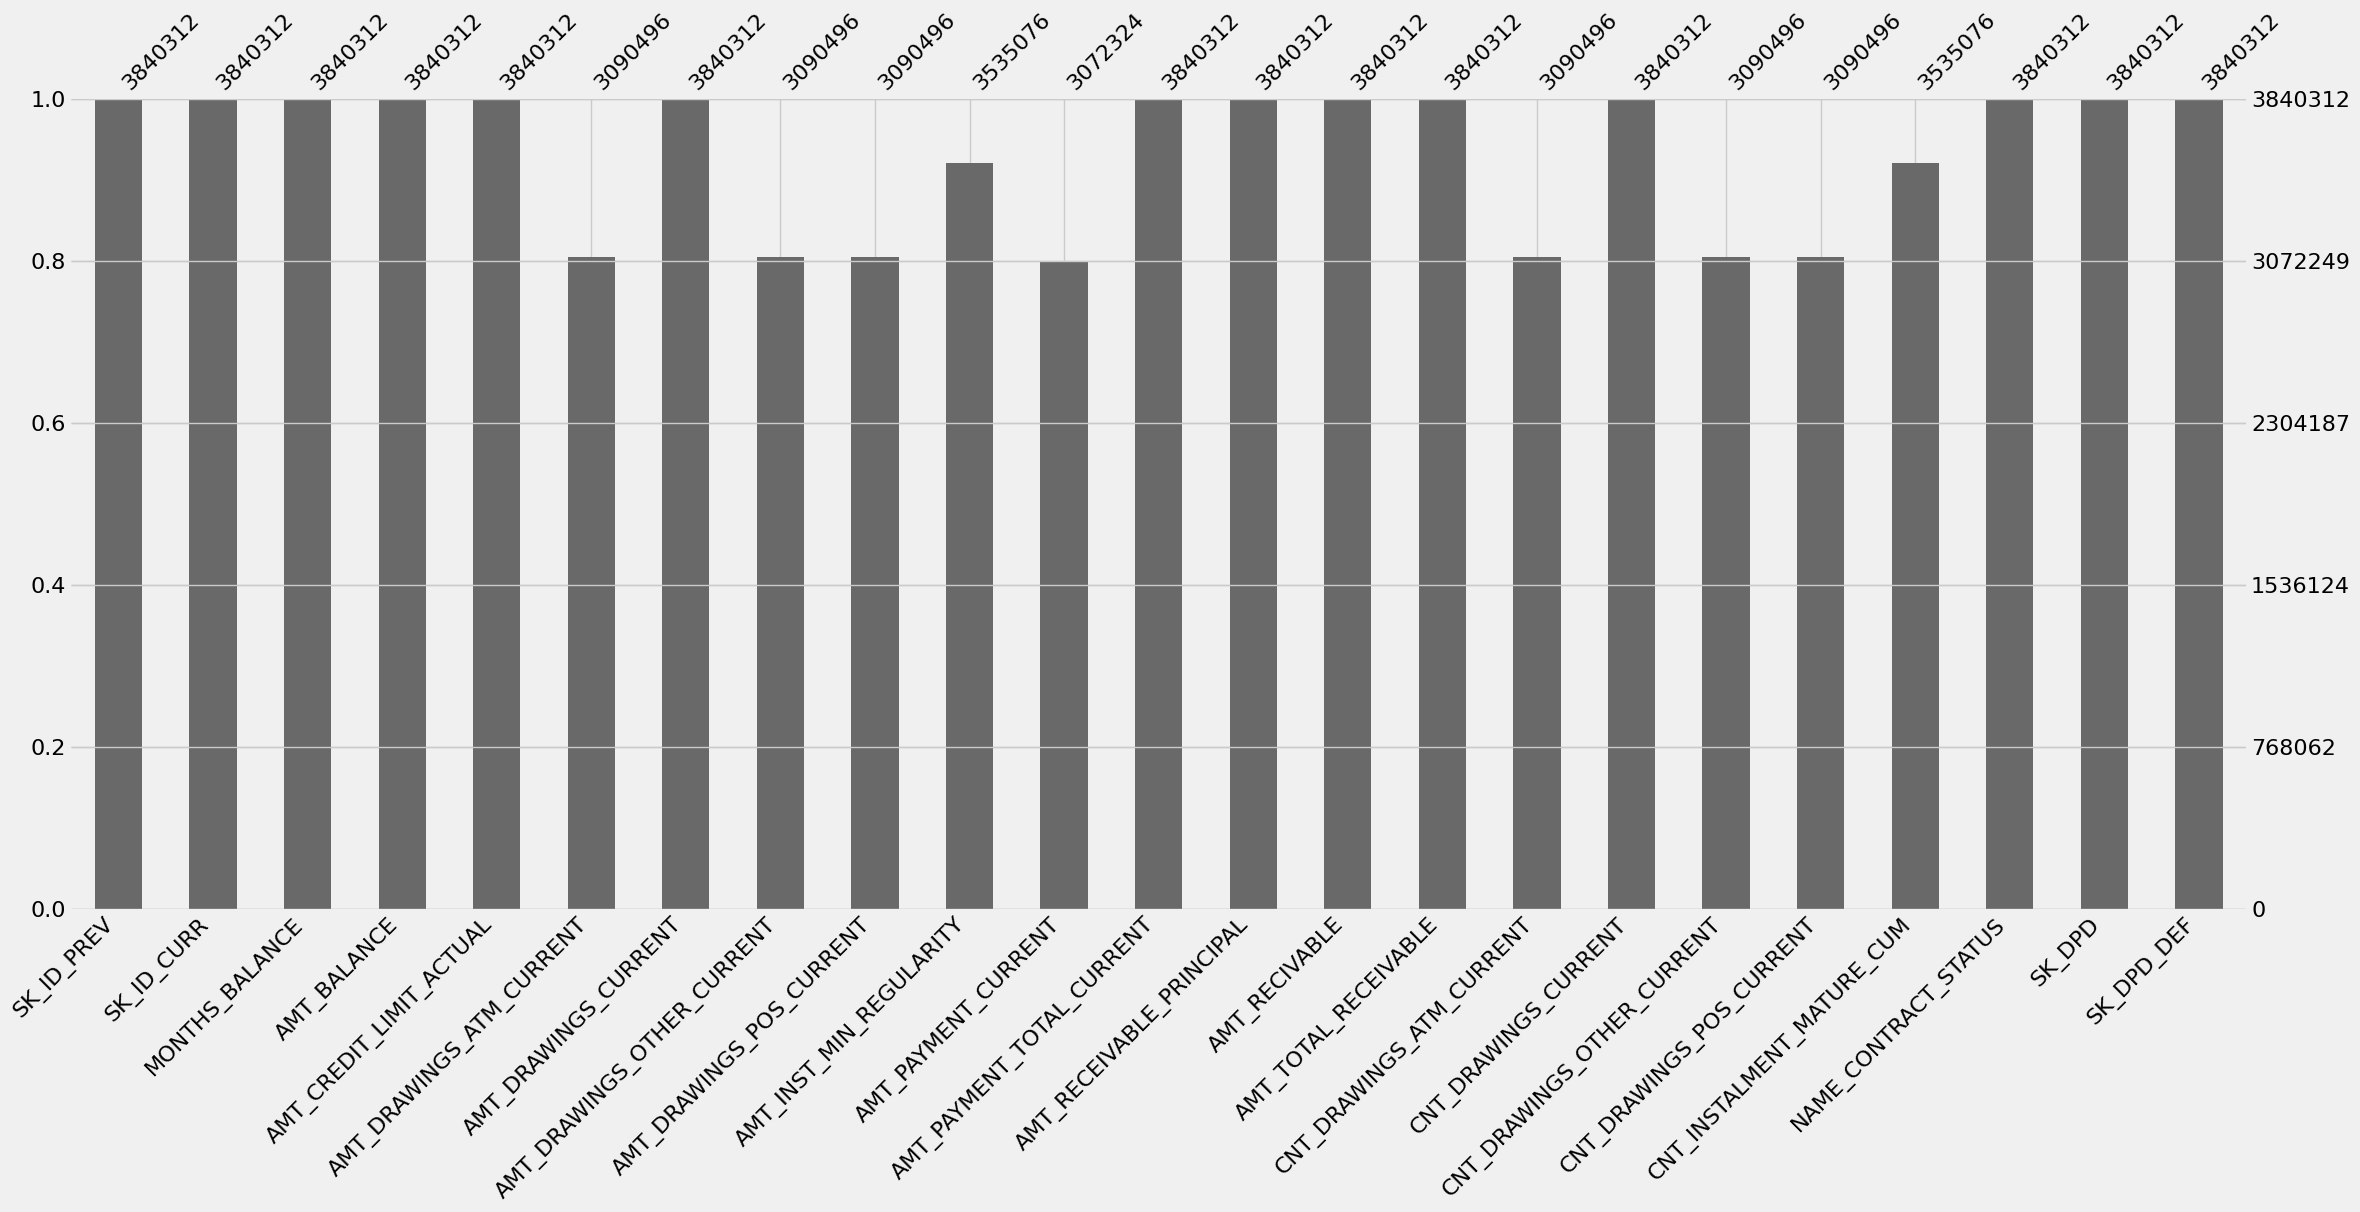

In [40]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
msno.bar(df_card)

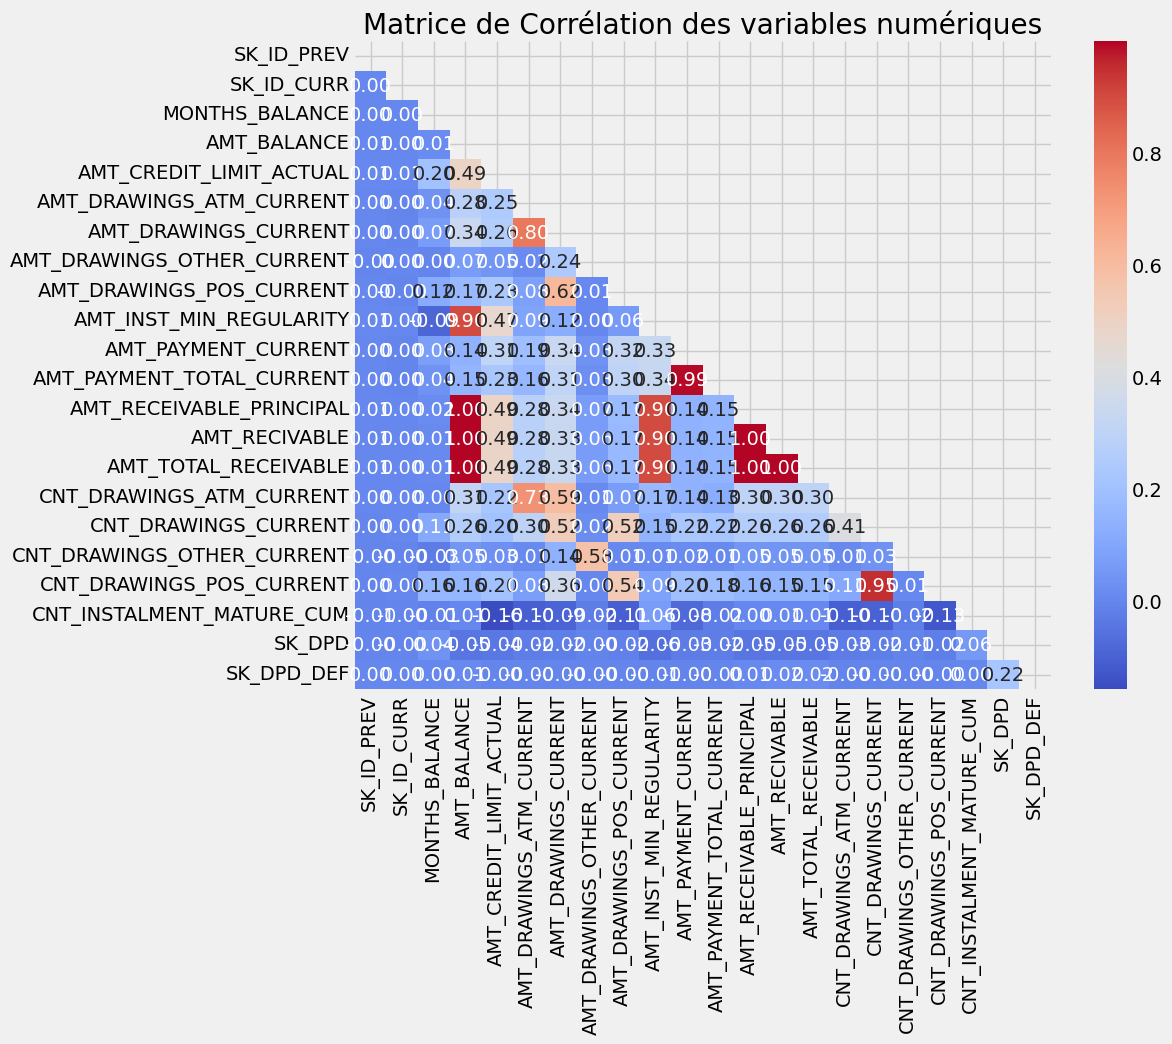

In [41]:
#Matrice de corrélation
colonnes_quanti_card = df_card.select_dtypes(include=['float64',  'int64']).columns
fc.correlation_matrix(df_card, var_num=colonnes_quanti_card, figsize=(10,8))

## 2.6- Installment_payments

In [42]:
df_payment = pd.read_csv('installments_payments.csv')
df_payment.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [43]:
df_payment.dtypes.value_counts()

float64    5
int64      3
Name: count, dtype: int64

In [44]:
print(df_payment.shape)
print("Le nombre de doublons dans df est de : ", df_payment[df_payment.duplicated()].shape[0])
df_payment.describe()

(13605401, 8)
Le nombre de doublons dans df est de :  0


SK_ID_PREV    SK_ID_CURR  NUM_INSTALMENT_VERSION  \
count  1.360540e+07  1.360540e+07            1.360540e+07   
mean   1.903365e+06  2.784449e+05            8.566373e-01   
std    5.362029e+05  1.027183e+05            1.035216e+00   
min    1.000001e+06  1.000010e+05            0.000000e+00   
25%    1.434191e+06  1.896390e+05            0.000000e+00   
50%    1.896520e+06  2.786850e+05            1.000000e+00   
75%    2.369094e+06  3.675300e+05            1.000000e+00   
max    2.843499e+06  4.562550e+05            1.780000e+02   

       NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
count           1.360540e+07     1.360540e+07        1.360250e+07   
mean            1.887090e+01    -1.042270e+03       -1.051114e+03   
std             2.666407e+01     8.009463e+02        8.005859e+02   
min             1.000000e+00    -2.922000e+03       -4.921000e+03   
25%             4.000000e+00    -1.654000e+03       -1.662000e+03   
50%             8.000000e+00    -8.180000e+02       -8.270000e+02   
75%             1.900000e+01    -3.610000e+02       -3.700000e+02   
max             2.770000e+02    -1.000000e+00       -1.000000e+00   

       AMT_INSTALMENT   AMT_PAYMENT  
count    1.360540e+07  1.360250e+07  
mean     1.705091e+04  1.723822e+04  
std      5.057025e+04  5.473578e+04  
min      0.000000e+00  0.000000e+00  
25%      4.226085e+03  3.398265e+03  
50%      8.884080e+03  8.125515e+03  
75%      1.671021e+04  1.610842e+04  
max      3.771488e+06  3.771488e+06

<Axes: >

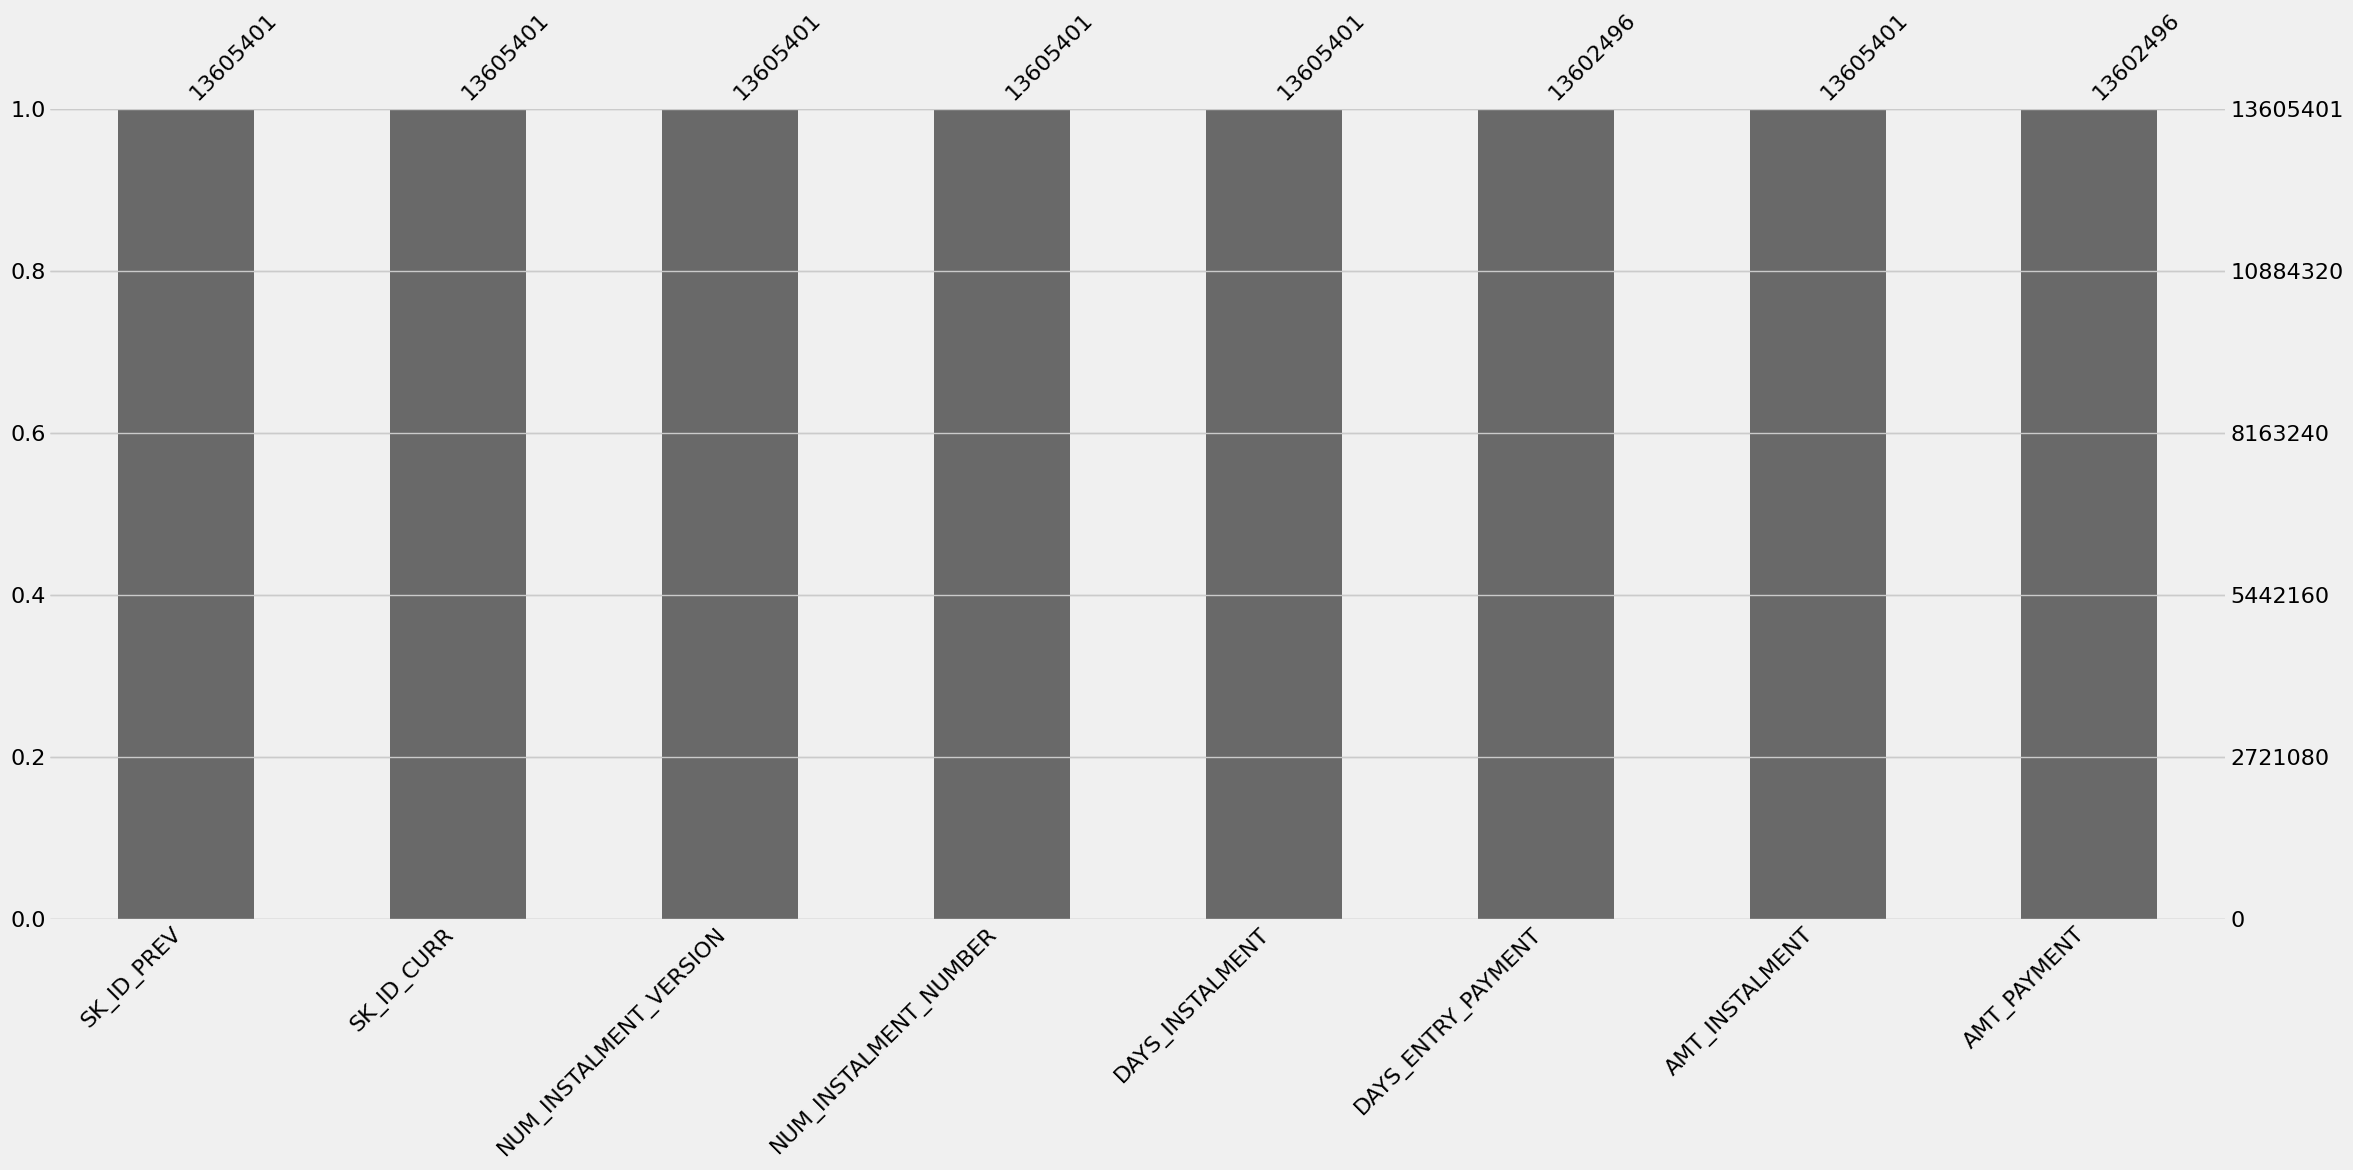

In [45]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
msno.bar(df_payment)

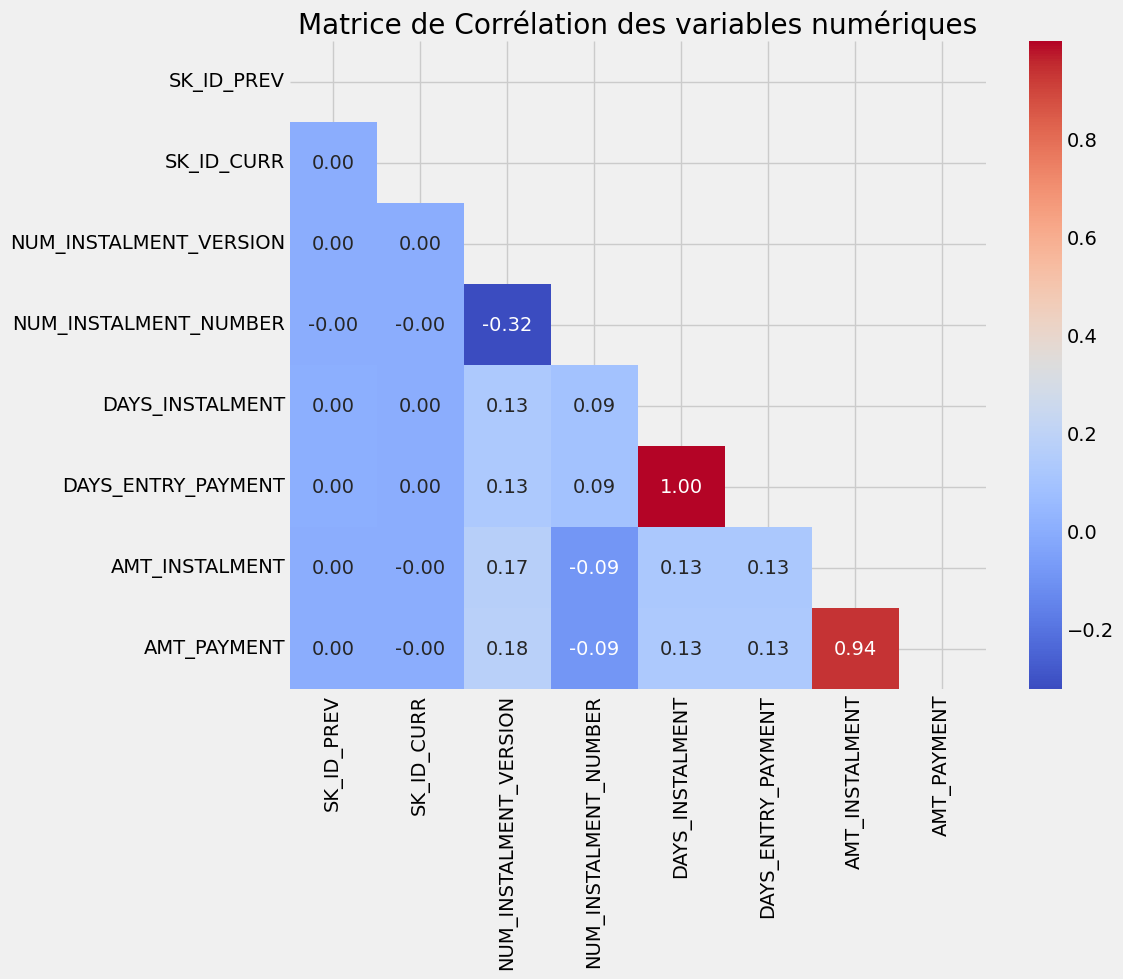

In [46]:
#Matrice de corrélation
colonnes_quanti_payment = df_payment.select_dtypes(include=['float64',  'int64']).columns
fc.correlation_matrix(df_payment, var_num=colonnes_quanti_payment, figsize=(10,8))

## 2.7- POS_cash_balance

In [47]:
df_pos = pd.read_csv('POS_CASH_balance.csv')
df_pos.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [48]:
df_pos.dtypes.value_counts()

int64      5
float64    2
object     1
Name: count, dtype: int64

In [49]:
print(df_pos.shape)
print("Le nombre de doublons dans df est de : ", df_pos[df_pos.duplicated()].shape[0])
df_pos.describe()

(10001358, 8)
Le nombre de doublons dans df est de :  0


SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
count  1.000136e+07  1.000136e+07    1.000136e+07    9.975287e+06   
mean   1.903217e+06  2.784039e+05   -3.501259e+01    1.708965e+01   
std    5.358465e+05  1.027637e+05    2.606657e+01    1.199506e+01   
min    1.000001e+06  1.000010e+05   -9.600000e+01    1.000000e+00   
25%    1.434405e+06  1.895500e+05   -5.400000e+01    1.000000e+01   
50%    1.896565e+06  2.786540e+05   -2.800000e+01    1.200000e+01   
75%    2.368963e+06  3.674290e+05   -1.300000e+01    2.400000e+01   
max    2.843499e+06  4.562550e+05   -1.000000e+00    9.200000e+01   

       CNT_INSTALMENT_FUTURE        SK_DPD    SK_DPD_DEF  
count           9.975271e+06  1.000136e+07  1.000136e+07  
mean            1.048384e+01  1.160693e+01  6.544684e-01  
std             1.110906e+01  1.327140e+02  3.276249e+01  
min             0.000000e+00  0.000000e+00  0.000000e+00  
25%             3.000000e+00  0.000000e+00  0.000000e+00  
50%             7.000000e+00  0.000000e+00  0.000000e+00  
75%             1.400000e+01  0.000000e+00  0.000000e+00  
max             8.500000e+01  4.231000e+03  3.595000e+03

<Axes: >

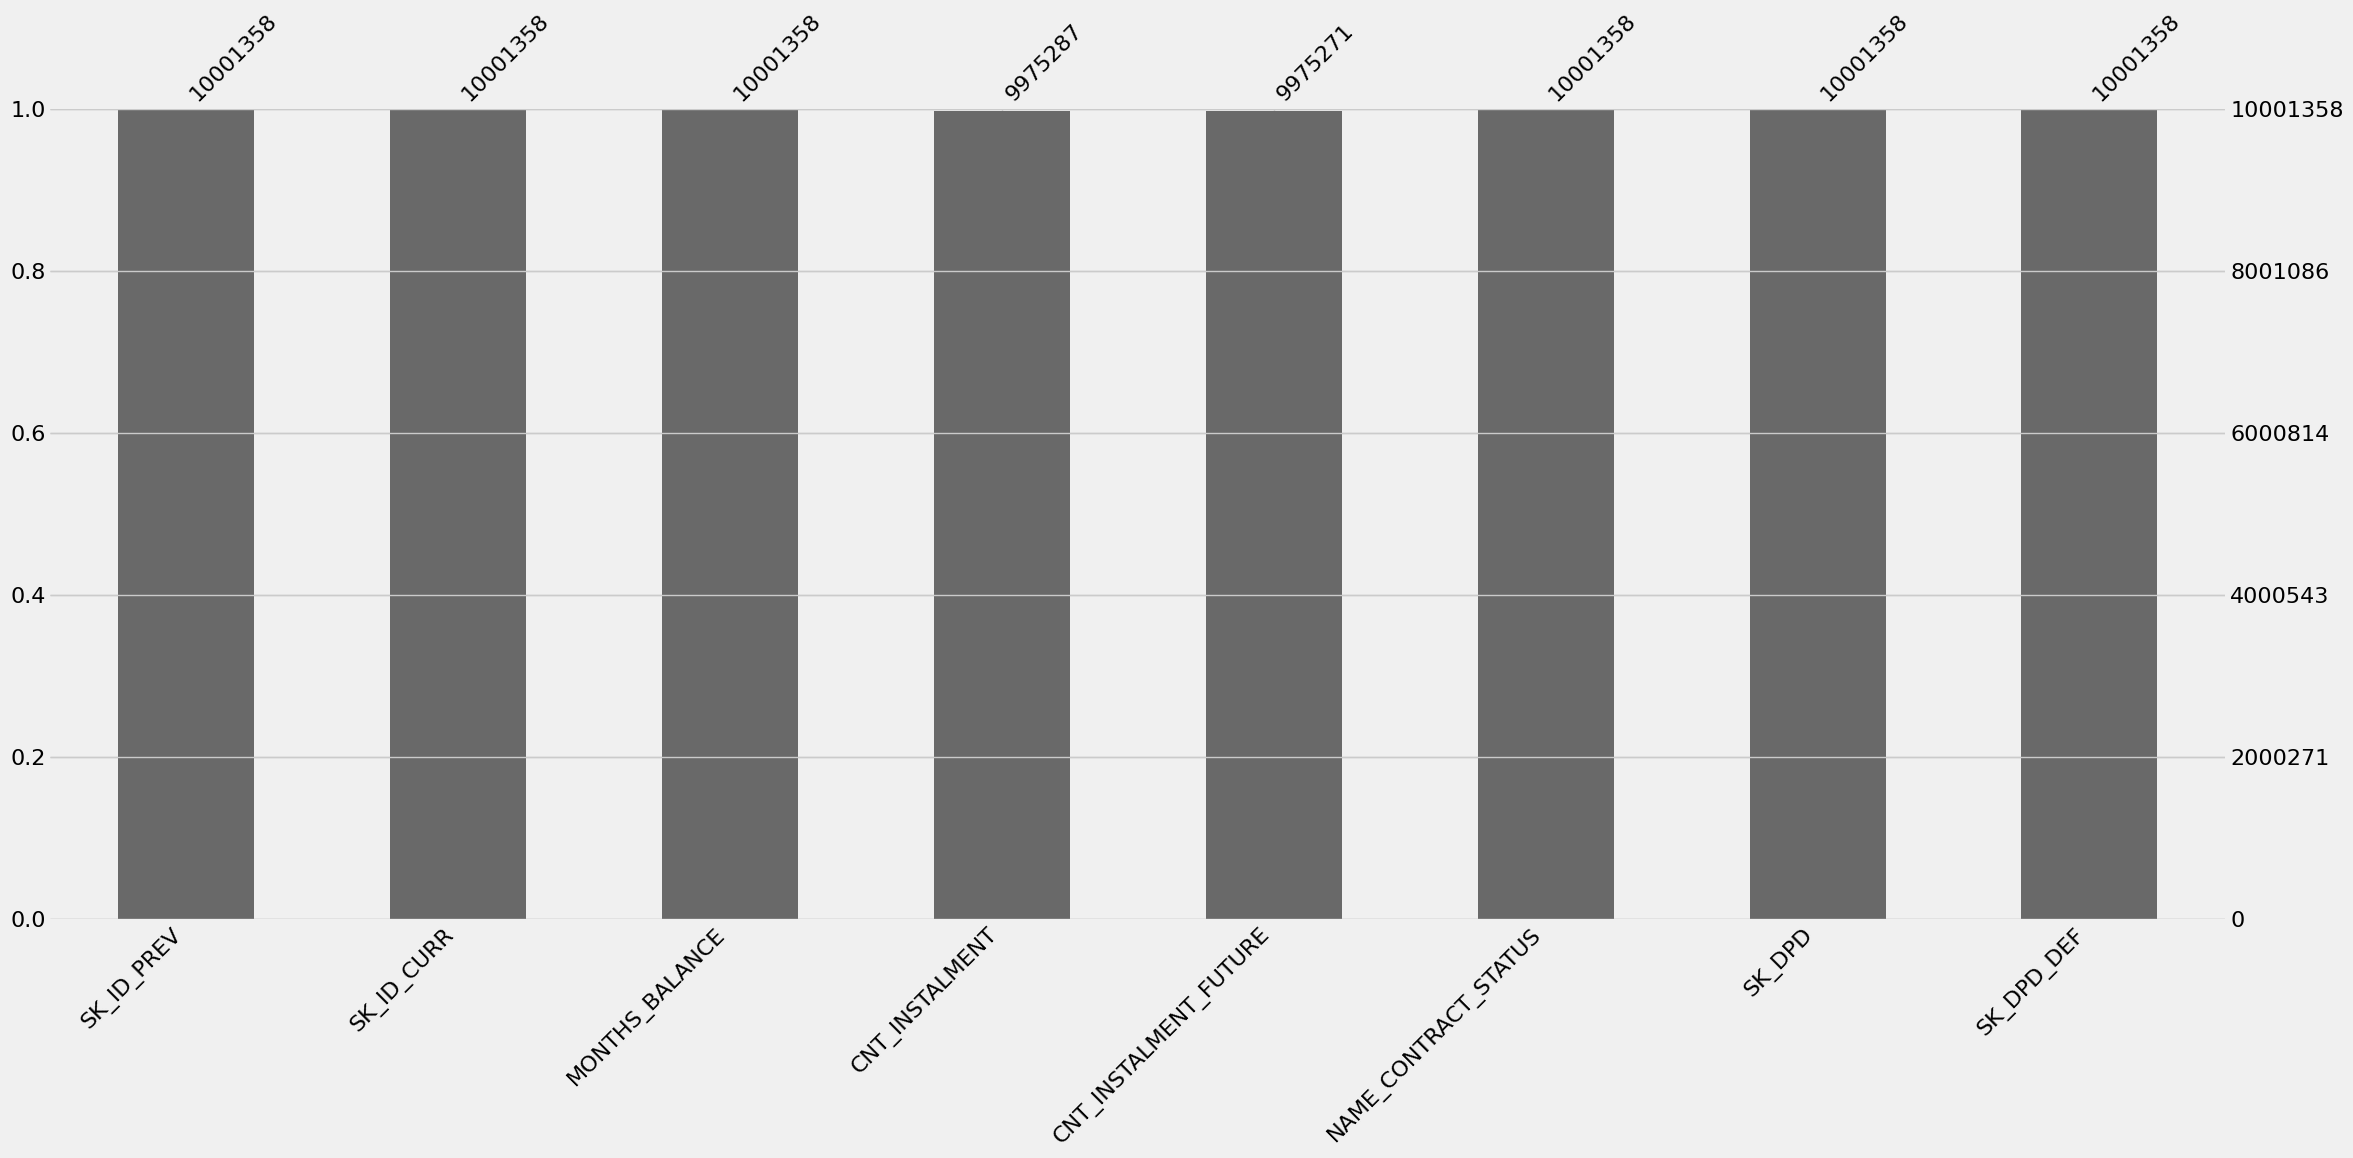

In [50]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
msno.bar(df_pos)

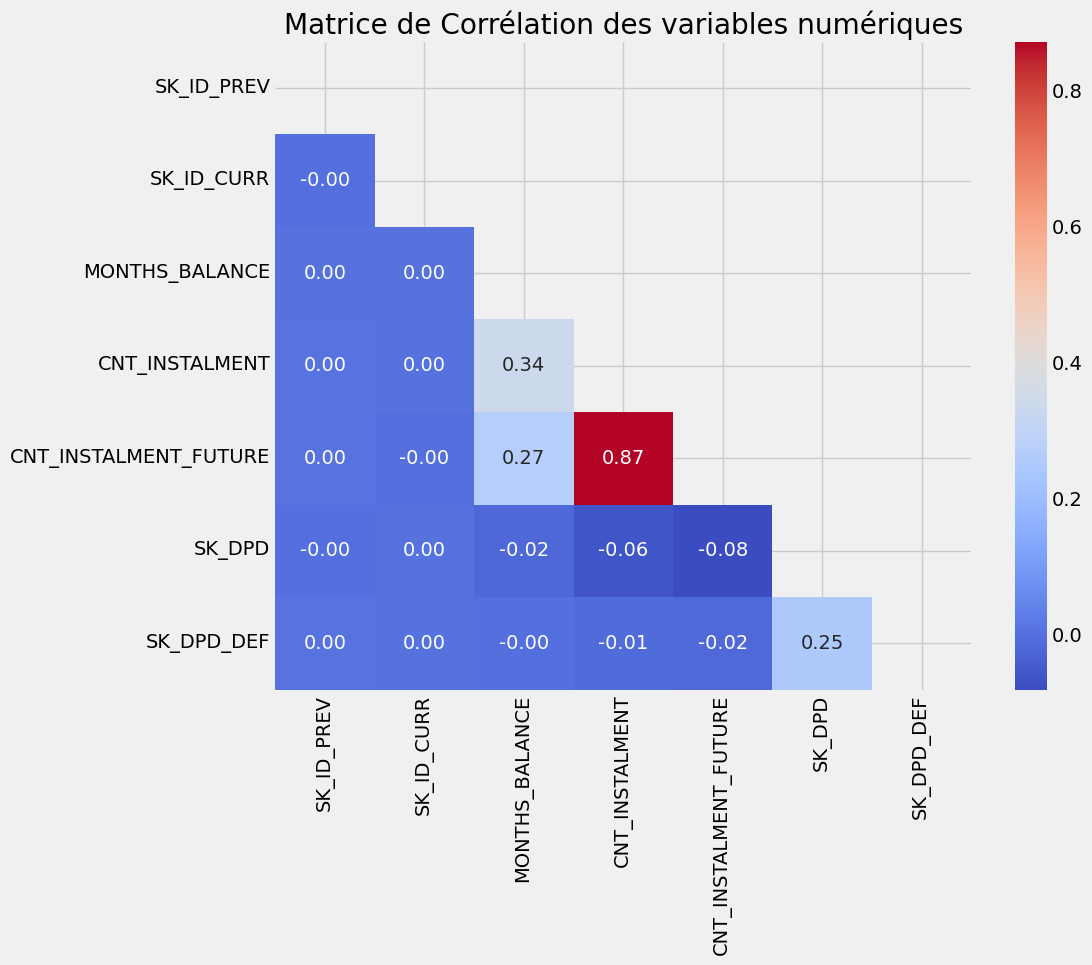

In [51]:
#Matrice de corrélation
colonnes_quanti_pos = df_pos.select_dtypes(include=['float64',  'int64']).columns
fc.correlation_matrix(df_pos, var_num=colonnes_quanti_pos, figsize=(10,8))

## 2.8- Previous_application

In [52]:
df_previous_app = pd.read_csv('previous_application.csv')
df_previous_app.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [53]:
df_previous_app.dtypes.value_counts()

object     16
float64    15
int64       6
Name: count, dtype: int64

In [54]:
print(df_previous_app.shape)
print("Le nombre de doublons dans df est de : ", df_previous_app[df_previous_app.duplicated()].shape[0])
df_card.describe()

(1670214, 37)
Le nombre de doublons dans df est de :  0


SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE   AMT_BALANCE  \
count  3.840312e+06  3.840312e+06    3.840312e+06  3.840312e+06   
mean   1.904504e+06  2.783242e+05   -3.452192e+01  5.830016e+04   
std    5.364695e+05  1.027045e+05    2.666775e+01  1.063070e+05   
min    1.000018e+06  1.000060e+05   -9.600000e+01 -4.202502e+05   
25%    1.434385e+06  1.895170e+05   -5.500000e+01  0.000000e+00   
50%    1.897122e+06  2.783960e+05   -2.800000e+01  0.000000e+00   
75%    2.369328e+06  3.675800e+05   -1.100000e+01  8.904669e+04   
max    2.843496e+06  4.562500e+05   -1.000000e+00  1.505902e+06   

       AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
count             3.840312e+06              3.090496e+06   
mean              1.538080e+05              5.961325e+03   
std               1.651457e+05              2.822569e+04   
min               0.000000e+00             -6.827310e+03   
25%               4.500000e+04              0.000000e+00   
50%               1.125000e+05              0.000000e+00   
75%               1.800000e+05              0.000000e+00   
max               1.350000e+06              2.115000e+06   

       AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
count          3.840312e+06                3.090496e+06   
mean           7.433388e+03                2.881696e+02   
std            3.384608e+04                8.201989e+03   
min           -6.211620e+03                0.000000e+00   
25%            0.000000e+00                0.000000e+00   
50%            0.000000e+00                0.000000e+00   
75%            0.000000e+00                0.000000e+00   
max            2.287098e+06                1.529847e+06   

       AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  \
count              3.090496e+06             3.535076e+06  ...   
mean               2.968805e+03             3.540204e+03  ...   
std                2.079689e+04             5.600154e+03  ...   
min                0.000000e+00             0.000000e+00  ...   
25%                0.000000e+00             0.000000e+00  ...   
50%                0.000000e+00             0.000000e+00  ...   
75%                0.000000e+00             6.633911e+03  ...   
max                2.239274e+06             2.028820e+05  ...   

       AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
count              3.840312e+06   3.840312e+06          3.840312e+06   
mean               5.596588e+04   5.808881e+04          5.809829e+04   
std                1.025336e+05   1.059654e+05          1.059718e+05   
min               -4.233058e+05  -4.202502e+05         -4.202502e+05   
25%                0.000000e+00   0.000000e+00          0.000000e+00   
50%                0.000000e+00   0.000000e+00          0.000000e+00   
75%                8.535924e+04   8.889949e+04          8.891451e+04   
max                1.472317e+06   1.493338e+06          1.493338e+06   

       CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count              3.090496e+06          3.840312e+06   
mean               3.094490e-01          7.031439e-01   
std                1.100401e+00          3.190347e+00   
min                0.000000e+00          0.000000e+00   
25%                0.000000e+00          0.000000e+00   
50%                0.000000e+00          0.000000e+00   
75%                0.000000e+00          0.000000e+00   
max                5.100000e+01          1.650000e+02   

       CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
count                3.090496e+06              3.090496e+06   
mean                 4.812496e-03              5.594791e-01   
std                  8.263861e-02              3.240649e+00   
min                  0.000000e+00              0.000000e+00   
25%                  0.000000e+00              0.000000e+00   
50%                  0.000000e+00              0.000000e+00   
75%                  0.000000e+00              0.000000e+00   
max                  1.200000e+01              1.650000e+02   

       CNT_INST

<Axes: >

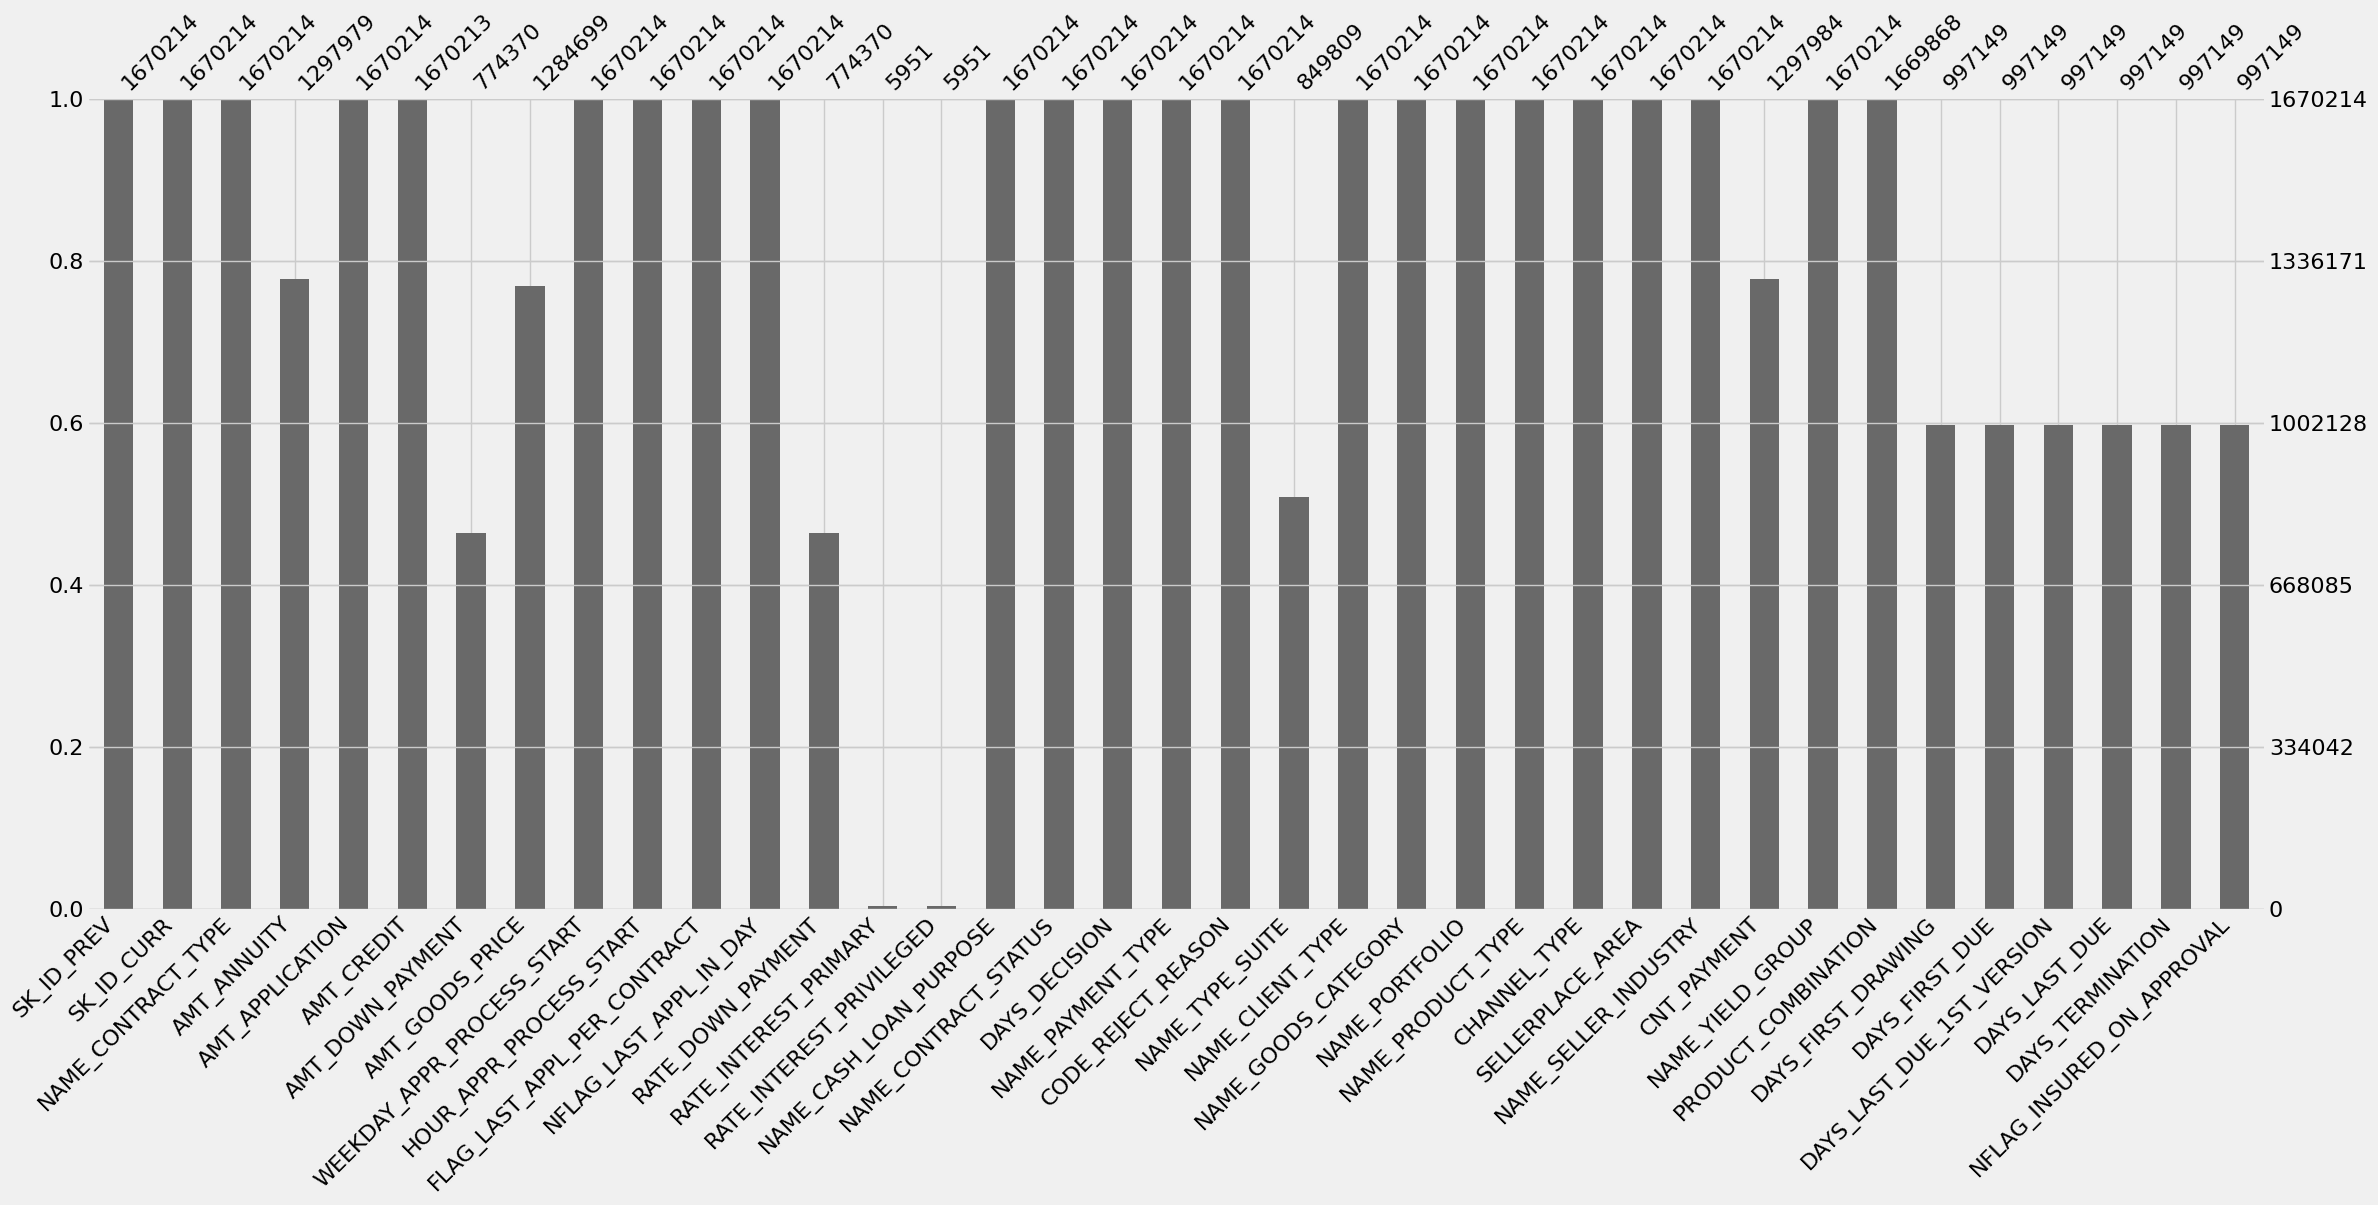

In [55]:
# Existe-t-il des valeurs manquantes dans ce jeu de données ?
msno.bar(df_previous_app)

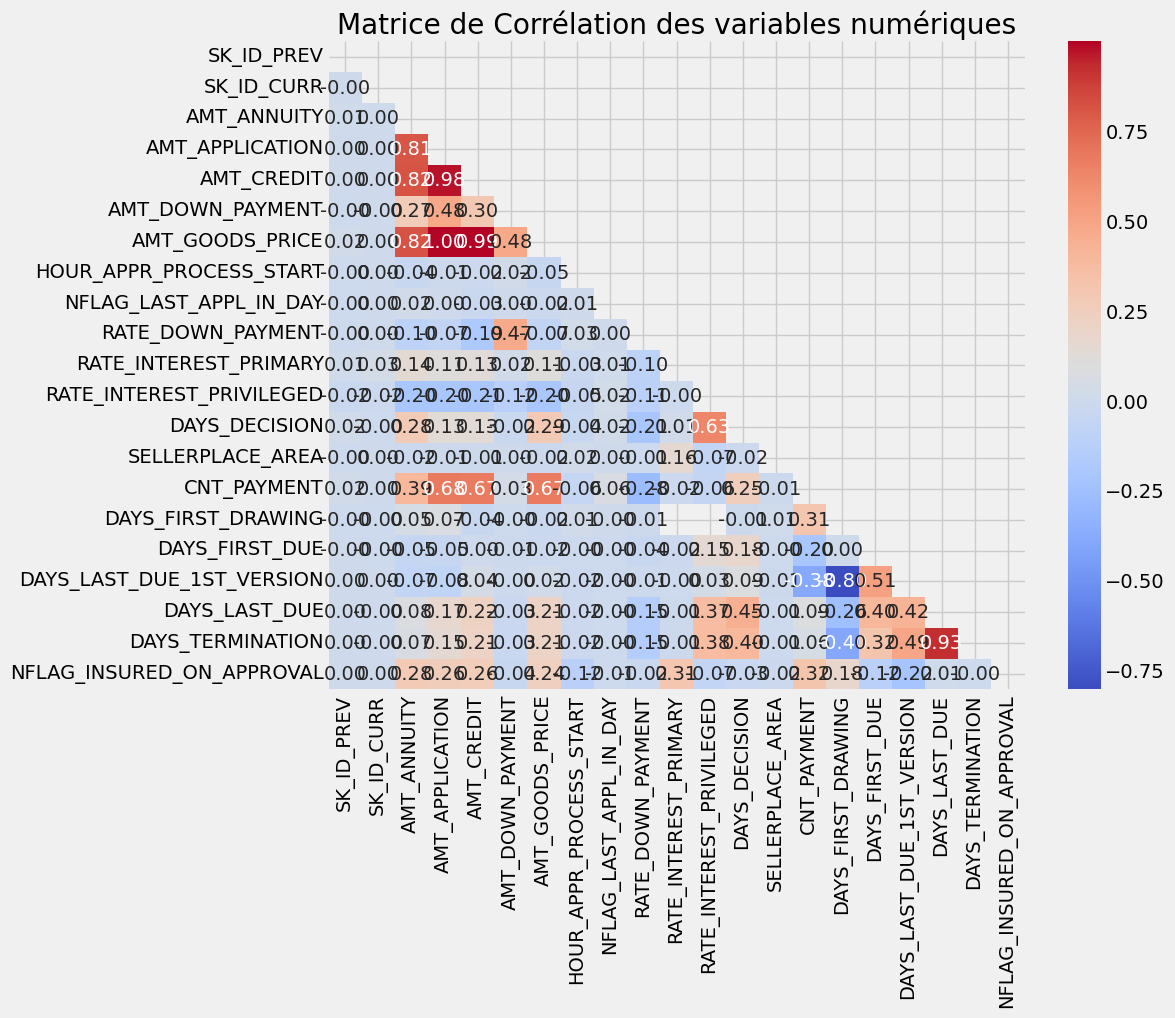

In [56]:
#Matrice de corrélation
colonnes_quanti_previous_app = df_previous_app.select_dtypes(include=['float64',  'int64']).columns
fc.correlation_matrix(df_previous_app, var_num=colonnes_quanti_previous_app, figsize=(10,8))

# III- Prétraitement des données

Pour cette partie du projet, nous allons nous baser sur un Kernel Kaggle( https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script).
Cette étape permettra d'assembler un Dataset global, structuré de manière à ce que chaque ligne représente 
un client, tout en incluant de manière exhaustive toutes les informations pertinentes issues de chaque Dataset.

### 3.1) Application_train et application_test

In [57]:
# Création des DataFrames et concaténation
df = pd.read_csv('application_train.csv')
test_df = pd.read_csv('application_test.csv')
print("Taille des données d'entrainement: {}, Taille des données de test: {}".format(len(df), len(test_df)))
df = pd.concat([df,test_df], ignore_index=True)
    
# Filtre des XNA sur les variables CODE_GENDER (train set)
df = df[df['CODE_GENDER'] != 'XNA']
    
# Transformation en variables binaires (0 or 1)
for feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[feature], uniques = pd.factorize(df[feature])
        
# One-Hot encoder des variables catégorielles
df, cat_cols = fc.one_hot_encoder(df, nan_as_category=False)
    
# Remplacement des valeurs DAYS_EMPLOYED: 365.243 par nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
# Nouvelles variables (%)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

del test_df
gc.collect()

Taille des données d'entrainement: 307511, Taille des données de test: 48744


18758

### 3.2) Bureau et bureau_balance

In [58]:
# Création des DataFrame
bureau = pd.read_csv('bureau.csv')
bb = pd.read_csv('bureau_balance.csv')

# One-Hot encoder des variables catégorielles
bb, bb_cat = fc.one_hot_encoder(bb, nan_as_category=True)
bureau, bureau_cat = fc.one_hot_encoder(bureau, nan_as_category=True)
    
# Aggrégation de bureau_balance en fonction de la variable 'SK_ID_BUREAU'
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

for col in bb_cat:
    bb_aggregations[col] = ['mean']
    
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
del bb, bb_agg
gc.collect()
    
# Création d'un dictionnaire d'aggrégation pour les variables numériques de bureau  
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
# Création d'un dictionnaire d'aggrégation pour les variables catégorielles de bureau 
cat_aggregations = {}

for cat in bureau_cat:
    cat_aggregations[cat] = ['mean']
    
for cat in bb_cat:
    cat_aggregations[cat + "_MEAN"] = ['mean']

# Aggrégation de bureau en fonction de la variable 'SK_ID_CURR' 
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
# Création de variables spécifiques pour les crédits Actifs (utilisation uniquement des variables numériques)
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()
    
# Création de variables spécifiques pour les crédits clôturés (utilisation uniquement des variables numériques)
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

del closed, closed_agg, 
print(f"Dimension bureau + bureau_balance : {bureau_agg.shape}")
gc.collect()

Dimension bureau + bureau_balance : (305811, 116)


0

In [59]:
# Ajout de bureau_agg à data : 
df = df.join(bureau_agg, how='left', on='SK_ID_CURR')

print(f"Nouvelles dimensions de df : {df.shape}")

del bureau_agg

Nouvelles dimensions de df : (356251, 363)


### 3.3) Previous_application

In [60]:
prev = pd.read_csv('previous_application.csv')

# One-Hot encoder 
prev, cat_cols = fc.one_hot_encoder(prev, nan_as_category= True)

# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

# Création d'une variable: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
# Création d'un dictionnaire d'aggrégation pour les variables numériques de previous 
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}
# Création d'un dictionnaire d'aggrégation pour les variables catégorielles de previous  
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

# Aggrégation de previous en fonction de la variable 'SK_ID_CURR'  
prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
# Création de variables spécifiques pour les candidatures approuvées (utilisation uniquement des variables numériques)
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
# Création de variables spécifiques pour les candidatures refusées (utilisation uniquement des variables numériques)
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

del refused, refused_agg, approved, approved_agg, prev
gc.collect()

0

In [61]:
# Ajout de prev_agg à data : 
df = df.join(prev_agg, how='left', on='SK_ID_CURR')
print(f"Nouvelles dimensions de df : {df.shape}")
del prev_agg

Nouvelles dimensions de df : (356251, 612)


### 3.4) Pos_cash_balance

In [62]:
pos = pd.read_csv('POS_CASH_balance.csv')

# One-Hot encoder
pos, cat_cols = fc.one_hot_encoder(pos, nan_as_category= True)
    
# Création d'un dictionnaire d'aggrégation pour pos_cash 
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

# Aggrégation de pos_cash en fonction de la variable 'SK_ID_CURR' 
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

# Création de la variables 'POS_COUNT' (nombre de dépôt effectué par le demandeur)
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
del pos
gc.collect()

0

In [63]:
# Ajout de pos_agg à data : 
df = df.join(pos_agg, how='left', on='SK_ID_CURR')

print(f"Nouvelles dimensions de df : {df.shape}")

del pos_agg

Nouvelles dimensions de df : (356251, 630)


### 3.5) Installments_payments

In [64]:
ins = pd.read_csv('installments_payments.csv')

# One-Hot Encoder
ins, cat_cols = fc.one_hot_encoder(ins, nan_as_category= True)
    
# Création de nouvelles variables : (Pourcentage et différence payés à chaque versement) 
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

# Nouvelles variables DPD et DBD 
"""
- DPD (days past due) : nombre de jours de retard dans le paiement. 
- DBD (days before due) : nombre de jours restants avant la date prévue de paiement. 
- Valeurs négatives mises à 0
"""
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
# Création d'un dictionnaire d'aggrégation pour installments 
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}

for cat in cat_cols:
    aggregations[cat] = ['mean']

# Aggrégation de installments en fonction de la variable 'SK_ID_CURR'  
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

# Création de la variables 'INSTAL_COUNT' (nombre de versemant effectué par le demandeur)
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

del ins
gc.collect()

0

In [65]:
# Ajout de installments_agg à data : 
df = df.join(ins_agg, how='left', on='SK_ID_CURR')

print(f"Nouvelles dimensions de df : {df.shape}")

del ins_agg

Nouvelles dimensions de df : (356251, 656)


### 3.6) Credit_card_balance

In [66]:
cc = pd.read_csv('credit_card_balance.csv')

# One-Hot encoder
cc, cat_cols = fc.one_hot_encoder(cc, nan_as_category= True)
    
# Aggregations
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

# Création de la variables 'CC_COUNT' (nombre de carte de crédit par demandeur)
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

del cc
gc.collect()

0

In [67]:
# Ajout de credit_card_agg à data : 
df = df.join(cc_agg, how='left', on='SK_ID_CURR')

print(f"Nouvelles dimensions de df : {df.shape}")

del cc_agg

Nouvelles dimensions de df : (356251, 797)


### 3.7) Enregistrement des données

In [68]:
df.to_csv('df_merge.csv', index=False)

In [69]:
df.head()

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   
2      100004     0.0            0             1                0   
3      100006     0.0            1             0                0   
4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0  ...                                 NaN   
1  ...                                 NaN   
2  ...                                 NaN   
3  ...                                 0.0   
4  ...                                 NaN   

   CC_NAME_CONTRACT_STATUS_Signed_MEAN  CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   
3                                  0.0                                 0.0   
4                                  NaN                                 NaN   

   CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                                 NaN                              NaN   
1                                 NaN                              NaN   
2                                 NaN                              NaN   
3                                 0.0                              0.0   
4                                 NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_MAX  CC_NAME_CONTRACT_STATUS_nan_MEAN  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              0.0                               0.0   
4                              NaN                               NaN   

   CC_NAME_CONTRACT_STATUS_nan_SUM  CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                              NaN                              NaN       NaN  
1                              NaN                              NaN       NaN  
2                              NaN                              NaN       NaN  
3                              0.0                              0.0       6.0  
4                              NaN                              NaN       NaN  

[5 rows x 797 columns]

In [70]:
# Supprimer les colonnes avec plus de 70% de valeurs manquantes
missing_percentages = df.isnull().mean() * 100
columns_to_drop = missing_percentages[missing_percentages > 60].index
df = df.drop(columns=columns_to_drop)

# Afficher le DataFrame après suppression des colonnes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356251 entries, 0 to 356254
Columns: 585 entries, SK_ID_CURR to INSTAL_COUNT
dtypes: float64(410), int32(133), int64(42)
memory usage: 1.4 GB


# IV- Features selection

Nous utiliserons LightGBM en validation croisée afin d'analyser les features importance 

In [71]:
def features_importance_lightgbm(df, num_folds=10, stratified=False, debug=False, class_weight=None): 

    # 1. Nettoyage des colonnes avec caractères JSON non supportés
    import re
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    # 2. Séparation de df en test / train en fonction de la cible : 
    train = df.loc[df['TARGET'].notna()]
    test = df.loc[df['TARGET'].isna()]
    
    print(f"Dimension de train : {train.shape}")
    print(f"Dimension de test : {test.shape}")
    
    # 3. Validation croisée : 
    folds = KFold(
        n_splits=num_folds,
        shuffle=True,
        random_state=42,
        )
    
    # 4. Création de X et y à partir de train :
    feats = [f for f in train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    X = train[feats]
    y = train['TARGET']

    # 5. Création des données de stockage : 
    oof_preds = np.zeros(train.shape[0])
    sub_preds = np.zeros(test.shape[0])
    feature_importance_df = pd.DataFrame()
    final_preds = np.zeros(train.shape[0])

    # 6. Boucle sur les différents folds : 
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[feats], train['TARGET'])):
        train_x, train_y = train[feats].iloc[train_idx], train['TARGET'].iloc[train_idx]
        valid_x, valid_y = train[feats].iloc[valid_idx], train['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            class_weight=class_weight, # Ajout de la gestion du déséquilibre des classes
            )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc')

        # Prédiction des probabilités de l'appartenance à la classe 1 sur la validation
        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]

        # Prédiction des probabilités de l'appartenance à la classe 1 sur le test
        sub_preds += clf.predict_proba(test[feats])[:, 1] / folds.n_splits

        # Prédiction des classes sur la validation
        final_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)

        # Complétion de feature_importance_df
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
        
    # Affichage du résultats total : 
    print(f"AUC score total : {round(roc_auc_score(y, oof_preds),6)}")
    
    # Création de la matrice de confusion
    cm = confusion_matrix(y, final_preds)
    print("Matrice de confusion :\n", cm)
    
    # Affichage de la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
    return feature_importance_df

Dimension de train : (307507, 585)
Dimension de test : (48744, 585)
Fold  1 AUC : 0.777999
Fold  2 AUC : 0.780939
Fold  3 AUC : 0.777611
Fold  4 AUC : 0.773508
Fold  5 AUC : 0.769276
Fold  6 AUC : 0.785046
Fold  7 AUC : 0.778901
AUC score total : 0.777575
Matrice de confusion :
 [[281085   1597]
 [ 23166   1659]]


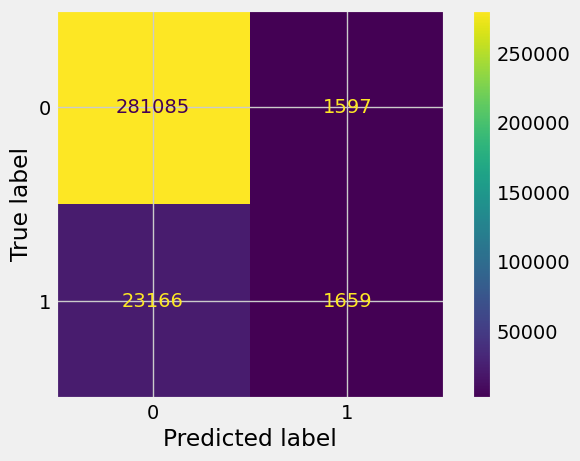

In [72]:
import json
feature_importance_df = features_importance_lightgbm(df, num_folds=7)
feature_importance_df.to_csv('df_feature_importance_lightGBM.csv', index=False)

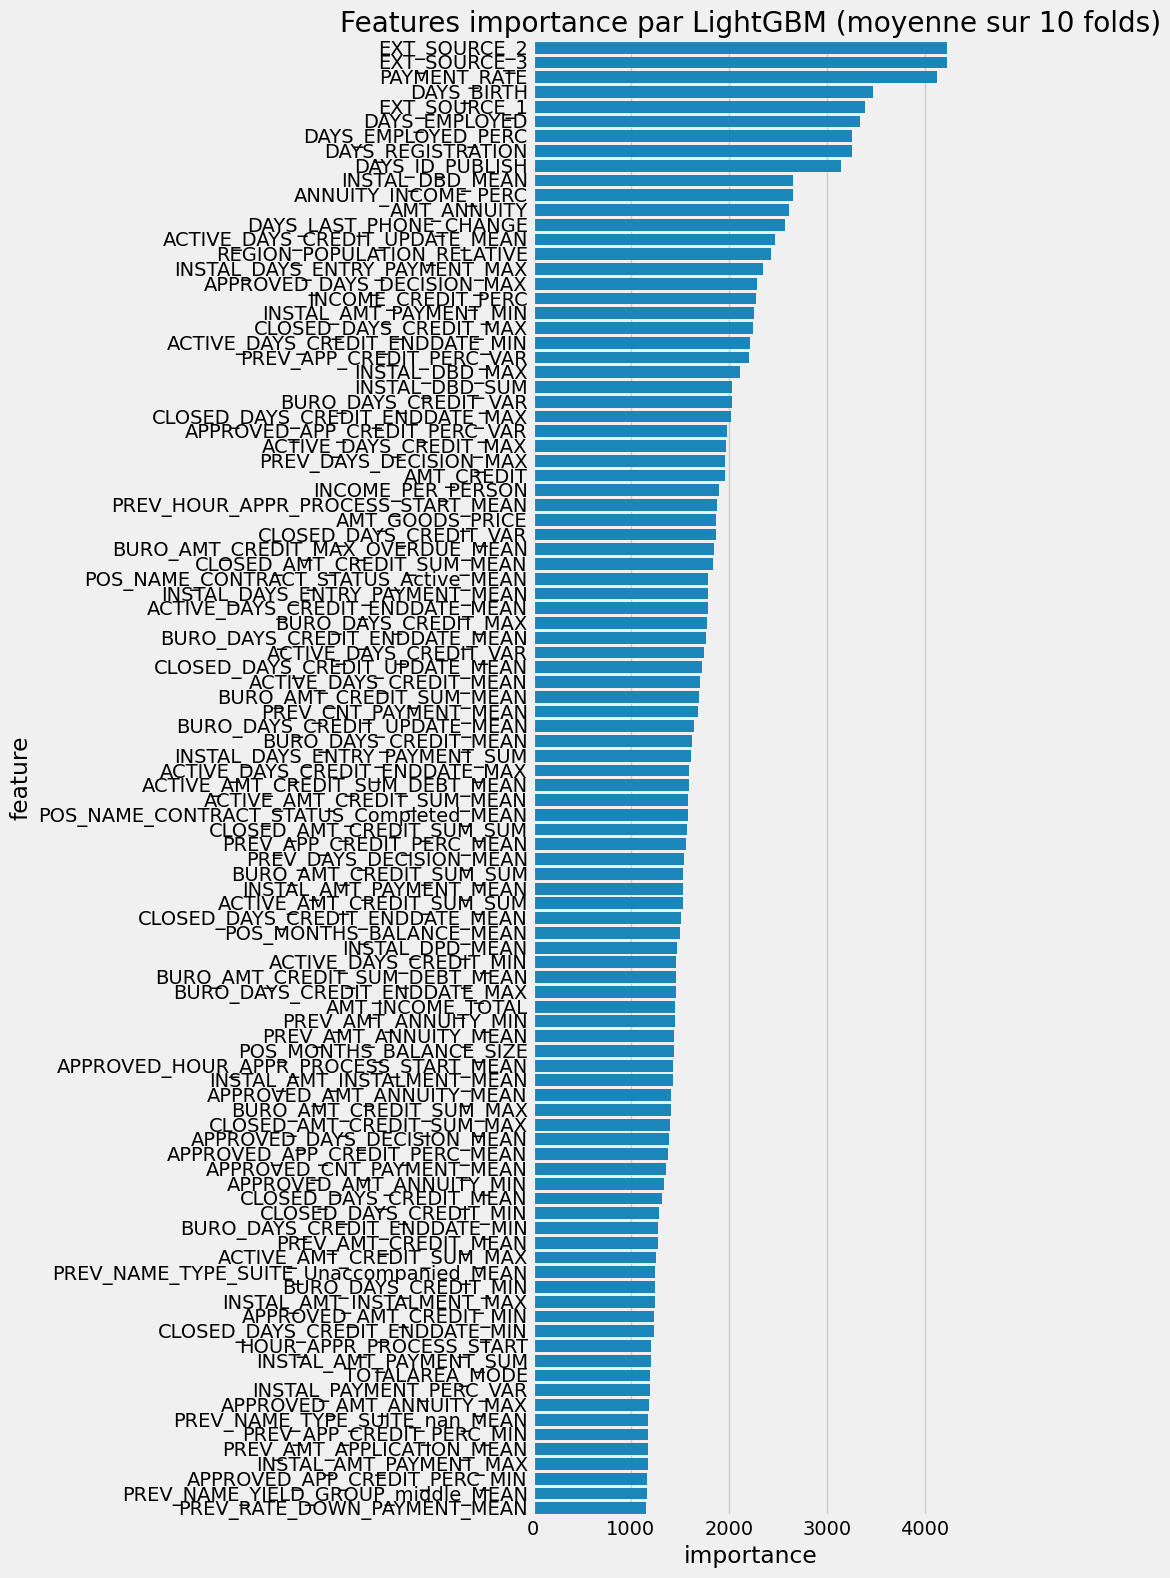

In [73]:
# Réprésentation graphique des 100 features les plus importances : 
col = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index.tolist()
best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(col)]
best_features = best_features.groupby('feature')['importance'].mean().to_frame('importance').sort_values('importance', ascending=False)

plt.figure(figsize=(10, 16))
sns.barplot(x="importance", y=best_features.index, data=best_features)
plt.title('Features importance par LightGBM (moyenne sur 10 folds)')
plt.tight_layout()
plt.show()

del col 

In [74]:
# Sélection de features :  
df_selected_features = df.loc[:,best_features.index]

# Calcul de la matrice de corréaltion :
correlation_matrix = df_selected_features.corr()

# Récupération des paires de variables fortement corrélées :
correlated_pairs = set()

for i in range(len(best_features.index)):
    
    for j in range(i + 1, len(best_features.index)):
        feature1 = best_features.index[i]
        feature2 = best_features.index[j]
        correlation = correlation_matrix.loc[feature1, feature2]
       
        if abs(correlation) > 0.6: 
            correlated_pairs.add((feature1, feature2))


# Sélection des features à éliminées : 
features_to_remove = set()

for pair in correlated_pairs:
    feature1, feature2 = pair
    
    # Sélection de la variables à éliminer en fonction de son importance :
    if best_features.loc[feature1, 'importance'] < best_features.loc[feature2, 'importance']: 
        features_to_remove.add(feature1)
    else: 
        features_to_remove.add(feature2)

print(f"Sur {len(best_features)} variables possédant le plus d\'importances, nous pouvons en éliminer {len(features_to_remove)}"
      f" qui ont une corrélation importantes avec les autres\n")

print(f"Liste ds features à garder : ")
display(best_features.loc[~best_features.index.isin(list(features_to_remove))].sort_values('importance', ascending=False))

del correlated_pairs, correlation, correlation_matrix, df_selected_features, feature1, feature2, i, j, pair

Sur 100 variables possédant le plus d'importances, nous pouvons en éliminer 55 qui ont une corrélation importantes avec les autres

Liste ds features à garder : 


importance
feature                                             
EXT_SOURCE_2                             4228.428571
EXT_SOURCE_3                             4223.142857
PAYMENT_RATE                             4125.142857
DAYS_BIRTH                               3468.857143
EXT_SOURCE_1                             3391.714286
DAYS_EMPLOYED                            3338.285714
DAYS_REGISTRATION                        3255.000000
DAYS_ID_PUBLISH                          3143.285714
INSTAL_DBD_MEAN                          2654.000000
ANNUITY_INCOME_PERC                      2651.428571
AMT_ANNUITY                              2617.142857
DAYS_LAST_PHONE_CHANGE                   2578.428571
ACTIVE_DAYS_CREDIT_UPDATE_MEAN           2473.714286
REGION_POPULATION_RELATIVE               2430.571429
INSTAL_DAYS_ENTRY_PAYMENT_MAX            2353.142857
INCOME_CREDIT_PERC                       2276.428571
INSTAL_AMT_PAYMENT_MIN                   2261.714286
CLOSED_DAYS_CREDIT_MAX                   2244.428571
ACTIVE_DAYS_CREDIT_ENDDATE_MIN           2213.142857
PREV_APP_CREDIT_PERC_VAR                 2205.428571
INSTAL_DBD_MAX                           2115.714286
INSTAL_DBD_SUM                           2028.857143
BURO_DAYS_CREDIT_VAR                     2027.857143
CLOSED_DAYS_CREDIT_ENDDATE_MAX           2019.285714
ACTIVE_DAYS_CREDIT_MAX                   1966.857143
INCOME_PER_PERSON                        1904.571429
PREV_HOUR_APPR_PROCESS_START_MEAN        1879.000000
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN         1847.857143
CLOSED_AMT_CREDIT_SUM_MEAN               1840.571429
POS_NAME_CONTRACT_STATUS_Active_MEAN     1787.571429
ACTIVE_DAYS_CREDIT_VAR                   1750.142857
CLOSED_DAYS_CREDIT_UPDATE_MEAN           1731.714286
PREV_CNT_PAYMENT_MEAN                    1682.000000
PREV_APP_CREDIT_PERC_MEAN                1566.285714
INSTAL_AMT_PAYMENT_MEAN                  1537.000000
INSTAL_DPD_MEAN                          1477.000000
PREV_AMT_ANNUITY_MIN                     1452.285714
PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN  1247.285714
INSTAL_AMT_INSTALMENT_MAX                1243.857143
HOUR_APPR_PROCESS_START                  1208.571429
TOTALAREA_MODE                           1198.571429
INSTAL_PAYMENT_PERC_VAR                  1194.428571
PREV_NAME_TYPE_SUITE_nan_MEAN            1179.000000
PREV_NAME_YIELD_GROUP_middle_MEAN        1167.571429
PREV_RATE_DOWN_PAYMENT_MEAN              1158.428571

Dimension de train : (307507, 46)
Dimension de test : (48744, 46)
Fold  1 AUC : 0.761298
Fold  2 AUC : 0.763415
Fold  3 AUC : 0.762084
Fold  4 AUC : 0.753859
Fold  5 AUC : 0.758246
Fold  6 AUC : 0.765838
Fold  7 AUC : 0.763769
AUC score total : 0.76118
Matrice de confusion :
 [[281174   1508]
 [ 23496   1329]]


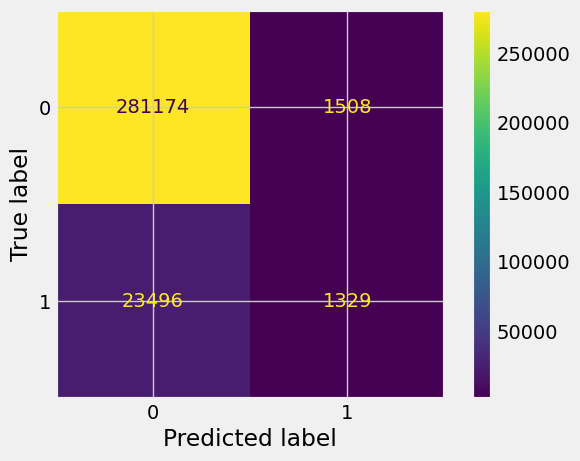

In [75]:
# Evaluation avec LightGBM : 

# 1. Récupération des features à garder : 
ls_features = [f for f in best_features.index if f not in features_to_remove]
ls_features.append('TARGET')

# 2. Filtre sur data : 
df_filtre = df.loc[:, ls_features]

# 3. Evalutation : 
_ = features_importance_lightgbm(df_filtre, num_folds=7)

Au vu de la faible perte de performance, nous ne garderons donc pour la suite que les 49 variables.

In [76]:
# Suppression des variables : 
del best_features, df, feature_importance_df, features_to_remove, ls_features

In [77]:
df_filtre.to_csv('df_filtre.csv', index=False)

# V- Preprocessing

In [78]:
df_filtre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356251 entries, 0 to 356254
Data columns (total 46 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   EXT_SOURCE_2                             355583 non-null  float64
 1   EXT_SOURCE_3                             286618 non-null  float64
 2   PAYMENT_RATE                             356215 non-null  float64
 3   DAYS_BIRTH                               356251 non-null  int64  
 4   EXT_SOURCE_1                             162343 non-null  float64
 5   DAYS_EMPLOYED                            291603 non-null  float64
 6   DAYS_REGISTRATION                        356251 non-null  float64
 7   DAYS_ID_PUBLISH                          356251 non-null  int64  
 8   INSTAL_DBD_MEAN                          339583 non-null  float64
 9   ANNUITY_INCOME_PERC                      356215 non-null  float64
 10  AMT_ANNUITY                          

<Axes: >

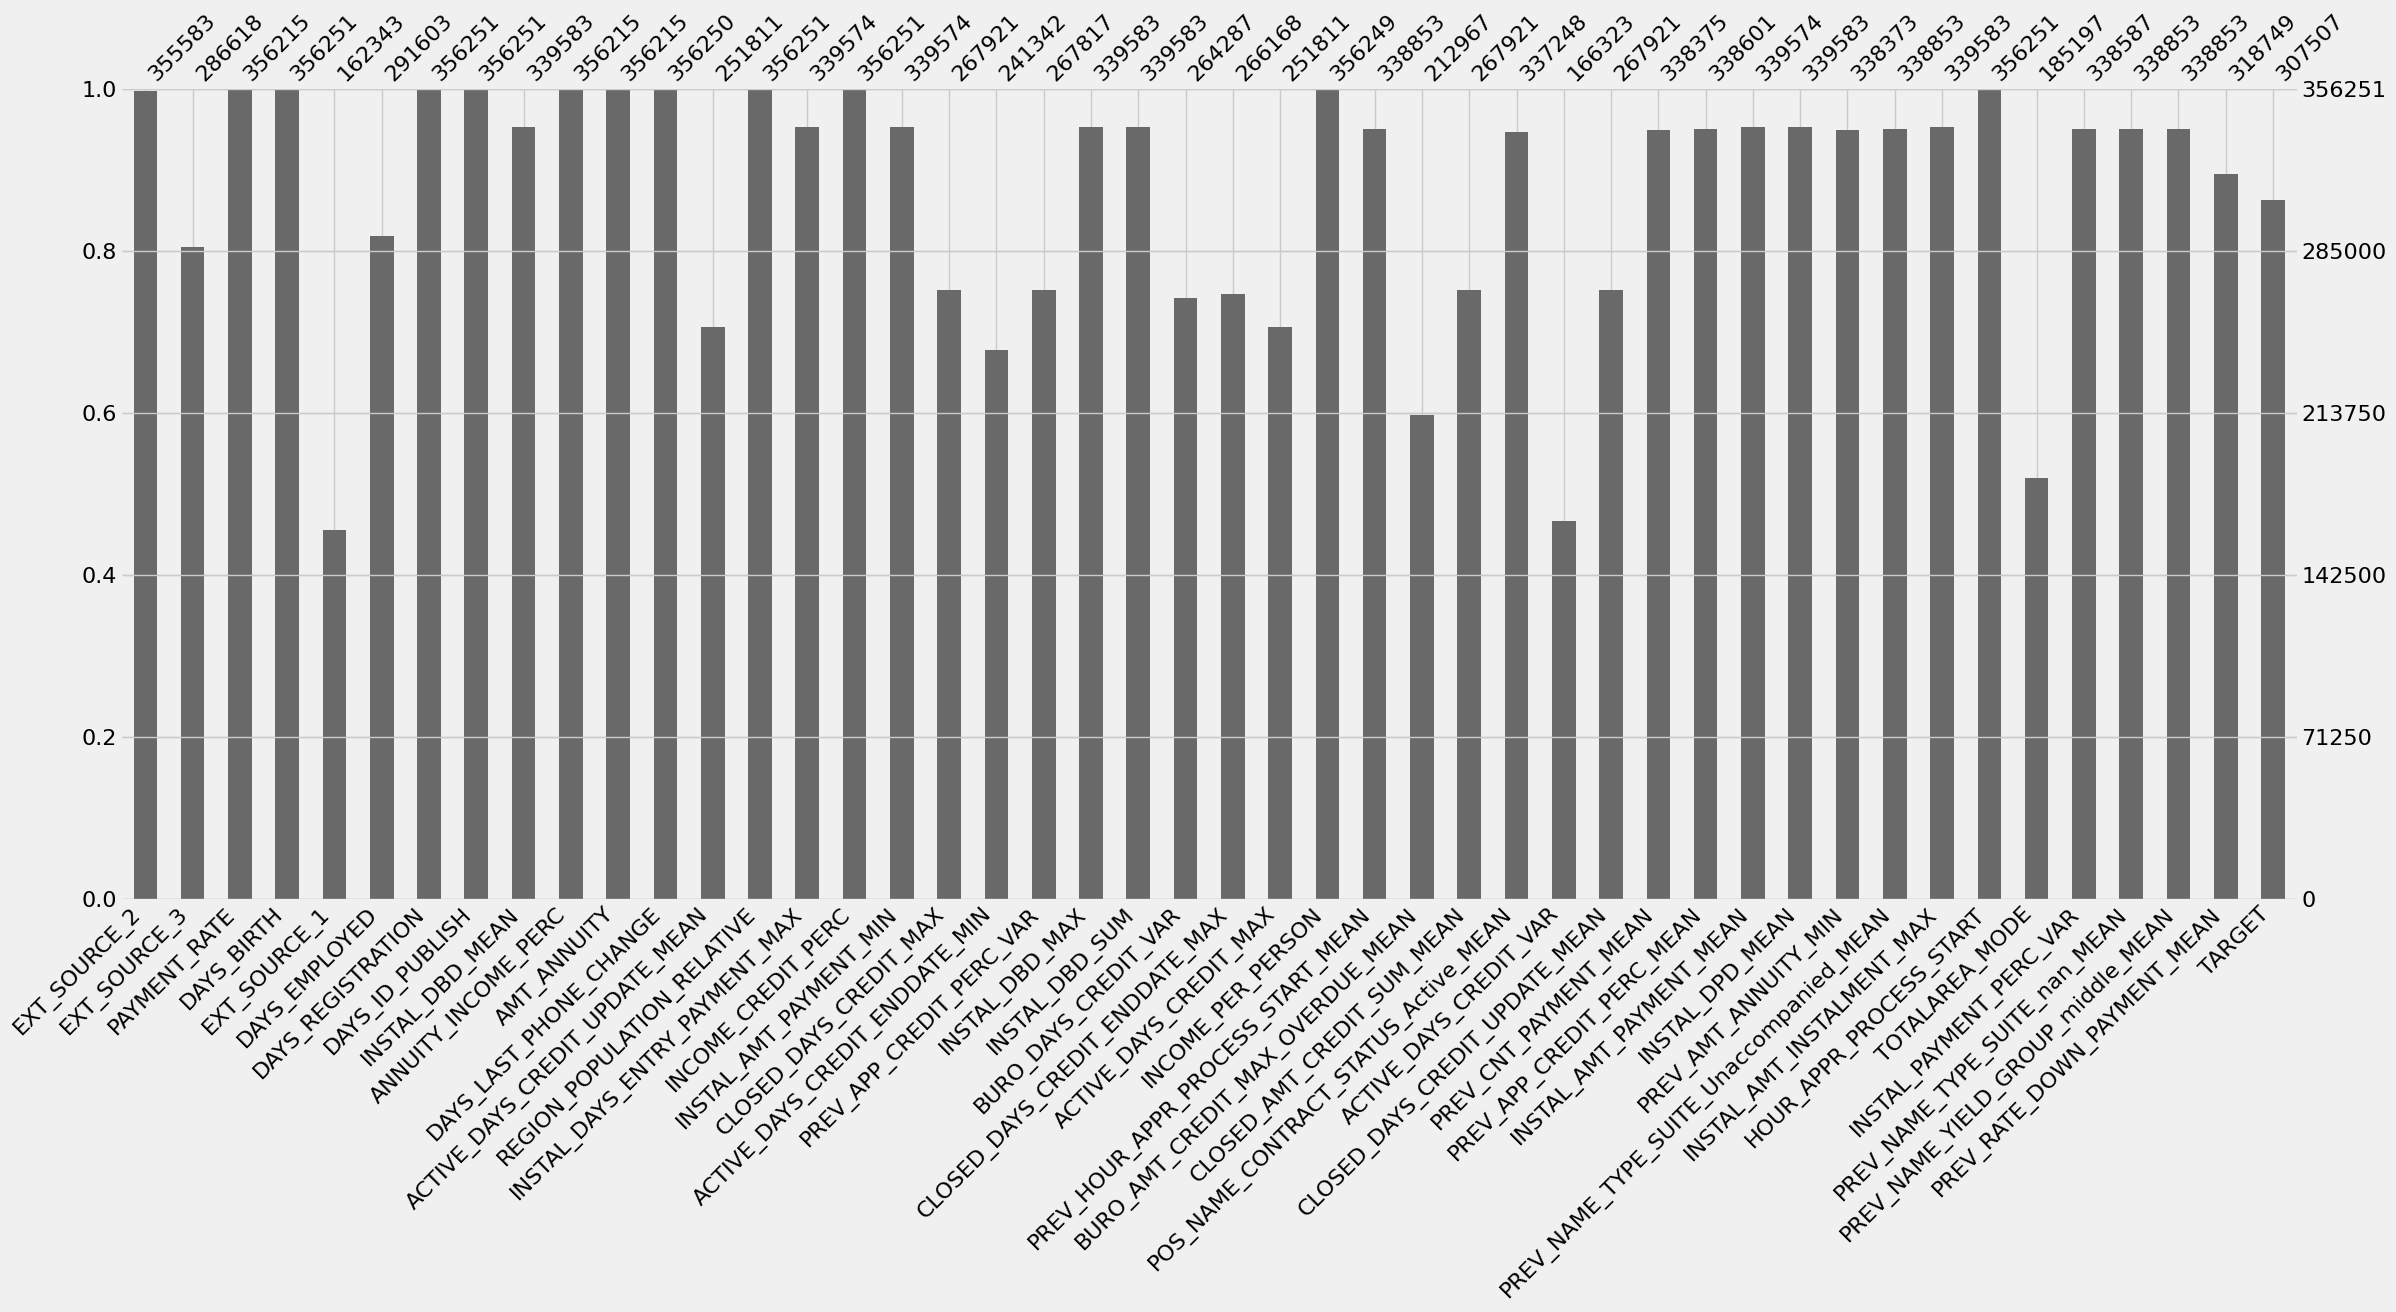

In [79]:
msno.bar(df_filtre)

In [80]:
def pre_process_dataframe(df, fillna_strategy):
    """
    Prétraitement des données d'entraînement et de test.

    Args:
        df (pandas.DataFrame): Le DataFrame contenant les données d'entraînement et de test.
        fillna_strategy (str): La stratégie d'imputation pour les valeurs manquantes.
            Doit être l'un des suivants : 'median', 'mean', 'mode'.

    Raises:
        ValueError: Si fillna_strategy n'est pas 'median', 'mean' ou 'mode'.

    Returns:
        pandas.DataFrame, pandas.DataFrame: Deux DataFrames, l'un pour les données d'entraînement prétraitées,
        l'autre pour les données de test prétraitées.
    """
    
    # 1. Vérification de fillna_strategy : 
    if fillna_strategy not in ['median', 'mean', 'mode']:
        raise ValueError("fillna_strategy doit être égal à 'median', 'mean' ou 'mode'.")
    
    # 2. Création de l'imputer : 
    if fillna_strategy == 'mode':
        imputer = SimpleImputer(strategy='most_frequent')
    else:
        imputer = SimpleImputer(strategy=fillna_strategy)
        
    # 3. Séparation en train et test : 
    df_train = df.loc[df['TARGET'].notna()].reset_index(drop=True)
    df_test = df.loc[df['TARGET'].isna()].reset_index(drop=True)
    
    # 4. Récupération de la colonne TARGET : 
    target = df_train['TARGET'].copy()
    target = target.astype('int8')
    
    df_train = df_train.drop('TARGET', axis=1)
    df_test = df_test.drop('TARGET', axis=1)
   
    # 5. Gestion des valeurs infinies : 
    df_train = df_train.replace([np.inf, -np.inf], np.nan)
    df_test = df_test.replace([np.inf, -np.inf], np.nan)
   
    # 6. Imputation des valeurs manquantes : 
    df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns)
    df_test_imputed = pd.DataFrame(imputer.transform(df_test), columns=df_test.columns)
   
    # 7. Conversion des colonnes booléennes en int8 :
    bool_columns = df_train.select_dtypes(include=['bool']).columns
   
    df_train_imputed[bool_columns] = df_train_imputed[bool_columns].astype('int8')
    df_test_imputed[bool_columns] = df_test_imputed[bool_columns].astype('int8')
   
    # 8. Conversion des colonnes float64 en float32 :
    float_columns = df_train.select_dtypes(include=['float64']).columns
   
    df_train_imputed[float_columns] = df_train_imputed[float_columns].astype('float32')
    df_test_imputed[float_columns] = df_test_imputed[float_columns].astype('float32')
   
    # 9. Conversion des colonnes int64 en int8 :
    int_columns = df_train.select_dtypes(include=['int64']).columns
   
    df_train_imputed[int_columns] = df_train_imputed[int_columns].astype('int8')
    df_test_imputed[int_columns] = df_test_imputed[int_columns].astype('int8')
   
    # 10. Ajout de la colonne TARGET à df_train : 
    df_train_imputed['TARGET'] = target
    
    # 11. Affichage : 
    print('**'*50)
    print(f"\nTRAIN\n"
          f"Nombre de colonnes avec au moins une valeur manquante : {df_train_imputed.isna().any().sum()}"
          f"\ntype de données : {df_train_imputed.dtypes.unique().tolist()}\n"
          )
    print('**'*50)
    
    print('**'*50)
    print(f"\nTEST\n"
          f"Nombre de colonnes avec au moins une valeur manquante : {df_test_imputed.isna().any().sum()}"
          f"\ntype de données : {df_test_imputed.dtypes.unique().tolist()}\n"
          )
    print('**'*50)
    
    return df_train_imputed, df_test_imputed

In [81]:
# Complétion par la moyenne : 
train_mean_imputed, test_mean_imputed = pre_process_dataframe(df_filtre, fillna_strategy='mean')
print(f"Dimension train : {train_mean_imputed.shape}")
print(f"Dimension test : {test_mean_imputed.shape}")

****************************************************************************************************

TRAIN
Nombre de colonnes avec au moins une valeur manquante : 0
type de données : [dtype('float32'), dtype('int8')]

****************************************************************************************************
****************************************************************************************************

TEST
Nombre de colonnes avec au moins une valeur manquante : 0
type de données : [dtype('float32'), dtype('int8')]

****************************************************************************************************
Dimension train : (307507, 46)
Dimension test : (48744, 45)


In [82]:
# Complétion par la médianne : 
train_median_imputed, test_median_imputed = pre_process_dataframe(df_filtre, fillna_strategy='median')
print(f"Dimension train : {train_median_imputed.shape}")
print(f"Dimension test : {test_median_imputed.shape}")

****************************************************************************************************

TRAIN
Nombre de colonnes avec au moins une valeur manquante : 0
type de données : [dtype('float32'), dtype('int8')]

****************************************************************************************************
****************************************************************************************************

TEST
Nombre de colonnes avec au moins une valeur manquante : 0
type de données : [dtype('float32'), dtype('int8')]

****************************************************************************************************
Dimension train : (307507, 46)
Dimension test : (48744, 45)


In [83]:
# Complétion par le mode : 
train_mode_imputed, test_mode_imputed = pre_process_dataframe(df=df_filtre, 
                                                              fillna_strategy='mode',
                                                              )

print(f"Dimension train : {train_mode_imputed.shape}")
print(f"Dimension test : {test_mode_imputed.shape}")

****************************************************************************************************

TRAIN
Nombre de colonnes avec au moins une valeur manquante : 0
type de données : [dtype('float32'), dtype('int8')]

****************************************************************************************************
****************************************************************************************************

TEST
Nombre de colonnes avec au moins une valeur manquante : 0
type de données : [dtype('float32'), dtype('int8')]

****************************************************************************************************
Dimension train : (307507, 46)
Dimension test : (48744, 45)


In [84]:
# Enregistrement des df
train_mean_imputed.to_csv('train_mean_imputed.csv', index=False)
train_median_imputed.to_csv('train_median_imputed.csv', index=False)
train_mode_imputed.to_csv('train_mode_imputed.csv', index=False)

test_mean_imputed.to_csv('test_mean_imputed.csv', index=False)
test_median_imputed.to_csv('test_median_imputed.csv', index=False)
test_mode_imputed.to_csv('test_mode_imputed.csv', index=False)

# VI- Selection du dataset 

In [85]:
# Importation des données
train_mean = pd.read_csv('train_mean_imputed.csv')
train_median = pd.read_csv('train_median_imputed.csv')
train_mode = pd.read_csv('train_mode_imputed.csv')

# Création du dictionnaire
dict_data = {
    'train_mean': train_mean,
    'train_median': train_median,
    'train_mode': train_mode
}

In [86]:
def preprocess_data(data, reduce_fraction=None):
    # Séparation des données et de la Target : 
    X = data.drop('TARGET', axis=1)
    y = data['TARGET'].copy()
    
    # Séparation en ensemble de train et test : 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
        
    # Gestion du déséquilibre de classe avec SMOTE : 
    #smote = SMOTE(sampling_strategy='auto', random_state=42)
    #X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Standardisation du test et du train :     
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    return X_train, X_test, y_train, y_test

In [87]:
best_accuracy = 0 
best_df = None

for name, df in dict_data.items(): 
    # Création du modèle : 
    model = LogisticRegression(random_state=42)
    
    # Preprocessing de df : 
    X_train, X_test, y_train, y_test = preprocess_data(df)
    
    # Entrainement et prediction : 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calcul de l'accuracy : 
    accuracy = accuracy_score(y_test, y_pred)
    
    # Mise à jour du meilleur dataset : 
    if accuracy > best_accuracy: 
        best_accuracy = accuracy
        best_df = name

print(f"Le dataset sélectionné est {best_df}")

# Nettoyage des variables inutiles : 
del accuracy, best_accuracy, best_df, df, dict_data, model, name, X_test, X_train, y_test, y_train, y_pred

Le dataset sélectionné est train_mean


# VI- Modélisation

In [88]:
def score_metier(y_test, y_pred):
    '''Créer un score métier à partir de la matrice de confusion.
    :param: y_test (vraies valeurs), y_pred (valeurs prédites par le modèle)
    :return: gain (score métier)
    '''
    TP_coeff = 0       # Vrais positifs (prédit correctement une observation comme positive (1) lorsque la vraie classe est également positive (1).)
    FP_coeff = 1       # Faux positifs (prédit incorrectement une observation comme positive (1) alors que la vraie classe est négative (0). Aussi appelés erreurs de type I.)
    FN_coeff = +10     # Faux négatifs (prédit incorrectement une observation comme négative (0) alors que la vraie classe est positive (1). Aussi appelés erreurs de type II.)
    TN_coeff = 0       # Vrais négatifs (prédit correctement une observation comme négative (0) lorsque la vraie classe est également négative (0).)
    
    (TN, FP, FN, TP) = metrics.confusion_matrix(y_test, y_pred).ravel()
    
    gain = (TP*TP_coeff + TN*TN_coeff + FP*FP_coeff + FN*FN_coeff)/(TN+FP+FN+TP)
    
    return gain


def eval_score(model, X_test, y_test, seuil=0.5):
    '''Calcule, affiche et enregistre les différentes métriques.
    :param: model, X_test (dataframe de validation), y_test (vraies valeurs),
    seuil (seuil de détermination des prédictions)
    :return: affiche (et return) les métriques, la matrice de confusion et la courbe ROC.
    '''    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = np.where(y_pred_proba > seuil, 1, 0)
    
    metier = score_metier(y_test, y_pred)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, zero_division=1)
    recall = metrics.recall_score(y_test, y_pred, zero_division=1)
    f1_score = metrics.f1_score(y_test, y_pred, zero_division=1)
    fbeta_score = metrics.fbeta_score(y_test, y_pred, beta=2, zero_division=1)
    rocauc = metrics.roc_auc_score(y_test, y_pred_proba)
    
    print('Score métier :{:.2f}'.format(metier))
    print('Accuracy score : {:.2f}'.format(accuracy))
    print('Precision score : {:.2f}'.format(precision))
    print('Recall score : {:.2f}'.format(recall))
    print('F1 score : {:.2f}'.format(f1_score))
    print('Fbeta score : {:.2f}'.format(fbeta_score))
    print('ROC AUC score : {:.2f}'.format(rocauc))
    
    
    # Matrice de confusion
    conf_mat = metrics.confusion_matrix(y_test,y_pred)
    plt.figure(figsize = (6,4))
    sns.heatmap(conf_mat, annot=True, cmap="Blues")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Matrice de confusion')
    plt.show()

    # Courbe ROC
    fig, ax = plt.subplots(figsize=(6, 5))
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Courbe ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba

D'abord, on sépare nos données en train et test, et on applique un StandardScaler

In [89]:
X_train, X_test, y_train, y_test = preprocess_data(train_mode)

In [90]:
def logToMLflow(model, X_train, X_test, y_train, y_test, name="", params="", training_tag=""):
    """Fonction de logging d'une expérimentation vers MLFlow."""
        
    # Start an MLflow run
    with mlflow.start_run(run_name=name):
        # Log the hyperparameters
        if params:
            mlflow.log_params(params)
        
        model_fit = model.fit(X_train, y_train)
        
        # infer model signature
        predictions = model_fit.predict(X_train)
        signature = infer_signature(X_train, predictions)

       # Calcul et enregistrement des metriques 
        metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba = eval_score(model_fit, X_test, y_test)
   
        mlflow.log_metric("score_métier", metier)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1_score)
        mlflow.log_metric("fbeta_score", fbeta_score)
        mlflow.log_metric("rocauc", rocauc)
    
        # Set a tag that we can use to remind ourselves what this run was for
        if training_tag:
            mlflow.set_tag("Training Info", training_tag)

        # construct an evaluation dataset from the test set
        eval_data = X_test.copy()
        eval_data['target'] = y_test.values
        # Log the model
        model_info = mlflow.sklearn.log_model(model_fit, 'model', signature=signature)

        result = mlflow.evaluate(
            model_info.model_uri,
            eval_data,
            targets="target",
            model_type="classifier",
            evaluators=["default"],
        )

Training Dummy Classifier...
Score métier :0.81
Accuracy score : 0.92
Precision score : 1.00
Recall score : 0.00
F1 score : 0.00
Fbeta score : 0.00
ROC AUC score : 0.50


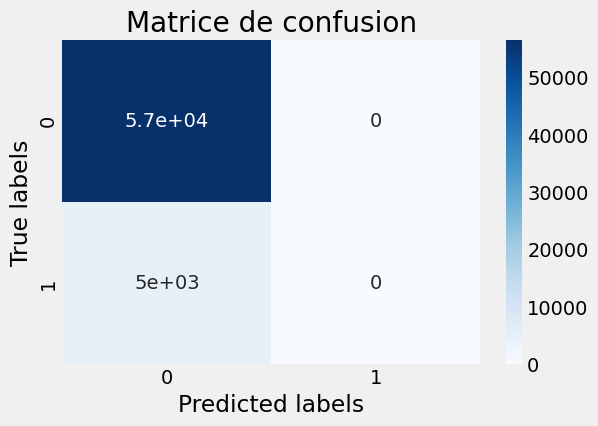

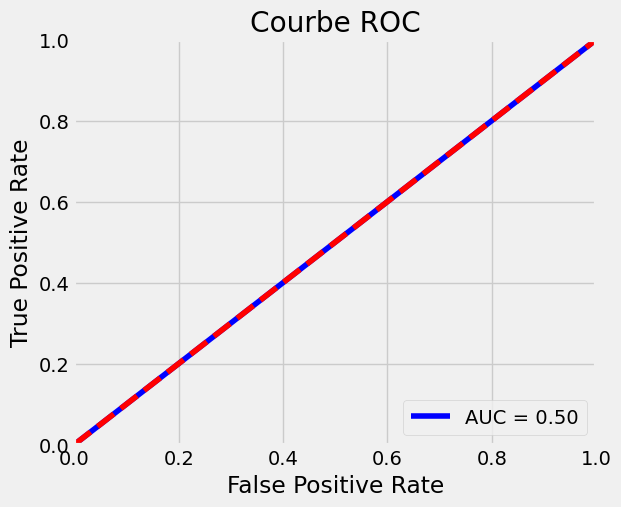

Dummy Classifier training complete.
Training Logistic Regression...
Score métier :0.80
Accuracy score : 0.92
Precision score : 0.43
Recall score : 0.01
F1 score : 0.01
Fbeta score : 0.01
ROC AUC score : 0.73


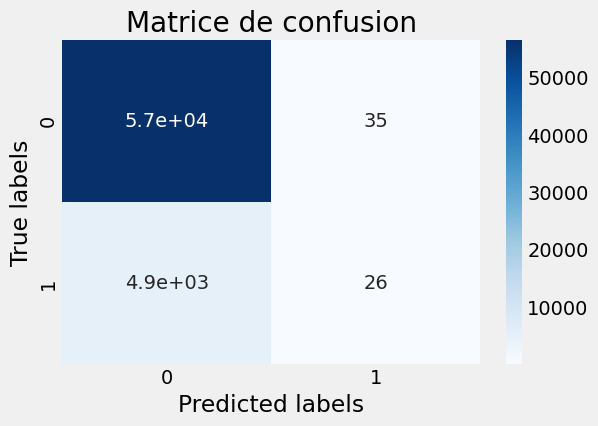

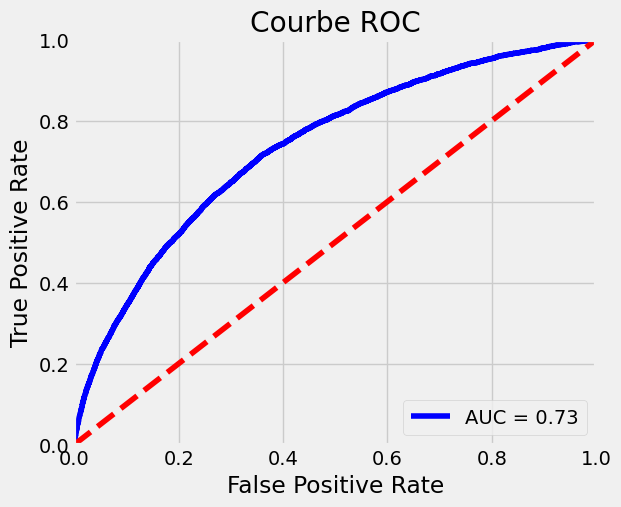

Logistic Regression training complete.
Training Decision Tree...
Score métier :0.75
Accuracy score : 0.85
Precision score : 0.14
Recall score : 0.17
F1 score : 0.15
Fbeta score : 0.16
ROC AUC score : 0.54


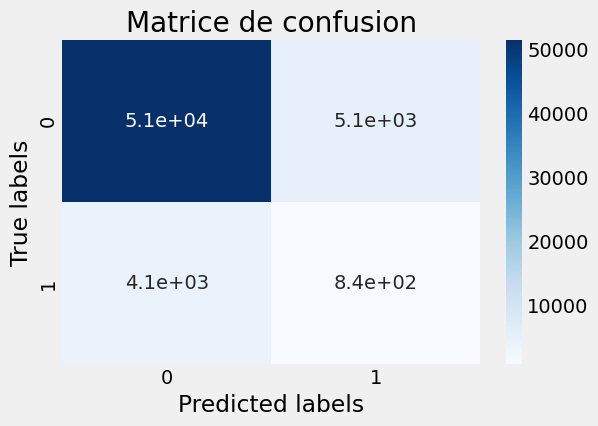

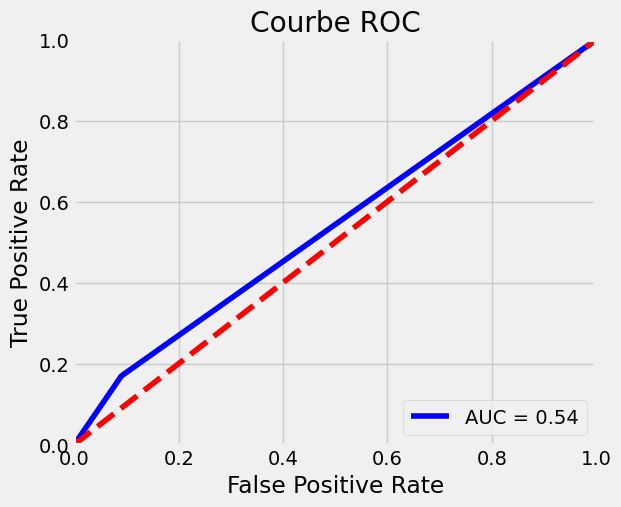

Decision Tree training complete.
Training RandomForest...
Score métier :0.81
Accuracy score : 0.92
Precision score : 0.54
Recall score : 0.00
F1 score : 0.01
Fbeta score : 0.00
ROC AUC score : 0.72


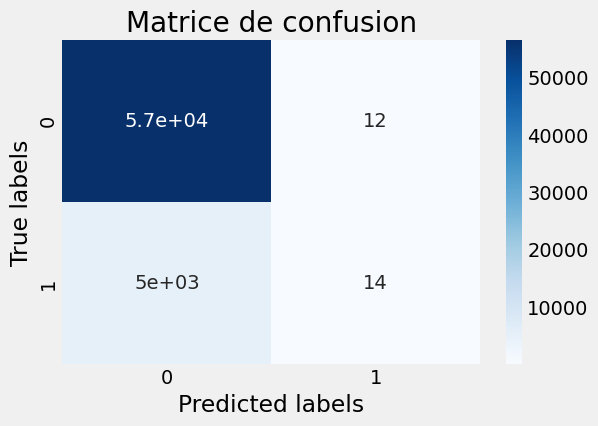

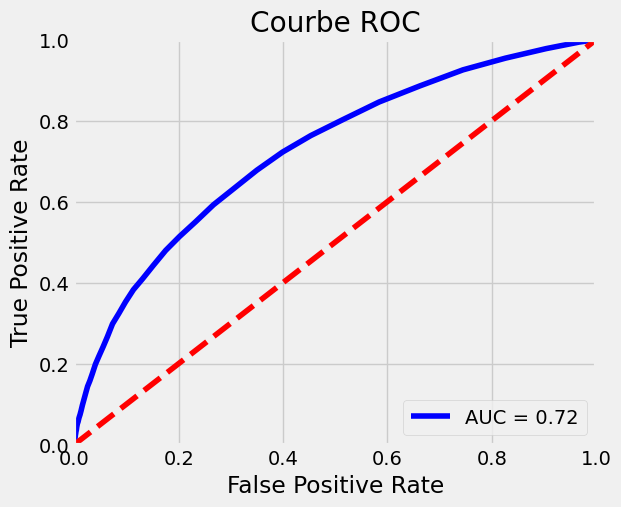

RandomForest training complete.
Training XGBoost...
Score métier :0.78
Accuracy score : 0.92
Precision score : 0.43
Recall score : 0.04
F1 score : 0.08
Fbeta score : 0.05
ROC AUC score : 0.76


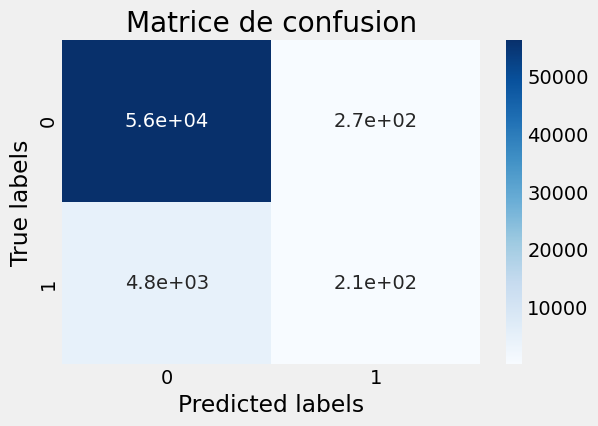

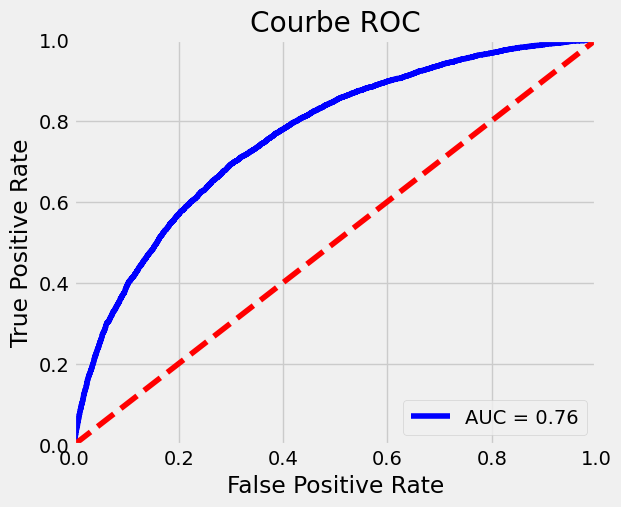

XGBoost training complete.
Training LightGBM...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10773
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
Score métier :0.79
Accuracy score : 0.92
Precision score : 0.53
Recall score : 0.02
F1 score : 0.05
Fbeta score : 0.03
ROC AUC score : 0.77


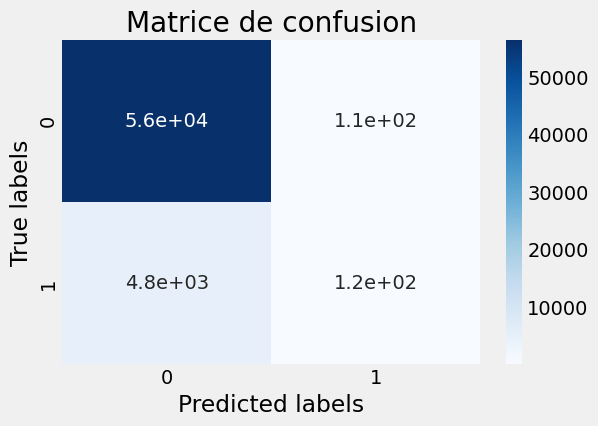

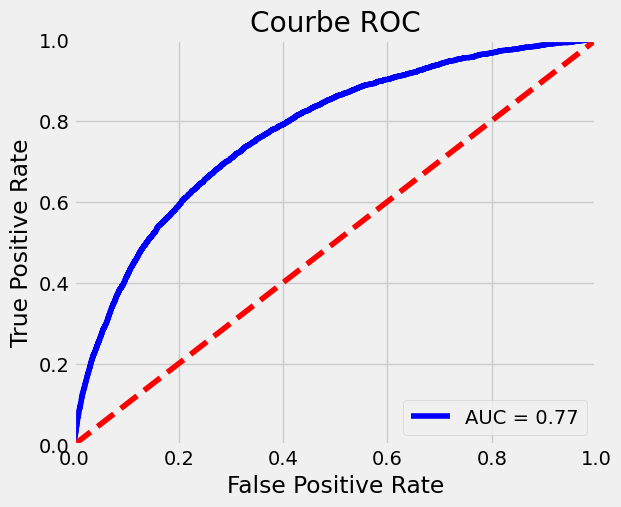

LightGBM training complete.


In [91]:
# Définition des modèles qu'on va comparer
models = {
    "Dummy Classifier" : DummyClassifier(random_state=42),
    "Logistic Regression" : LogisticRegression(random_state=42),
    "Decision Tree" : DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost" : XGBClassifier(random_state = 42, n_jobs =-1),
    "LightGBM" : LGBMClassifier(random_state=42),
}

# Parcours des modèles pour entraînement et logging
for name, model in models.items():
    print(f"Training {name}...")
    # Log the experiment
    model_mlflow = model.fit(X_train, y_train)
    logToMLflow(model_mlflow, X_train, X_test, y_train, y_test, name)
    print(f"{name} training complete.")

- **Dummy Classifier** : En examinant la matrice de confusion, nous observons que le Dummy Classifier est efficace uniquement dans la prédiction de la classe 0 (clients ne faisant pas défaut), ce qui entraîne un grand nombre de faux négatifs (mauvais clients prédits comme bons clients). Par conséquent, le score métier du modèle est relativement faible, car il pénalise davantage les faux négatifs. La plupart de nos scores sont à 0, car le modèle ne prédit aucune valeur positive. Cette situation entraîne des estimations de scores à zéro, ce qui se traduit par une division par zéro. L'AUC (Area Under the Curve) est de 0,5, ce qui correspond à la performance typique des modèles de référence.
- **Logistic Regression** : Le score métier est trois fois plus élevé. La matrice de confusion met en évidence un FP plus important que les autres catégories. Le f-béta score est supérieur au f-score, ce qui s'explique par un rappel plus élevé que la précision. Ce score est spécifiquement conçu pour favoriser le rappel plutôt que la précision. Par ailleurs, nous observons une amélioration du score ROC AUC par rapport à la référence de base, atteignant 0,73.
- **Decision Tree** : Le score métier est plus faible que Logistic Regression avec 0.18 cette fois, mais reste plus élevé que la baseline. La matrice de confusion met en évidence des TP inférieur aux autres catégories. Ld score ROC AUC quant à lui est légèrement plus élevé que la baseline, avec 0.56
- **Random Forest** : Le score métier est le même que pour le modèle Decision Tree (0.18). Cependant, la courbe ROC est amélioré avec un score de 0.71, ce qui se rapproche du score atteint par le modèle de Logistic Regression
- **LightGBM** : Le score métier est plus faible que les deux précédent modèles (0.16). Cependant, la courbe ROC AUC est aussi de 0.71.

# VII- Optimisation des modèles

In [98]:
from imblearn.pipeline import Pipeline

def optimize_model(model, params, X_train, y_train, run_name):
    metier_scorer = make_scorer(score_metier, greater_is_better=False)
    with mlflow.start_run(run_name=run_name):
        steps = [('over', SMOTE(random_state=0)), ('model', model)]
        pipeline = Pipeline(steps=steps)
        grid = GridSearchCV(pipeline,
                            params,
                            cv=3,
                            n_jobs=-1,
                            scoring=metier_scorer,
                            return_train_score=True,
                            verbose=1)
        grid.fit(X_train, y_train)
        
        # Enregistrement des résultats dans MLflow
        mlflow.log_params(grid.best_params_)
        mlflow.log_metrics({'best_score': grid.best_score_})
        
        return grid.best_estimator_

In [99]:
# Définition des hyperparamètres pour chaque modèle
models_params = {
    LogisticRegression(): {
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['saga'],
        'model__C': [1e-5, 1e-2, 1, 10, 100]
    },
    DecisionTreeClassifier(): {
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [2, 5, None]
    },
    RandomForestClassifier(): {
        'model__n_estimators': [100, 300, 500],
        'model__max_features': ['auto', 'sqrt', 'log2'],
        'model__max_depth': [2, 5, None]
    },
    XGBClassifier(): {
        'model__max_depth': [2, 4, 6],
        'model__n_estimators': [100, 300, 500],
        'model__learning_rate': [0.01, 0.05, 0.1]
    },
    LGBMClassifier(): {
        'model__n_estimators': [100, 300, 500],
        'model__max_depth': [2, 5, None, -1],  # -1 signifie pas de limite pour max_depth
        'model__num_leaves': [31, 64],
        'model__force_col_wise': [True]
    }
}

In [100]:
# Optimisation de chaque modèle avec suivi MLflow
optimized_models = {}
for model, params in models_params.items():
    run_name = f"GridSearch_{model.__class__.__name__}"
    best_model = optimize_model(model, params, X_train, y_train, run_name)
    optimized_models[model.__class__.__name__] = best_model

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\Anais\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
27 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Anais\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Anais\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Anais\AppData

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Total Bins 11475
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Retesting LogisticRegression with optimized parameters...
Score métier :0.56
Accuracy score : 0.68
Precision score : 0.15
Recall score : 0.67
F1 score : 0.25
Fbeta score : 0.40
ROC AUC score : 0.73


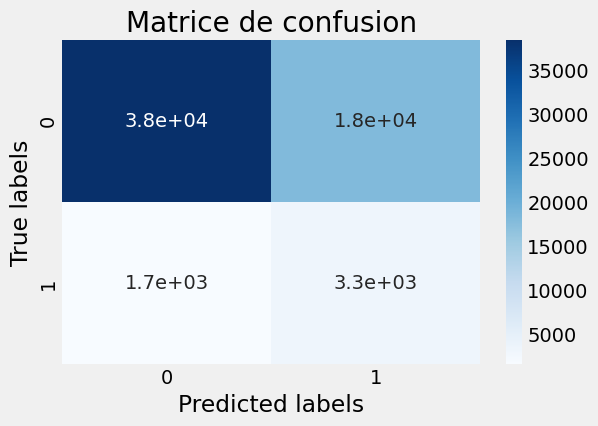

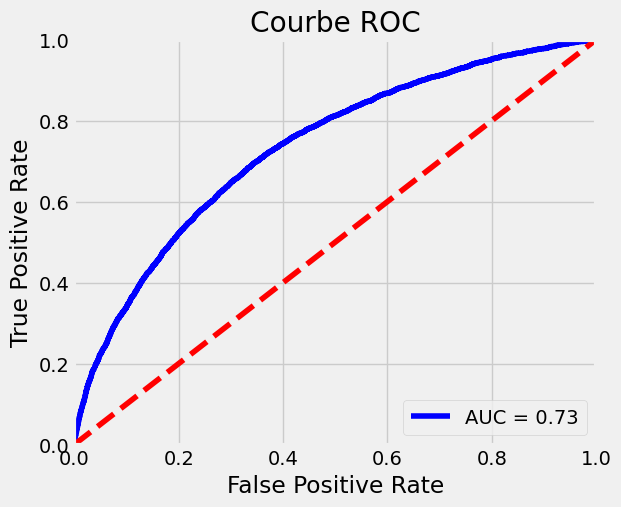

LogisticRegression retesting complete.
Retesting DecisionTreeClassifier with optimized parameters...
Score métier :0.67
Accuracy score : 0.65
Precision score : 0.13
Recall score : 0.56
F1 score : 0.21
Fbeta score : 0.33
ROC AUC score : 0.65


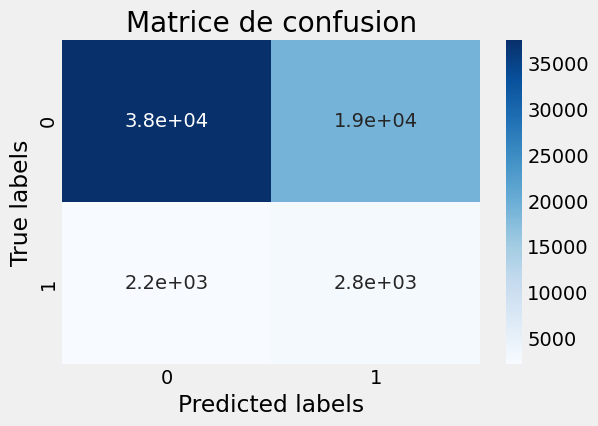

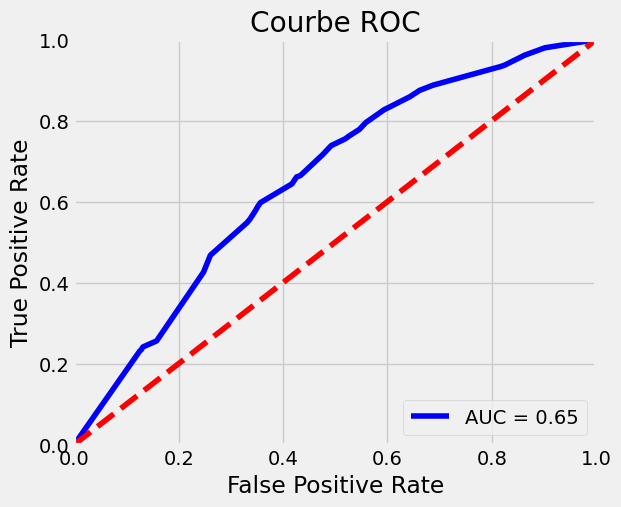

DecisionTreeClassifier retesting complete.
Retesting RandomForestClassifier with optimized parameters...
Score métier :0.62
Accuracy score : 0.72
Precision score : 0.15
Recall score : 0.53
F1 score : 0.23
Fbeta score : 0.35
ROC AUC score : 0.69


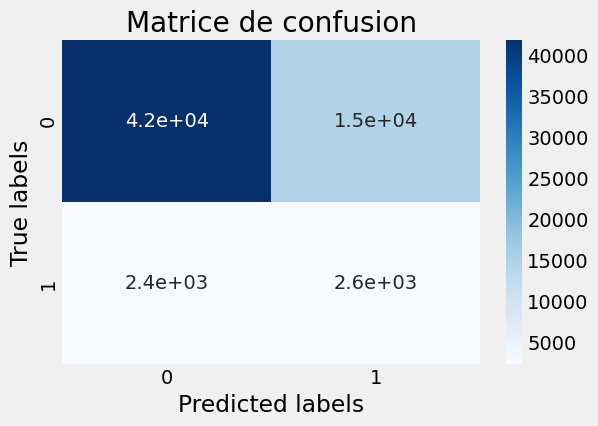

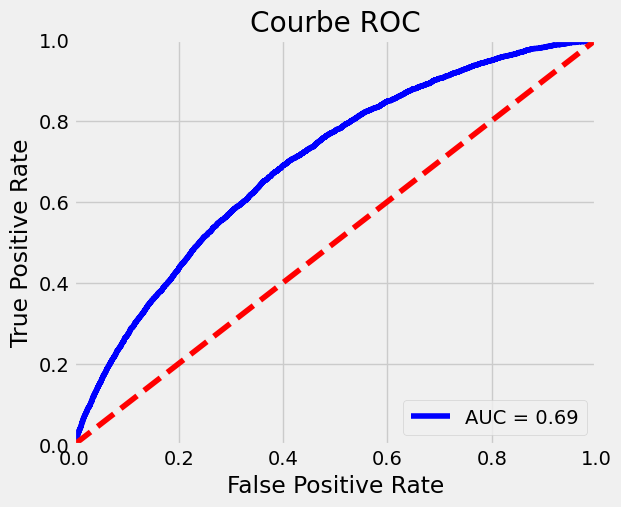

RandomForestClassifier retesting complete.
Retesting XGBClassifier with optimized parameters...
Score métier :0.62
Accuracy score : 0.75
Precision score : 0.16
Recall score : 0.49
F1 score : 0.24
Fbeta score : 0.35
ROC AUC score : 0.70


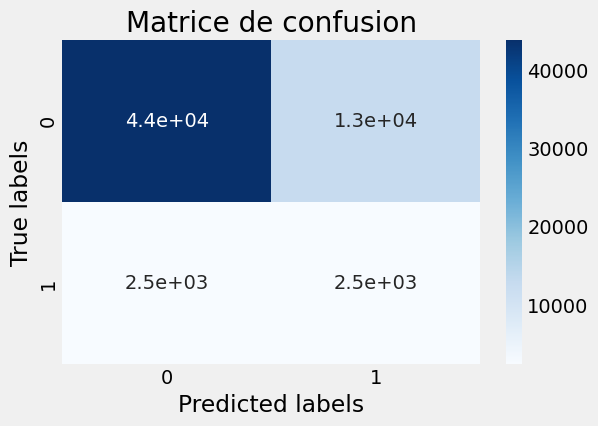

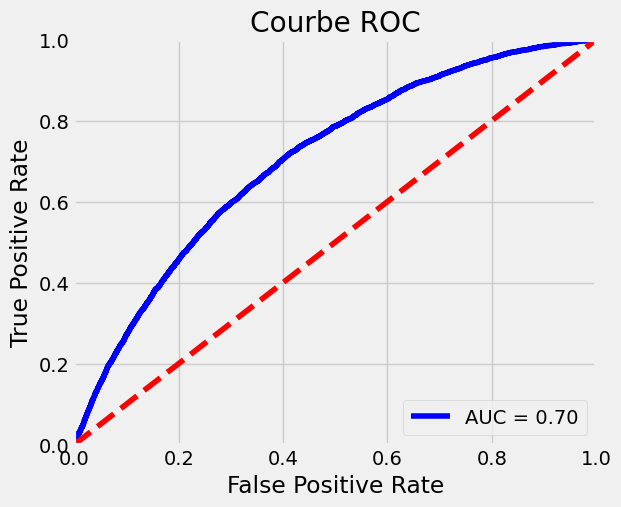

XGBClassifier retesting complete.
Retesting LGBMClassifier with optimized parameters...
Score métier :0.63
Accuracy score : 0.78
Precision score : 0.17
Recall score : 0.43
F1 score : 0.24
Fbeta score : 0.33
ROC AUC score : 0.70


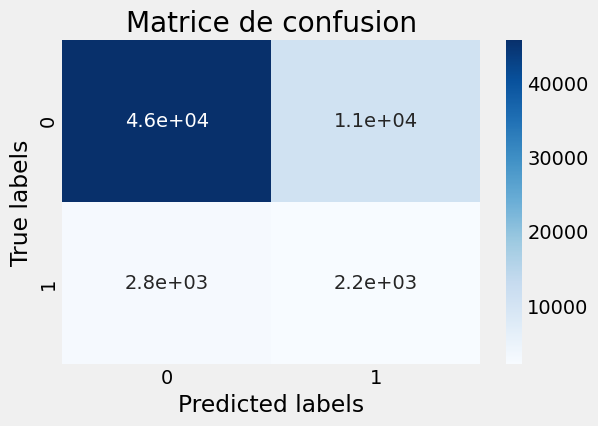

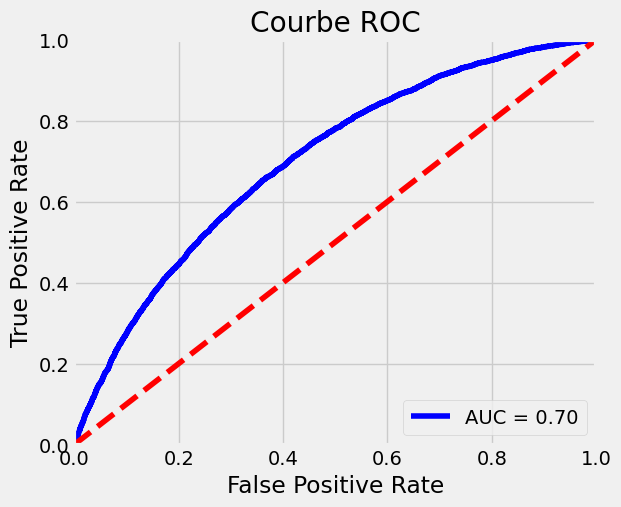

LGBMClassifier retesting complete.


In [101]:
# Test des modèles optimisés et log dans MLflow
for name, model in optimized_models.items():
    print(f"Retesting {name} with optimized parameters...")
    logToMLflow(model, X_train, X_test, y_train, y_test, name=f"Optimized {name}")
    print(f"{name} retesting complete.")